# Visualizations

This notebook contains visualizations of data, especially price and EDA developments, fundamental value, and volatility.

In [1]:
# Imports

import sys, glob, json, re
from pathlib import Path
import numpy as np
import pandas as pd
import neurokit2 as nk
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.colors as mcolors
from datetime import datetime
import math
import statsmodels.formula.api as smf
import random
import seaborn as sns
import os
import itertools
import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [2]:
ROOT_DIR = "/Users/johannanagel/Library/CloudStorage/GoogleDrive-nagel.johanna1@gmail.com/Meine Ablage/Masterarbeit_EDA_ECG_Signals/Kopie von Findec ECG_EDA_EEG Data all sessions"
RESULTS = Path("/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/DataFrames")
ALL_DATA = os.path.join(RESULTS, "all_data_combined.csv")
VISUALIZATION = Path("/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations")
os.makedirs(VISUALIZATION, exist_ok = True)
DEMOGRAPHICS = os.path.join(RESULTS, "demographics_participant.csv")

In [3]:
df = pd.read_csv(ALL_DATA)
df_demographics = pd.read_csv(DEMOGRAPHICS)


#check nan values
print("NaN - Values: ")
print("\n All - Data:")
print(df.isna().sum()[df.isna().sum()>0])
print("\n Demographics:")
print(df_demographics.isna().sum()[df_demographics.isna().sum()>0])


NaN - Values: 

 All - Data:
window_type                           3352
scr_amplitude                         4475
Optimal_Decision_Guisty               5965
Optimal_Decision_Kirchler             6193
Optimal_Decision_Smith                 929
price_t_minus_1                        411
dividend_t_minus_1                     411
price_t_minus_2                        822
dividend_t_minus_2                     822
price_t_minus_3                       1232
dividend_t_minus_3                    1232
price_t_minus_4                       1640
dividend_t_minus_4                    1640
price_t_minus_5                       2045
dividend_t_minus_5                    2045
V_t                                   2045
MAD_t                                 2045
AMAD_t                                2045
mean_return                           2045
return                                 411
Vol_Classification_Global             2045
Vol_Classification_intra_session      2045
Mean_V_t                 

In [4]:
df_demographics

session participant        trading_experience  age  \
0   28-05-2024_14.30 (pre LSL)    uspyk0br                         3   32   
1   28-05-2024_14.30 (pre LSL)    dzw9hmec                         5   24   
2   28-05-2024_14.30 (pre LSL)    3uuuvlfn  1 - No Experience At All   26   
3   28-05-2024_14.30 (pre LSL)    3td05myb                         2   29   
4                   14_11_2024    0b8254y9  1 - No Experience At All   20   
..                         ...         ...                       ...  ...   
84  03-07-2024_15.15 (pre LSL)    rw33oedj                         6   28   
85  03-07-2024_15.15 (pre LSL)    k7rj36eg                         2   21   
86  03-07-2024_15.15 (pre LSL)    sbnjsla1  1 - No Experience At All   22   
87                  19_11_2024    r6mbt4v9                         2   25   
88                  19_11_2024    ept203k9  1 - No Experience At All   26   

    gender occupation                             fatigue_state  \
0   Female    Student                      Okay, somewhat fresh   
1     Male    Student  Very lively, responsive, but not at peak   
2   Female    Student                      Okay, somewhat fresh   
3   Female    Student                      Okay, somewhat fresh   
4     Male    Student  Very lively, responsive, but not at peak   
..     ...        ...                                       ...   
84    Male    Student  Very lively, responsive, but not at peak   
85  Female    Student                Moderately tired, let down   
86    Male    Student                Moderately tired, let down   
87    Male    Student                      Okay, somewhat fresh   
88    Male    Student                  Fully alert, wide awake    

    final_portfolio  final_wallet  final_money performance_classification  \
0                -5        313.41       243.41              Low Performer   
1                -2        677.56       649.56             High Performer   
2                 5        196.97       266.97              Low Performer   
3                15        167.87       377.87             High Performer   
4                 1        155.65       169.65              Low Performer   
..              ...           ...          ...                        ...   
84                8         39.75       151.75              Low Performer   
85               11        236.58       390.58             High Performer   
86                0        247.36       247.36              Low Performer   
87               10        110.31       250.31              Low Performer   
88                2        366.67       394.67             High Performer   

   performance_classification_session_wise  final_earnings_mean  \
0                            Low Performer               322.42   
1                           High Performer               322.42   
2                            Low Performer               322.42   
3                           High Performer               322.42   
4                            Low Performer               229.92   
..                                     ...                  ...   
84                           Low Performer               300.97   
85                          High Performer               300.97   
86                        Medium Performer               300.97   
87                           Low Performer               322.49   
88                          High Performer               322.49   

   performance_classification_session  
0                    Medium Performer  
1                    Medium Performer  
2                    Medium Performer  
3                    Medium Performer  
4                       Low Performer  
..                                ...  
84                   Medium Performer  
85                   Medium Performer  
86                   Medium Performer  
87                   Medium Performer  
88                   Medium Performer  

[89 rows x 14 columns]

# Demographic Statistic

Plotting demographic statistics such as age, gender, occupation, fatique_state.

In [5]:
exclude_cols = ["final_wallet", "final_portfolio", "participant", "final_money", "final_earnings_mean",  "performance_classification", "performance_classification_session", "performance_classification_session_wise"]

cols_to_plot = [c for c in df_demographics.columns if c not in exclude_cols]


for i, col_name in enumerate(cols_to_plot):
    fig, ax = plt.subplots( figsize=(18, 8))
    counts = df_demographics[col_name].value_counts(dropna=False)

    #Plotting columns with a smaller than 5 unique values (which includes gender and occupation, fatigue state)
    if col_name in ['gender', 'occupation'] or len(counts) <= 5:
        wedges, texts, autotexts = ax.pie(
            counts,
            labels=counts.index,
            autopct='%1.1f%%',
            startangle=30,
            textprops={'fontsize': 20}, 
            radius = 1.5
        )
    else:
        #Plotting the rest as a bar diagram (e.g. ager, trading-experience)
        sns.countplot(
            data=df_demographics,
            x=col_name,
            ax=ax,
            color="skyblue",
            order=sorted(df_demographics[col_name].value_counts().index)        # order the values ascending
        )

        ax.set_xlabel("")
        ax.set_ylabel("Count", fontsize=20)
        ax.tick_params(axis='x', rotation=90, labelsize=20)
        ax.tick_params(axis='y', labelsize=20)


    #Saving
    
    #fig.suptitle("Demographics of Participants", fontsize=14, y=0.99)
    plt.tight_layout()
    #plt.show()
    save_path = VISUALIZATION / f"demographics_participant_{col_name}.png"
    fig.savefig(save_path)
    if os.path.exists(save_path):
        print(f"✅ plot was saved under: {save_path}")
    else: 
        print(f"❌ plot was not saved")
    plt.close(fig)


✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_session.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_trading_experience.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_age.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_gender.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_occupation.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/demographics_participant_fatigue_state.png


# Plot Performance

This chapter plots the performance of the sesssion and participants.

In [6]:
#Plotting with boxplot the final performance of participant and session in combination with risk. Looking if there might be insights in performance and risk behavior. 



col_needed = ["session","participant","final_money", "final_earnings_mean",
              "performance_classification", #global performance classification
              "performance_classification_session_wise", #performance classifation of participant in one session
              "performance_classification_session", # perfomance classification of a session
              "gender",                             # gender
              "p_Risk_Smith_categorization_average", # average risk of a participants  by Smith (based on each individual decision)
              "p_Risk_Guisty_categorization_average",  # average risk of a participant  by Giusti (based on each indiviudal decisison)
              "p_Risk_Kirchler_categorization_average", # average risk of a participant by Kirchler (based on each indiviudal decisison)
              "s_Risk_Smith_categorization_average",    # Risk of a session by Smith
              "s_Risk_Guisty_categorization_average",    # Risk of a session by Giusti
              "s_Risk_Kirchler_categorization_average"]   # Risk of a session by Kirchler
df_performance = df[col_needed].drop_duplicates()

performance = [["performance_classification","performance_classification_session_wise","performance_classification_session"]]
for per in performance:
    #rename variables -> remove performer
    df_performance[per] = (
        df_performance[per]
        .replace({
            "Low Performer": "low",
            "Medium Performer": "medium",
            "High Performer": "high"
        })
    )

#defining risk groups
risk_groups = {
    "p_Risk": [ # risk categories of participants
        "p_Risk_Smith_categorization_average",
        "p_Risk_Guisty_categorization_average",
        "p_Risk_Kirchler_categorization_average"
    ],
    "s_Risk": [ # risk categories of session
        "s_Risk_Smith_categorization_average",
        "s_Risk_Guisty_categorization_average",
        "s_Risk_Kirchler_categorization_average"
    ]
}


for risk_group_name, risk_cols in risk_groups.items():
    if risk_group_name == "s_Risk":
        perf_vars = [("performance_classification_session", "Performance Classification (Session)"), ("final_earnings_mean", "Median Earnings")]   #performance variables


    else: 
        #performance variables
        perf_vars = [       
            ("final_money", "Final Money"),
            ("performance_classification", "Performance Classification"),
            ("performance_classification_session_wise", "Performance Classification (Session-wise)") ]
    for perf_col, perf_label in perf_vars:
        #Plotting the variabales with a boxplot/stripplot
        fig, axes = plt.subplots(1, len(risk_cols), figsize=(8 * len(risk_cols), 6))
        axes = np.atleast_1d(axes)

        for i, risk_col in enumerate(risk_cols):
            ax = axes[i] 
            sns.boxplot(data=df_performance, x=risk_col, y=perf_col, ax=ax) #boxplot
            sns.stripplot(data=df_performance, x=risk_col,y=perf_col,ax=ax,dodge=True,jitter=True,alpha=0.6) # points of the variables
            if i == 0:
                ax.set_ylabel(perf_label,  fontsize=25)
            else:
                ax.set_ylabel("")

            ax.set_title(f"{perf_label} for each risk group\n({risk_col})", fontsize=25)
            ax.set_xlabel("Risk", fontsize=25)
            ax.tick_params(axis="both", labelsize=25)
            
        plt.tight_layout()
        save_path = VISUALIZATION / f"performance_{perf_col}.png"
        fig.savefig(save_path)
        if os.path.exists(save_path):
            print(f"✅ plot was saved under: {save_path}")
        else: 
            print(f"❌ plot was not saved")

        plt.tight_layout()
        #plt.show()
        plt.close(fig)





✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/performance_final_money.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/performance_performance_classification.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/performance_performance_classification_session_wise.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/performance_performance_classification_session.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/performance_final_earnings_mean.png


# EDA-Signal

The EDA signal will be plotted here.

In [7]:
#define EDA columns, create eda dataframe
EDA_COLUMNS = ["session", "participant", "round", "price",  "scl_mean", "scl_std", "scr_amplitude", "scr_auc", "scr_count", "scr_per_sec", "signal_range", "signal_std", "window_type"]
df_eda = df[EDA_COLUMNS]

In [8]:
# each round (decision) consists of  decision 5 phases (1 round = 5 phases)
# Conting each phases as a time index ( 40 rounds * 5 phases = time_index of 5 )
# is used for better visualization of the data

window_order = df_eda.window_type.unique()
df_eda["window_num"] = df_eda["window_type"].map({name: i+1 for i, name in enumerate(window_order)})

df_eda["time_index"] = (df_eda["round"] - 1) * len(window_order) + df_eda["window_num"]


df_eda

session participant  round  price   scl_mean  \
0                      14_11_2024    0b8254y9      1  14.09   0.217251   
1                      14_11_2024    0b8254y9      1  14.09   0.102223   
2                      14_11_2024    0b8254y9      1  14.09   0.000628   
3                      14_11_2024    0b8254y9      1  14.09  -0.045347   
4                      14_11_2024    0b8254y9      1  14.09  -0.071926   
...                           ...         ...    ...    ...        ...   
15692  29-05-2024_15.30 (pre LSL)    k9j9nh9y     36  15.70  -3.921180   
15693  29-05-2024_15.30 (pre LSL)    k9j9nh9y     37  15.12  -3.691538   
15694  29-05-2024_15.30 (pre LSL)    k9j9nh9y     38  14.87  -4.287429   
15695  29-05-2024_15.30 (pre LSL)    k9j9nh9y     39  13.97   0.966847   
15696  29-05-2024_15.30 (pre LSL)    k9j9nh9y     40  14.27  15.391967   

        scl_std  scr_amplitude   scr_auc  scr_count  scr_per_sec  \
0      0.018766       0.179607  0.385015          1          0.2   
1      0.040285            NaN  0.003133          0          0.0   
2      0.011225       0.002189  0.002134          1          0.2   
3      0.011444            NaN  0.000000          0          0.0   
4      0.002382       0.003833  0.002936          1          0.2   
...         ...            ...       ...        ...          ...   
15692  0.011531       0.029694  0.026078          1          0.2   
15693  0.024752            NaN  0.057201          0          0.0   
15694  0.036498            NaN  0.039047          0          0.0   
15695  2.103670            NaN  0.000000          0          0.0   
15696  0.154062            NaN  1.224886          0          0.0   

       signal_range  signal_std      window_type  window_num  time_index  
0          0.067279    0.018766     pre_decision           1           1  
1          0.135783    0.040285  during_decision           2           2  
2          0.038088    0.011225              NaN           3           3  
3          0.039005    0.011444  during_feedback           4           4  
4          0.008114    0.002382    post_feedback           5           5  
...             ...         ...              ...         ...         ...  
15692      0.038025    0.011531  during_feedback           4         179  
15693      0.086134    0.024752  during_feedback           4         184  
15694      0.125824    0.036498  during_feedback           4         189  
15695      7.165043    2.103670  during_feedback           4         194  
15696      0.504735    0.154062  during_feedback           4         199  

[15697 rows x 15 columns]

In [9]:
# Plot each EDA metric for each participant in a grid of subplots.
# Left y-axis: EDA metric over time-index (5 = 1 round)
# Right y-axis: price (dashed line) over time-index

metrics = ["scr_auc","scr_per_sec", "scr_count", "scr_amplitude", "scl_mean", "scl_std"]
participants = df_eda["participant"].unique()
#nunber of subplots (rows, columns)
cols = 2                       
rows = math.ceil(len(participants) / cols)

#create a plot for each eda
for eda in metrics:
    print(eda)
    #create one subplot for each participant

    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3.3*rows), sharex=True)
    axes = axes.flatten()
    ax2_refs = []

    for i, p in enumerate(participants):
        ax = axes[i]
        # Filter data for current participant and sort by time_index
        sub = df_eda[df_eda["participant"] == p].sort_values("time_index")
        ax.tick_params(labelbottom=True)

        # Plot EDA metric on the left y-axis
        ax.plot(sub["time_index"], sub[eda], label=eda)
        ax.set_title(str(p))

        # Set x-ticks at the first time_index of each round, e.g. every 5th round
        round_ticks = sub.groupby("round")["time_index"].min().values
        ax.set_xticks(round_ticks[::5])               # every 5th round
        ax.set_xticklabels(sub["round"].unique()[::5])
        ax.set_xlabel("Round")
        ax.set_ylabel(eda)

        # Plot price on a secondary y-axis (right side)
        ax2 = ax.twinx()
        ax2.plot(sub["time_index"], sub["price"], linestyle="--", alpha=0.8, label="price", color="green")
        ax2.set_ylabel("price")
        ax2_refs.append(ax2)

    # Removed unused axes
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j])

    # Buidling a combined legend for EDA metric (left) and price (right)
    h1, l1 = axes[0].get_legend_handles_labels()
    h2, l2 = ax2_refs[0].get_legend_handles_labels()
    fig.legend(h1 + h2, l1 + l2, loc="upper center", ncol=2)
    
    plt.tight_layout()
    save_path = VISUALIZATION / f"eda_price_{eda}.png"
    fig.savefig(save_path)
    if os.path.exists(save_path):
        print(f"✅ plot was saved under: {save_path}")
    else: 
        print(f"❌ plot was not saved")

    
    #plt.show()
    plt.close(fig)


scr_auc
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scr_auc.png
scr_per_sec
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scr_per_sec.png
scr_count
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scr_count.png
scr_amplitude
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scr_amplitude.png
scl_mean
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scl_mean.png
scl_std
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/eda_price_scl_std.png


# Price development

Creating visualizations for the price development.

In [10]:
# Creating new dataframe copy 
df_price = df[["session","round", "price", "sell_count", "n_participants"]].drop_duplicates().sort_values(["session", "round"])

In [11]:
def visulaize_price_developmemts(df, path):
    """ 
        Plotting the price development of each session
        Each session in one plot (inclusive the median)
    """
    fig = plt.figure(figsize=(10,6))
    
    for session, group in df.groupby("session"):
        if session == "Median": 
             plt.plot(
                group["round"], 
                group["price"],
                label=f"Session {session}",
                linewidth=1.2, 
                linestyle="--",
                color="black" )
        else: 
            plt.plot(
                group["round"], 
                group["price"], 
                label=f"Session {session}", 
                alpha=0.7
            )
    
    plt.xlabel("Round")
    plt.ylabel("Price")
    #plt.title("Price Development of all Sessions")
    plt.legend(title="Session", bbox_to_anchor=(1.05, 1.0), loc="upper left")
    plt.tight_layout()
    #plt.show()
    fig.savefig(path, dpi=300) 
    plt.close()

def plot_price_and_sells_per_round_colored(
    df_rounds: pd.DataFrame,
    folder: str,
    show_rugs: bool = True,     # red line on y=0 for round without sells 
):
    """

    Draws a FacetGrid: one subplot per session
        - Price (y) over rounds (x) as points, color-coded:
            blue  = sell_count > 0
            red   = sell_count == 0
        plus a subtle price line (dashed)
        - # of sells as a separate line on the right y-axis
        - red rug marks at y=0 for no-sells
    """

    need = {"session", "round", "price", "sell_count"}
    miss = need - set(df_rounds.columns)
    if miss:
        raise ValueError(f"Missing columns: {sorted(miss)}")

    df = df_rounds.copy()
    # Make it numerical
    df["round"] = pd.to_numeric(df["round"], errors="coerce")
    df["price"] = pd.to_numeric(df["price"], errors="coerce")
    df["sell_count"] = pd.to_numeric(df["sell_count"], errors="coerce")
    df = df.dropna(subset=["round", "price", "sell_count"])
    df = df.sort_values(["session", "round"])

    sessions = list(pd.unique(df["session"]))
    if not sessions:
        raise ValueError("No session founds gefunden.")

    # Elements of the legend
    legend_items = {
        "Price (sells)": Line2D([0],[0], marker='o', color='none',
                                markerfacecolor='skyblue', markeredgecolor='black',
                                markersize=6, label="Price (sells)"),
        "Price (no sells)": Line2D([0],[0], marker='o', color='none',
                                   markerfacecolor='red', markeredgecolor='black',
                                   markersize=6, label="Price (no sells)"),
        "# Sells": Line2D([0],[0], color='C3', marker='s', linewidth=1.6, markersize=4, label="# Sells"),
        "Price trend": Line2D([0],[0], color='gray', linestyle='--', linewidth=1.2, label="Price trend"),
    }
    
    if show_rugs:
        legend_items["0 sells (rug)"] = Line2D([0],[0], marker='_', color='red', linestyle='None', markersize=12, label="0 sells (rug)")

    for idx, session in enumerate(sessions):

        sub = df[df["session"] == session].sort_values("round")
        if sub.empty:
            ax_price.axis("off")
            continue

        fig, ax_price = plt.subplots(figsize=(8,4))

        # price trend line
        ax_price.plot(sub["round"], sub["price"],
                      linestyle="--", linewidth=1.2, color="gray", alpha=0.9)

    
        ax_price.axhline(0, color="lightgray", linewidth=1)


        # Coloring sell or no-stell data
        colors = np.where(sub["sell_count"] == 0, "red", "skyblue")
        ax_price.scatter(sub["round"], sub["price"],
                         s=50, c=colors, edgecolors="black", linewidths=0.5, zorder=3)

        # Optional: Rugs (red line) on y=0 if No-Sells
        if show_rugs:
            no_sell_rounds = sub.loc[sub["sell_count"] == 0, "round"].to_numpy()
            if no_sell_rounds.size > 0:
                ax_price.scatter(no_sell_rounds, np.zeros_like(no_sell_rounds),
                                 marker="_", s=260, color="red", zorder=4)

        
        ax_sells = ax_price.twinx()
        ax_sells.plot(sub["round"], sub["sell_count"],
                      color="C3", linewidth=1.6, marker="s", markersize=4, alpha=0.9)

       
        #ax_price.set_title(f"Session {session}", pad=5)
        ax_price.set_xlabel("Round")
        ax_price.set_ylabel("Price")
        ax_sells.set_ylabel("# Sells", color="C3")
        ax_sells.tick_params(axis="y", labelcolor="C3")

        ymax = float(sub["price"].max())
        ax_price.set_ylim(-1, ymax * 1.08)      
        ax_price.grid(True, axis="y", linestyle=":", alpha=0.25)

        fig.legend(legend_items.values(), legend_items.keys(),
               loc="upper center", ncol=min(5, len(legend_items)), frameon=False, bbox_to_anchor =(0.5, 1.02), fontsize = 12)

        fig.tight_layout(rect = [0,0,1,0.95])
        file = folder / f"price_sell_{session}.png"
        fig.savefig(file, dpi=300) 
        if file.exists():
            print(file)
        #plt.show()
        plt.close()

def plot_small_big_sessions(df_with_avg, stats, max_session, avg_price, path):
    """
        Plot price developments of session with the biggest and the smallest median
    """
    sessions_to_plot = [
        stats.iloc[0]["session"],                # smallest Median
        stats.iloc[len(stats)//2]["session"],  #  Median
        stats.iloc[-1]["session"],               # biggest Median
        avg_price.iloc[0]["session"],
        max_session.iloc[-1]["session"], 

    ]
    print(sessions_to_plot)
    # Schritt 2: Plotten
    fig = plt.figure(figsize=(8,4))

    for session, group in df_with_avg[df_with_avg["session"].isin(sessions_to_plot)].groupby("session"):
        plt.plot(group["round"], group["price"], label=f"Session {session}")

    plt.xlabel("Round")
    plt.ylabel("Price")
    #plt.title("Price development: small, middle und big Median, Median-Session, Session with biggest price")
    plt.legend(title="Session")
    plt.tight_layout()
    fig.savefig(path, dpi=300)
    #plt.show()
    plt.close()

def plot_smallest_or_biggest_sessions(df, path, title):
    """
        Plot the price development of the session with the highest or smallest price
    """
    fig = plt.figure(figsize = (8,4))
    for session, group in df.groupby("session"):
        plt.plot(group["round"], group["price"], label=f"Session {session}")

    plt.xlabel("Round")
    plt.ylabel("Price")
    #plt.title(f"Price development: {title}")
    plt.legend(title="Session")
    plt.tight_layout()
    fig.savefig(path, dpi=300)
    # plt.show()
    plt.close()

    



In [12]:
df_price[df_price["session"] == "20-08-2024_13.45(no fMRI)"]

session  round  price  sell_count  n_participants
3287  20-08-2024_13.45(no fMRI)      1  16.97           1               5
3292  20-08-2024_13.45(no fMRI)      2  18.52           2               5
3297  20-08-2024_13.45(no fMRI)      3  19.26           0               5
3302  20-08-2024_13.45(no fMRI)      4  21.43           1               5
3307  20-08-2024_13.45(no fMRI)      5  23.37           1               5
3311  20-08-2024_13.45(no fMRI)      6  24.74           0               5
3456  20-08-2024_13.45(no fMRI)      7  26.07           0               4
3316  20-08-2024_13.45(no fMRI)      8  30.19           0               5
3321  20-08-2024_13.45(no fMRI)      9  36.85           0               5
3324  20-08-2024_13.45(no fMRI)     10  41.69           1               5
3326  20-08-2024_13.45(no fMRI)     11  45.48           0               5
3329  20-08-2024_13.45(no fMRI)     12  49.83           0               5
3333  20-08-2024_13.45(no fMRI)     13  56.68           1               5
3337  20-08-2024_13.45(no fMRI)     14  52.15           1               5
3341  20-08-2024_13.45(no fMRI)     15  47.51           1               5
3345  20-08-2024_13.45(no fMRI)     16  45.25           1               5
3348  20-08-2024_13.45(no fMRI)     17  45.26           1               5
3350  20-08-2024_13.45(no fMRI)     18  49.46           1               5
3353  20-08-2024_13.45(no fMRI)     19  51.06           1               5
3357  20-08-2024_13.45(no fMRI)     20  50.54           0               5
3361  20-08-2024_13.45(no fMRI)     21  41.68           1               5
3363  20-08-2024_13.45(no fMRI)     22  36.91           1               5
3368  20-08-2024_13.45(no fMRI)     23  39.00           1               5
3370  20-08-2024_13.45(no fMRI)     24  45.36           0               5
3374  20-08-2024_13.45(no fMRI)     25  48.20           1               5
3377  20-08-2024_13.45(no fMRI)     26  50.57           1               5
3381  20-08-2024_13.45(no fMRI)     27  54.56           1               5
3383  20-08-2024_13.45(no fMRI)     28  48.15           1               5
3387  20-08-2024_13.45(no fMRI)     29  41.79           1               5
3392  20-08-2024_13.45(no fMRI)     30  35.31           1               5
3576  20-08-2024_13.45(no fMRI)     31  33.72           1               4
3395  20-08-2024_13.45(no fMRI)     32  36.84           0               5
3398  20-08-2024_13.45(no fMRI)     33  43.16           1               5
3401  20-08-2024_13.45(no fMRI)     34  38.83           0               5
3403  20-08-2024_13.45(no fMRI)     35  31.92           0               4
3407  20-08-2024_13.45(no fMRI)     36  29.42           0               4
3410  20-08-2024_13.45(no fMRI)     37  23.94           0               4
3413  20-08-2024_13.45(no fMRI)     38  22.69           0               3
3417  20-08-2024_13.45(no fMRI)     39  19.80           0               3
3422  20-08-2024_13.45(no fMRI)     40  16.74           0               3

In [13]:
#calc the median price development of all sessions
avg_price = (
    df_price.groupby("round")["price"]
      .median() #robust against outlier
      .reset_index(name="price")
)



avg_price["session"] = "Median"
avg_price["sell_count"] = 0
avg_price["n_participants"] = 0

avg_price = avg_price[["session", "round", "price","sell_count", "n_participants"]]


df_with_avg = pd.concat([df_price, avg_price], ignore_index=True)

print(df_with_avg.tail().head())



# Plotting the price developments of all sessions
saving_path = os.path.join(VISUALIZATION, "price_development_all_sessions.png") 
visulaize_price_developmemts(df_with_avg, saving_path)

print("===== price development with transaction types and number of transactions =====")
plot_price_and_sells_per_round_colored(df_price, VISUALIZATION, show_rugs=True)


def calculate_price_mean_std(df):
    stats = (
    df.groupby("session")["price"]
      .agg(["mean", "median", "std", "min", "max", ])
      .reset_index()
    )

    return stats

# Plotting the session with the biggest and smallest median
stats = calculate_price_mean_std(df_price)
stats = stats.sort_values(by=["median"] )
new_stats = stats.sort_values(by=["max"] )


path_small_biggest = os.path.join(VISUALIZATION,"price_development_smallest_middlest_biggest_average.png")
plot_small_big_sessions(df_with_avg, stats, new_stats,avg_price,path_small_biggest )


###  Plotting the 5 sessions of the highest or smallest mean

maxprice = df_price.groupby(["session"])["price"].max().sort_values(ascending= True)
df_small = maxprice.head(5).reset_index()
df_big = maxprice.tail(5).reset_index()
#df_small_big = pd.concat([df_big, df_small]).reset_index()
rows_small = []
for idx, row in df_price.iterrows():
    if row["session"] in df_small["session"].values:
        rows_small.append(row)
df_price_small = pd.DataFrame(rows_small)

rows_big = []
for idx, row in df_price.iterrows():
    if row["session"] in df_big["session"].values:
        rows_big.append(row)
df_price_big = pd.DataFrame(rows_big)

path_small = os.path.join(VISUALIZATION,"price_small.png")
path_big = os.path.join(VISUALIZATION,"price_big.png")
plot_smallest_biggest_sessions = plot_smallest_or_biggest_sessions(df_price_small, path_small, "Min Max prices")
plot_smallest_biggest_sessions = plot_smallest_or_biggest_sessions(df_price_big, path_big, "Max Max price")




    session  round  price  sell_count  n_participants
875  Median     36  20.53           0               0
876  Median     37  18.33           0               0
877  Median     38  18.30           0               0
878  Median     39  18.66           0               0
879  Median     40  16.74           0               0
===== price development with transaction types and number of transactions =====
/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/price_sell_02-07-2024_14.15 (pre LSL).png
/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/price_sell_02-07-2024_16.30 (pre LSL).png
/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/price_sell_03-07-2024_15.15 (pre LSL).png
/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/price_sell_06-08-2024_13.15.png
/Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Vis

# Fundamental Value

In [14]:
# Visualize the fundamental values over 40 rounds by SMITH, GIUSTY, KIRCHLER

df_fv = df[[ "round", "FV_SMITH","FV_GUISTY", "FV_KIRCHLER"]].drop_duplicates().sort_values([ "round"])

path_FV = os.path.join(VISUALIZATION, "fundamental_vale.png") 

fig = plt.figure(figsize=(6,4))

plt.plot(df_fv["round"], df_fv["FV_SMITH"], label="FV (Smith (2014))", linewidth=2)
plt.plot(df_fv["round"], df_fv["FV_GUISTY"], label="FV (Guisty (2016))", linewidth=2)
plt.plot(df_fv["round"], df_fv["FV_KIRCHLER"], label="FV (Kirchler (2012))", linewidth=2)


for session, group in df_with_avg[df_with_avg["session"] == "Median"].groupby("session"):
    plt.plot(group["round"], group["price"], label=f"Price {session}")


plt.xlabel("Round")
plt.ylabel("Fundamental Value")
#plt.title("Fundamental Values")
plt.legend(loc='upper right', framealpha=0.7, bbox_to_anchor=(1, 0.87) )
plt.grid(True)
plt.tight_layout()
plt.savefig(path_FV,dpi=300)
#plt.show()
plt.close()

# Cash/Asset Ratio

In [15]:


def plot_three_cash_asset_ratios(df, pdf_path):
    "Plotting C/A Ratio of all sessions by using the FV of the three researcher"

    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "font.size": 4,
        "axes.labelsize": 4,
        "axes.titlesize": 4,
        "legend.fontsize": 4,
        "xtick.labelsize": 4,
        "ytick.labelsize": 4,
        "lines.linewidth": 0.9, 
    })

    sessions = df["session"].drop_duplicates().tolist()

    with PdfPages(pdf_path) as pdf:
        # title page
        fig = plt.figure(figsize=(8.5, 5.5))
        plt.axis("off")
        plt.text(0.5, 0.6, "Compare the Cash/Asset Ratio of each session", 
                 ha="center", va="center", fontsize=18)
        plt.text(0.5, 0.45, f"Number of sessions: {len(sessions)}", 
                 ha="center", va="center", fontsize=12)
        pdf.savefig(fig, bbox_inches="tight")
        plt.close(fig)

        # Colors and labels 
        ratio_cols = {
            "cash_asset_ratio_KIRCHLER": "Kirchler et al.",
            "cash_asset_ratio_GUISTY": "Giusti et al.",
            "cash_asset_ratio_SMITH": "Smith et al."
        }

        colors = {
            "cash_asset_ratio_KIRCHLER": "#1f77b4",  # blue
            "cash_asset_ratio_GUISTY": "#2ca02c",    # green
            "cash_asset_ratio_SMITH": "#d62728",     # red
        }
        
        # Overview over all sessions
        fig, ax = plt.subplots(figsize=(2.5, 1.5))
        for col, label in ratio_cols.items():
            for s in sessions:
                tmp = df[df["session"] == s].sort_values("round")
                ax.plot(tmp["round"], tmp[col], alpha=0.4, color=colors[col])
            ax.plot([], [], color=colors[col], label=label)  
        ax.set_title("Cash/Asset Ratios – Overview over all sessions")
        ax.set_xlabel("Rounds")
        ax.set_ylabel("Cash/Asset Ratio")
        ax.grid(True, alpha=0.3)
        ax.legend(
                loc="best", frameon=False, handlelength=1.2,
                borderpad=0.2, labelspacing=0.15, handletextpad=0.3
            )
        pdf.savefig(fig, bbox_inches="tight")
        #plt.show()
        plt.close(fig)

    print(f"✅ Saving all plots in in: {pdf_path}")



df_cashA= df[["session", "round", "cash_asset_ratio_KIRCHLER", "cash_asset_ratio_GUISTY", "cash_asset_ratio_SMITH"]].drop_duplicates().sort_values(["session", "round"])
saving_path_CA = os.path.join(VISUALIZATION, "Cash_Asset_Ratio.pdf") 
#calling the C/A Visualization method
plot_three_cash_asset_ratios(df_cashA, saving_path_CA)


✅ Saving all plots in in: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Cash_Asset_Ratio.pdf


# Price Minus FV

In [16]:

def plot_price_minus_FV_tiny_clean(
    df,
    output_dir,
    grayscale=False,
    file_format="png"
):
    """
    Plotting the deviation between price and the FV for each session. 
    Each session is saved as a separate figure file.
    """

    # Check folder
    os.makedirs(output_dir, exist_ok=True)

    # Settings: Label sizes
    plt.rcParams.update({
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "font.size": 4,
        "axes.labelsize": 4,
        "axes.titlesize": 4,
        "legend.fontsize": 4,
        "xtick.labelsize": 4,
        "ytick.labelsize": 4,
        "lines.linewidth": 0.9,
    })

    color = "k" if grayscale else "#1f77b4"
    linestyle = "-"

    # Create list of sessions
    sessions = df["session"].drop_duplicates().tolist()
    tiny_size = (2.0, 1.0)  

    for s in sessions:
        # Sort round values ascending
        tmp = df[df["session"] == s].sort_values("round")

        #create subplot 
        fig, ax = plt.subplots(figsize=tiny_size, constrained_layout=True)

        # Plot Price - FV over rounds
        ax.plot(
            tmp["round"], tmp["price_minus_FV"],
            color=color,
            linestyle=linestyle,
        )

        # Adding refernce line at zero deviation
        ax.axhline(0, color="gray", linewidth=0.6, linestyle="--", alpha=0.7)

        #Titles and labels
        ax.set_title(f"Session {s}", pad=2)
        ax.set_xlabel("Round")
        ax.set_ylabel("Price − FV")
        ax.grid(True, alpha=0.25)

        # Create file_name
        filename = f"price_minus_FV_session_{s}.{file_format}"
        save_path = os.path.join(output_dir, filename)

        fig.savefig(save_path, bbox_inches="tight")
        plt.close(fig)

        print(f"✅ Saved plot for session {s} at: {save_path}")

    print(f"🎯 All session plots saved in: {output_dir}")

#Calling method
df_price_minus_fv = df[["session", "round", "price", "price_minus_FV"]].drop_duplicates().sort_values(["session", "round"])
output_dir_price_minus_FV = os.path.join(VISUALIZATION, "Price_minus_FV_sessions")
plot_price_minus_FV_tiny_clean(df_price_minus_fv, output_dir_price_minus_FV, grayscale=False, file_format="png")

✅ Saved plot for session 02-07-2024_14.15 (pre LSL) at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Price_minus_FV_sessions/price_minus_FV_session_02-07-2024_14.15 (pre LSL).png
✅ Saved plot for session 02-07-2024_16.30 (pre LSL) at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Price_minus_FV_sessions/price_minus_FV_session_02-07-2024_16.30 (pre LSL).png
✅ Saved plot for session 03-07-2024_15.15 (pre LSL) at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Price_minus_FV_sessions/price_minus_FV_session_03-07-2024_15.15 (pre LSL).png
✅ Saved plot for session 06-08-2024_13.15 at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Price_minus_FV_sessions/price_minus_FV_session_06-08-2024_13.15.png
✅ Saved plot for session 07_11_2024 at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualiza

In [19]:
def plot_combined_rd_rad(df, path, cols=2, figsize_single=(5, 2.7)):
    """
    Plot RD & RAD for Guisty, Kirchler, Smith in one figure per session (grid).
    Includes a small overall title per figure.
    """

    g_rd  = "rd_GUISTY_per_round"
    g_rad = "rad_GUISTY_per_round"
    k_rd  = "rd_Kirchler_per_round"
    k_rad = "rad_Kirchler_per_round"
    l_rd  = "rd_Smith_per_round"
    l_rad = "rad_Smith_per_round"

    if "session" not in df.columns or "round" not in df.columns:
        raise KeyError("Columns 'session' and 'round' are required.")

    #return all sessions
    sessions = sorted(df["session"].unique())
    #calc number rows
    rows = math.ceil(len(sessions) / cols)

    #create subplot
    fig, axes = plt.subplots(
        rows, cols,
        figsize=(cols * figsize_single[0], rows * figsize_single[1]),
        squeeze=False
    )

    # Create suptitle for the plot
    fig.suptitle(
        "Combined RD & RAD – Guisty & Kirchler & Smith",
        fontsize=12,
        y=0.99,
        fontweight="bold"
    )

    handles, labels = None, None

    for idx, sess in enumerate(sessions):
        r, c = divmod(idx, cols)
        ax = axes[r, c]
        grp = df[df["session"] == sess].sort_values("round")

        # Guisty
        g1, = ax.plot(grp["round"], grp[g_rd],  linewidth=1.6, label="RD (Guisty)")
        g2, = ax.plot(grp["round"], grp[g_rad], linestyle=":", linewidth=1.6, label="RAD (Guisty)")

        # Kirchler
        k1, = ax.plot(grp["round"], grp[k_rd],  linewidth=1.6, label="RD (Kirchler)")
        k2, = ax.plot(grp["round"], grp[k_rad], linestyle=":", linewidth=1.6, label="RAD (Kirchler)")

        # Smith
        l1, = ax.plot(grp["round"], grp[l_rd],  linewidth=1.6, label="RD (Smith)")
        l2, = ax.plot(grp["round"], grp[l_rad], linestyle=":", linewidth=1.6, label="RAD (Smith)")

        ax.axhline(0, linestyle="--", linewidth=1, alpha=0.7)
        ax.set_title(f"Session {sess}", fontsize=9, pad=2)
        ax.set_xlabel("Round", fontsize=8)
        ax.set_ylabel("RD / RAD", fontsize=8)
        ax.grid(True, linestyle=":", alpha=0.6)

        if handles is None:
            handles, labels = [g1, g2, k1, k2, l1, l2], [
                "RD (Guisty)", "RAD (Guisty, dotted)",
                "RD (Kirchler)", "RAD (Kirchler, dotted)",
                "RD (Smith)", "RAD (Smith, dotted)"
            ]

    total = rows * cols
    for i in range(len(sessions), total):
        r, c = divmod(i, cols)
        axes[r, c].axis("off")

    if handles:
        # Create legnd based on the handles.
        fig.legend(
            handles, labels,
            loc="upper center",
            ncol=2,
            frameon=True,
            fontsize=9,
            bbox_to_anchor=(0.5, 0.978),
            borderaxespad=0.2
        )

    plt.tight_layout(pad=0.8, rect=[0, 0, 1, 0.96])


    plt.savefig(path, dpi=300, bbox_inches="tight")
    #plt.show()
    plt.close()
    print(f"✅ Saved: {path}")

df_rad = df[["session", "round", "price", "FV_GUISTY","FV_KIRCHLER","FV_SMITH",  "rd_Smith_per_round", "rad_Smith_per_round","rd_Kirchler_per_round", "rad_Kirchler_per_round", "rad_GUISTY_per_round", "rd_GUISTY_per_round"]].copy().drop_duplicates().sort_values(["session", "round"])
path = VISUALIZATION / "Combined_RD_RAD-Guisty_Kirchler_Smith.png"
plot_combined_rd_rad(df_rad,path, cols=2, figsize_single=(5, 2.7))

✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Combined_RD_RAD-Guisty_Kirchler_Smith.png


In [20]:

def plot_combined_rd_rad_grid(df, out_path, required_sessions, n_total=4, figsize_single=(5, 2.7)):
    """
    Create a 2x2 grid with RD & RAD plots for 4 sessions.
    required_sessions: substrings that MUST be included.
    """


    all_sessions = sorted(df["session"].unique())
    selected = []


    for req in required_sessions:
        matches = [s for s in all_sessions if req in s]
        if matches:
            selected.append(matches[0])
        else:
            print(f"⚠️ Required session not found: {req}")


    remaining = [s for s in all_sessions if s not in selected]

    while len(selected) < n_total and remaining:
        chosen = random.choice(remaining)
        remaining.remove(chosen)
        selected.append(chosen)

    print(f"➡️ Plotting sessions: {selected}")

    # Grid size 
    rows, cols = 2, 2  # fixed 4 plots
    figsize = (cols * figsize_single[0], rows * figsize_single[1])

    fig, axes = plt.subplots(rows, cols, figsize=figsize, squeeze=False, constrained_layout=True)

    # RD/RAD Columns 
    g_rd  = "rd_GUISTY_per_round"
    g_rad = "rad_GUISTY_per_round"
    k_rd  = "rd_Kirchler_per_round"
    k_rad = "rad_Kirchler_per_round"
    l_rd  = "rd_Smith_per_round"
    l_rad = "rad_Smith_per_round"

    # Loop over 4 sessions 
    for idx, sess in enumerate(selected):
        r, c = divmod(idx, cols)
        ax = axes[r, c]

        grp = df[df["session"] == sess].sort_values("round")

        # Guisty
        ax.plot(grp["round"], grp[g_rd],  linewidth=1.6, label="RD (Guisty)")
        ax.plot(grp["round"], grp[g_rad], linestyle=":", linewidth=1.6, label="RAD (Guisty)")

        # Kirchler
        ax.plot(grp["round"], grp[k_rd],  linewidth=1.6, label="RD (Kirchler)")
        ax.plot(grp["round"], grp[k_rad], linestyle=":", linewidth=1.6, label="RAD (Kirchler)")

        # Smith
        ax.plot(grp["round"], grp[l_rd],  linewidth=1.6, label="RD (Smith)")
        ax.plot(grp["round"], grp[l_rad], linestyle=":", linewidth=1.6, label="RAD (Smith)")

        ax.axhline(0, linestyle="--", linewidth=1, alpha=0.7)
        ax.set_title(f"Session {sess}", fontsize=15, pad=6)
        ax.set_xlabel("Round", fontsize=13)
        ax.set_ylabel("RD / RAD", fontsize=13)
        ax.tick_params(axis="x", labelsize=13)
        ax.tick_params(axis="y", labelsize=13)
        ax.grid(True, linestyle=":", alpha=0.6)

    # Legend for entire figure
    fig.legend(
        loc="upper center",
        ncol=6,
        fontsize=9,
        frameon=True,
        bbox_to_anchor=(0.55, 1.20)
    )

    #fig.suptitle("Combined RD & RAD – Selected Sessions", fontsize=12, y=1.15, fontweight="bold")
    #plt.tight_layout(rect=[0, 0, 0.88, 1])

    # Save output 
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"✅ Saved grid figure → {out_path}")


#required sessions
required = ["21_11_2024", "02-07-2024", "20-08-2024_16.15", "27-08-2024"]

out_dir = VISUALIZATION / "Combined_RD_RAD_Selected.png"

plot_combined_rd_rad_grid(df_rad, out_dir, required_sessions=required, n_total=4)


➡️ Plotting sessions: ['21_11_2024 (no fMRI) ', '02-07-2024_14.15 (pre LSL)', '20-08-2024_16.15(no fMRI)', '27-08-2024_13.45']
✅ Saved grid figure → /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Combined_RD_RAD_Selected.png


In [21]:

def _counts_per_session(df, col):
    """
    Counting the number of Overpricing, Underpricing and Fair categories per session 
    """
    valid = ["Overpricing", "Underpricing", "Fair"]
    dfx = df.copy()
    dfx[col] = dfx[col].astype(str).str.strip().str.capitalize()
    #counting the categories
    counts = (
        dfx[dfx[col].isin(valid)]
        .groupby(["session", col])
        .size()
        .unstack(fill_value=0)
        .reindex(columns=valid, fill_value=0)
        .sort_index()
    )
    return counts

def plot_heatmap_categorization_clear(df, col, title, path):
    """
    Creates a clean and readable heatmap for pricing categorization counts per session.
    """

    # frequency of each category per session
    counts = _counts_per_session(df, col)
    data = counts.values
    cats = list(counts.columns)
    sessions = counts.index.astype(str).tolist()

    
    fig_height = max(4, 0.35 * len(sessions))
    fig, ax = plt.subplots(figsize=(7, fig_height))


    im = ax.imshow(data, aspect="auto")

   
    vmax = np.max(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = int(data[i, j])
           
            color = "white" if data[i, j] > vmax * 0.6 else "black"
            ax.text(j, i, val, ha="center", va="center", fontsize=9, color=color)

    
    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats, fontsize=10, fontweight="bold")
    ax.set_yticks(np.arange(len(sessions)))
    ax.set_yticklabels(sessions, fontsize=9)

    
    ax.set_xlabel("Category", fontsize=11, labelpad=6)
    ax.set_ylabel("Session", fontsize=11, labelpad=6)
    if title:
        ax.set_title(title, fontsize=13, fontweight="bold", pad=10)

    
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Number of Observations", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    
    ax.set_xticks(np.arange(-0.5, len(cats), 1), minor=True)
    ax.set_yticks(np.arange(-0.5, len(sessions), 1), minor=True)
    ax.grid(which="minor", color="white", linestyle="-", linewidth=0.6)
    ax.tick_params(which="minor", bottom=False, left=False)

   
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    #plt.show()
    print(f"✅ Saved: {path}")
    plt.close()


##Plotting heatmap for every case 

df_heatmap = df[["session", "round", "price","rd_Kirchler_categorization", "Category_Guisty_round", "rd_Smith_categorization" ]].copy().drop_duplicates().sort_values(["session", "round"])

path_heatmap_kirchler= os.path.join(VISUALIZATION, "heatmap_kirchler_categorization_bubble.png") 
path_heatmap_guisty= os.path.join(VISUALIZATION, "heatmap_guisty_categorization_bubble.png") 
path_heatmap_smith = os.path.join(VISUALIZATION, "heatmap_smith_categorization_bubble.png") 

plot_heatmap_categorization_clear(df_heatmap, "rd_Kirchler_categorization",
                            title="Kirchler – Categorization (Counts per Session)",
                            path=path_heatmap_kirchler)

plot_heatmap_categorization_clear(df_heatmap, "Category_Guisty_round",
                            title="Guisty – Categorization (Counts per Session)",
                            path=path_heatmap_guisty)


plot_heatmap_categorization_clear(df_heatmap, "rd_Smith_categorization",
                            title="Smith – Categorization (Counts per Session)",
                            path=path_heatmap_guisty)

✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_kirchler_categorization_bubble.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_guisty_categorization_bubble.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_guisty_categorization_bubble.png


In [22]:
df_heatmap = df[["session", "round", "price","rd_Kirchler_categorization", "rd_Kirchler_categorization", "rd_Smith_categorization" ]].copy().drop_duplicates().sort_values(["session", "round"])
df_heatmap

session  round  price rd_Kirchler_categorization  \
11441  02-07-2024_14.15 (pre LSL)      1  13.94               Underpricing   
11444  02-07-2024_14.15 (pre LSL)      2  14.76               Underpricing   
11447  02-07-2024_14.15 (pre LSL)      3  15.65               Underpricing   
11450  02-07-2024_14.15 (pre LSL)      4  15.46               Underpricing   
11453  02-07-2024_14.15 (pre LSL)      5  16.73               Underpricing   
...                           ...    ...    ...                        ...   
14053  29-05-2024_15.30 (pre LSL)     36  15.70               Underpricing   
14056  29-05-2024_15.30 (pre LSL)     37  15.12               Underpricing   
14059  29-05-2024_15.30 (pre LSL)     38  14.87               Underpricing   
14062  29-05-2024_15.30 (pre LSL)     39  13.97               Underpricing   
14065  29-05-2024_15.30 (pre LSL)     40  14.27                Overpricing   

      rd_Kirchler_categorization rd_Smith_categorization  
11441               Underpricing             Overpricing  
11444               Underpricing             Overpricing  
11447               Underpricing             Overpricing  
11450               Underpricing             Overpricing  
11453               Underpricing             Overpricing  
...                          ...                     ...  
14053               Underpricing             Overpricing  
14056               Underpricing             Overpricing  
14059               Underpricing             Overpricing  
14062               Underpricing             Overpricing  
14065                Overpricing             Overpricing  

[840 rows x 6 columns]

In [23]:
EDA_COL = ["scl_mean", "scl_std", "scr_amplitude", "scr_auc", "scr_count", "scr_per_sec", "signal_range", "signal_std", "window_type"]

In [24]:
df_decision_FV = df.copy().drop(columns=EDA_COL).drop_duplicates().sort_values(["session", "participant", "round"])
df_decision_FV

session participant  round  price transaction  \
11441  02-07-2024_14.15 (pre LSL)    ci283zh0      1  13.94        none   
11444  02-07-2024_14.15 (pre LSL)    ci283zh0      2  14.76        none   
11447  02-07-2024_14.15 (pre LSL)    ci283zh0      3  15.65         buy   
11450  02-07-2024_14.15 (pre LSL)    ci283zh0      4  15.46        none   
11453  02-07-2024_14.15 (pre LSL)    ci283zh0      5  16.73        none   
...                           ...         ...    ...    ...         ...   
14053  29-05-2024_15.30 (pre LSL)    wghitt5u     36  15.70        none   
14056  29-05-2024_15.30 (pre LSL)    wghitt5u     37  15.12        none   
14059  29-05-2024_15.30 (pre LSL)    wghitt5u     38  14.87        none   
14062  29-05-2024_15.30 (pre LSL)    wghitt5u     39  13.97        none   
14065  29-05-2024_15.30 (pre LSL)    wghitt5u     40  14.27        none   

       interest  dividend  sell_count  n_participants  avg_trades  ...  \
11441      0.50      6.25           0               5        0.65  ...   
11444      0.57      6.25           0               5        0.65  ...   
11447      0.48      4.80           1               5        0.65  ...   
11450      0.53      3.00           0               5        0.65  ...   
11453      0.57      7.50           1               5        0.65  ...   
...         ...       ...         ...             ...         ...  ...   
14053      1.36      2.50           0               6        0.95  ...   
14056      1.40      2.50           1               6        0.95  ...   
14059      1.43      8.00           0               6        0.95  ...   
14062      1.53      8.00           0               6        0.95  ...   
14065      1.62      2.50           0               6        0.95  ...   

       gender  occupation                             fatigue_state  \
11441  Female     Student  Very lively, responsive, but not at peak   
11444  Female     Student  Very lively, responsive, but not at peak   
11447  Female     Student  Very lively, responsive, but not at peak   
11450  Female     Student  Very lively, responsive, but not at peak   
11453  Female     Student  Very lively, responsive, but not at peak   
...       ...         ...                                       ...   
14053  Female     Student                      Okay, somewhat fresh   
14056  Female     Student                      Okay, somewhat fresh   
14059  Female     Student                      Okay, somewhat fresh   
14062  Female     Student                      Okay, somewhat fresh   
14065  Female     Student                      Okay, somewhat fresh   

       final_portfolio  final_wallet  final_money  performance_classification  \
11441                7        326.46       424.46              High Performer   
11444                7        326.46       424.46              High Performer   
11447                7        326.46       424.46              High Performer   
11450                7        326.46       424.46              High Performer   
11453                7        326.46       424.46              High Performer   
...                ...           ...          ...                         ...   
14053               10        166.50       306.50            Medium Performer   
14056               10        166.50       306.50            Medium Performer   
14059               10        166.50       306.50            Medium Performer   
14062               10        166.50       306.50            Medium Performer   
14065               10        166.50       306.50            Medium Performer   

       performance_classification_session_wise  final_earnings_mean  \
11441                           High Performer               247.69   
11444                           High Performer               247.69   
11447                           High Performer               247.69   
11450                           High Performer               247.69   
11453                           High Performer         

Risk_Kirchler
1.0    1770
0.5    1366
0.0     313
Name: count, dtype: int64


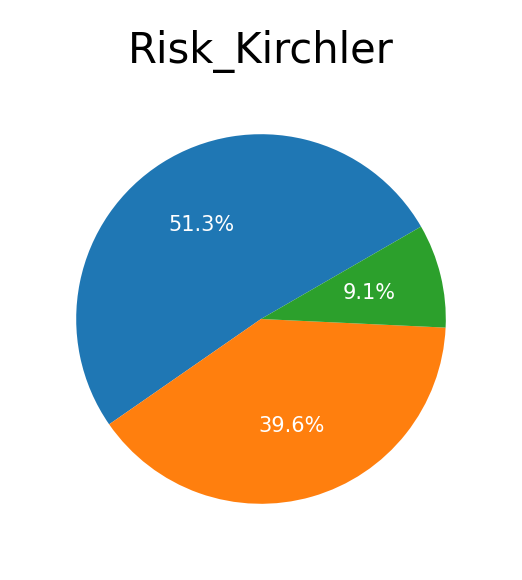

Risk_Guisty
1.0    1808
0.5    1326
0.0     315
Name: count, dtype: int64


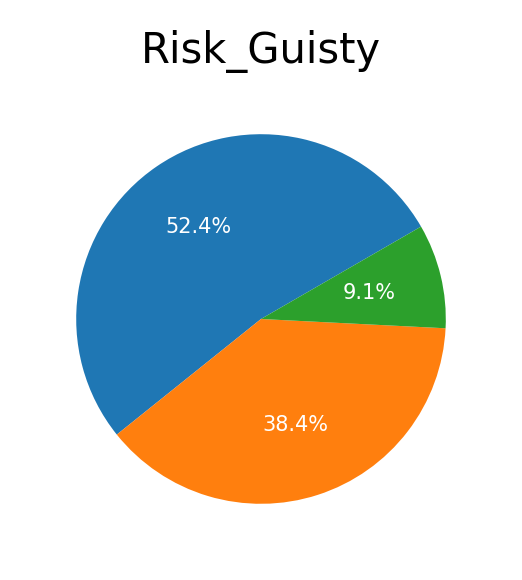

Risk_Smith
1.0    2768
0.0     482
0.5     199
Name: count, dtype: int64


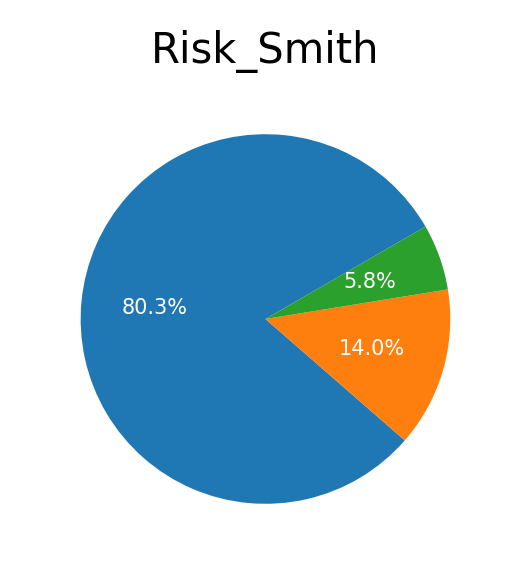



KIRCHLER

session with highest number of max risk
                      session  Risk_Kirchler  count
3  02-07-2024_16.30 (pre LSL)            1.0    145

ssession with highest number of min risk
       session  Risk_Kirchler  count
22  13_11_2024            0.0     35

ssession with highest number of medium risk
             session  Risk_Kirchler  count
54  28-08-2024_15.15            0.5    152


GIUSTY

session with highest number of max risk
                      session  Risk_Guisty  count
33  20-08-2024_13.45(no fMRI)          1.0    142

ssession with highest number of min risk
       session  Risk_Guisty  count
22  13_11_2024          0.0     33

ssession with highest number of min risk
                       session  Risk_Guisty  count
60  29-05-2024_15.30 (pre LSL)          0.5    186

\SMITH

session with highest number of max risk
      session  Risk_Smith  count
9  07_11_2024         1.0    207

ssession with highest number of min risk
                       session  Ri

In [25]:
# Plotting a pie for showing the number of decisions which were risky, medium risky and less risky

for col in ["Risk_Kirchler", "Risk_Guisty", "Risk_Smith"]:
    counts = df_decision_FV[col].value_counts()
    print(counts)
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=30, textprops={'fontsize': 5, 'color': 'white'})
    ax.set_title(f"{col}", fontsize=10)
    plt.show()
    plt.close()

# Printing for every risk categories the sessions with the highest number of min, medium and high risk decisiosn

risk_session_Kirchler = df_decision_FV.groupby("session")["Risk_Kirchler"]
risk_se = risk_session_Kirchler.value_counts().reset_index().sort_values("count", ascending = True)
print("\n\nKIRCHLER")
print("\nsession with highest number of max risk")
print(risk_se[risk_se["Risk_Kirchler"] == 1].tail(1))
print("\nssession with highest number of min risk")
print(risk_se[risk_se["Risk_Kirchler"] == 0].tail(1))
print("\nssession with highest number of medium risk")
print(risk_se[risk_se["Risk_Kirchler"] == 0.5].tail(1))

risk_session_Guisty = df_decision_FV.groupby("session")["Risk_Guisty"]
risk_gu = risk_session_Guisty.value_counts().reset_index().sort_values("count", ascending = True)
print("\n\nGIUSTY")
print("\nsession with highest number of max risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 1].tail(1) )
print("\nssession with highest number of min risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 0].tail(1))
print("\nssession with highest number of min risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 0.5].tail(1))

risk_session_Smith = df_decision_FV.groupby("session")["Risk_Smith"]
risk_gu = risk_session_Smith.value_counts().reset_index().sort_values("count", ascending = True)
print("\n\SMITH")
print("\nsession with highest number of max risk")
print(risk_gu[risk_gu["Risk_Smith"] == 1].tail(1) )
print("\nssession with highest number of min risk")
print(risk_gu[risk_gu["Risk_Smith"] == 0].tail(1))
print("\nssession with highest number of min risk")
print(risk_gu[risk_gu["Risk_Smith"] == 0.5].tail(1))


#Same thing with participant (Showing the participants with the highest, lowest, medium risk)

risk_session_Kirchler = df_decision_FV.groupby("participant")["Risk_Kirchler"]
risk_se = risk_session_Kirchler.value_counts().reset_index().sort_values("count", ascending = True)
print("\participant with highest number of max risk")
print(risk_se[risk_se["Risk_Kirchler"] == 1].tail(1))
print("\participant with highest number of min risk")
print(risk_se[risk_se["Risk_Kirchler"] == 0].tail(1))
print("\participant with highest number of min risk")
print(risk_se[risk_se["Risk_Kirchler"] == 0.5].tail(1))

risk_session_Guisty = df_decision_FV.groupby("participant")["Risk_Guisty"]
risk_gu = risk_session_Guisty.value_counts().reset_index().sort_values("count", ascending = True)
print("\n\nGIUSTY")
print("\participant with highest number of max risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 1].tail(1) )
print("\participant with highest number of min risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 0].tail(1))
print("\participant with highest number of min risk")
print(risk_gu[risk_gu["Risk_Guisty"] == 0.5].tail(1))

risk_session_Smith = df_decision_FV.groupby("participant")["Risk_Smith"]
risk_gu = risk_session_Smith.value_counts().reset_index().sort_values("count", ascending = True)
print("\n\nGIUSTY")
print("\participant with highest number of max risk")
print(risk_gu[risk_gu["Risk_Smith"] == 1].tail(1) )
print("\nparticipant with highest number of min risk")
print(risk_gu[risk_gu["Risk_Smith"] == 0].tail(1))
print("\nparticipant with highest number of min risk")
print(risk_gu[risk_gu["Risk_Smith"] == 0.5].tail(1))

In [26]:
## risk and gender

df_demographics_decision = df_decision_FV.copy()

#Who is more risky (men or women)

for col in ["Risk_Kirchler", "Risk_Guisty", "Risk_Smith"]:
    print("\n\n",col)
    df_demographics_decision[col] = pd.to_numeric(df_demographics_decision[col], errors="coerce")
    avg_risk = df_demographics_decision.groupby("gender")[col].mean()           #groupby gender
    print(avg_risk)
    
    #create plot
    avg_risk.plot(kind="bar", color=["skyblue", "salmon"])
    plt.ylabel(f"Average Risk ([{col}])")
    plt.title("Average Risk by Gender")
    plt.xticks(rotation=0)
    #plt.show()
    plt.close()

    #test
    men = df_demographics_decision[df_demographics_decision["gender"] == "Male"][col]
    women = df_demographics_decision[df_demographics_decision["gender"] == "Female"][col].dropna()

    from scipy.stats import ttest_ind

    t, p = ttest_ind(men, women, equal_var=False)
    print(f"t = {t:.3f}, p = {p:.4f}")



 Risk_Kirchler
gender
Female    0.721285
Male      0.705535
Name: Risk_Kirchler, dtype: float64
t = -1.401, p = 0.1614


 Risk_Guisty
gender
Female    0.727711
Male      0.710073
Name: Risk_Guisty, dtype: float64
t = -1.558, p = 0.1194


 Risk_Smith
gender
Female    0.854217
Male      0.818512
Name: Risk_Smith, dtype: float64
t = -2.887, p = 0.0039


In [27]:
CATS = [0, 0.5, 1]  # explicit order

def _counts_per_session(df, col):
    # Count categoreis, keep order {0, 0.5, 1}
    dfx = df.copy()
    dfx[col] = pd.to_numeric(dfx[col], errors="coerce").round(2)
    dfx = dfx[dfx[col].isin(CATS)]

    counts = (
        dfx.groupby(["session", col])
           .size()
           .unstack(fill_value=0)
           .reindex(columns=CATS, fill_value=0)  # enforce order
           .sort_index()
    )
    return counts


def plot_heatmap_categorization_clear(df, col, title, path, cmap="viridis"):
    """
    Creates a clean and readable heatmap for categorization counts per session.
    """
    counts = _counts_per_session(df, col)
    if counts.empty:
        raise ValueError(f"No valid values in '{col}'. Expected one of {CATS}.")

    data = counts.values
    cats = list(counts.columns)
    sessions = counts.index.astype(str).tolist()

    n_rows, n_cols = data.shape

    # dynamic figure height
    fig_height = max(4, 0.35 * len(sessions))
    fig, ax = plt.subplots(figsize=(7, fig_height))

    # use pcolormesh instead of imshow to avoid inner lines between cells
    x = np.arange(n_cols + 1)
    y = np.arange(n_rows + 1)
    im = ax.pcolormesh(
        x,
        y,
        data,
        cmap=cmap,
        shading="flat",
        edgecolors="face",  # same color as face -> no visible borders
        linewidth=0
    )

    # cell annotations (centered in each cell)
    vmax = float(np.max(data)) if data.size else 0.0
    threshold = 0.6 * vmax if vmax > 0 else 0  # kept for potential adaptive color
    for i in range(n_rows):
        for j in range(n_cols):
            val = int(data[i, j])
            color = "white"
            ax.text(
                j + 0.5,
                i + 0.5,
                val,
                ha="center",
                va="center",
                fontsize=9,
                color=color,
            )

    # invert y-axis so first session is at the top
    ax.set_xlim(0, n_cols)
    ax.set_ylim(n_rows, 0)

    # ticks at cell centers
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels([str(c) for c in cats], fontsize=10, fontweight="bold")

    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels(sessions, fontsize=9)

    ax.set_xlabel("Category", fontsize=11, labelpad=6)
    ax.set_ylabel("Session", fontsize=11, labelpad=6)
    if title:
        ax.set_title(title, fontsize=13, fontweight="bold", pad=10)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel("Number of Observations", fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # no minor ticks, no additional grid, no frame
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    # plt.show()
    print(f"✅ Saved: {path}")
    plt.close()


path_heatmap_kirchler = os.path.join(VISUALIZATION, "heatmap_kirchler_categorization_bubble.png")
path_heatmap_guisty   = os.path.join(VISUALIZATION, "heatmap_guisty_categorization_bubble.png")
path_heatmap_smith    = os.path.join(VISUALIZATION, "heatmap_smith_categorization_bubble.png")

# calls
plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Kirchler",
    title="Kirchler – Categorization (Counts per Session)",
    path=path_heatmap_kirchler
)

plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Guisty",
    title="Guisty – Categorization (Counts per Session)",
    path=path_heatmap_guisty
)

plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Smith",
    title="Smith – Categorization (Counts per Session)",
    path=path_heatmap_smith
)


✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_kirchler_categorization_bubble.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_guisty_categorization_bubble.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_smith_categorization_bubble.png


In [28]:
CATS = [0, 0.5, 1]   # explicit order

def plot_heatmap_categorization_clear(
    df, col, title, path,
    cmap="viridis",
    normalize=True,     # True -> each session as proportion (row sums = 100)
    annot="percent"     # "percent" | "count" | "both"
):
    """
    Plot a heatmap of category proportions (or counts) per session.
    """
    counts = _counts_per_session(df, col)
    if counts.empty:
        raise ValueError(f"No valid values in '{col}'. Expected {CATS}.")

    # Row-normalized percentages per session
    row_sums = counts.sum(axis=1).replace(0, np.nan)
    perc = (counts.div(row_sums, axis=0) * 100).fillna(0)

    data = perc.values if normalize else counts.values
    cats = list(counts.columns)
    sessions = counts.index.astype(str).tolist()

    n_rows, n_cols = data.shape

    # dynamic figure height
    fig_height = max(4, 0.35 * len(sessions))
    fig, ax = plt.subplots(figsize=(7, fig_height))

    x = np.arange(n_cols + 1)
    y = np.arange(n_rows + 1)
    im = ax.pcolormesh(
        x,
        y,
        data,
        cmap=cmap,
        shading="flat",
        edgecolors="face",  
        linewidth=0
    )

    # threshold for adaptive text color
    vmax = float(np.max(data)) if data.size else 0.0
    threshold = 0.6 * vmax if vmax > 0 else 0

    # cell annotations (centered in each cell)
    for i in range(n_rows):
        for j in range(n_cols):
            val_pct = perc.iloc[i, j]
            val_cnt = counts.iloc[i, j]

            if annot == "percent":
                txt = f"{val_pct:.0f}%"
            elif annot == "count":
                txt = f"{int(val_cnt)}"
            else:  # "both"
                txt = f"{val_pct:.0f}%\n({int(val_cnt)})"

            color = "white"
            ax.text(
                j + 0.5,
                i + 0.5,
                txt,
                ha="center",
                va="center",
                fontsize=9,
                color=color
            )

    # put first session at the top
    ax.set_xlim(0, n_cols)
    ax.set_ylim(n_rows, 0)

    # ticks at cell centers
    ax.set_xticks(np.arange(n_cols) + 0.5)
    ax.set_xticklabels([str(c) for c in cats], fontsize=10, fontweight="bold")

    ax.set_yticks(np.arange(n_rows) + 0.5)
    ax.set_yticklabels(sessions, fontsize=9)

    ax.set_xlabel("Category", fontsize=11, labelpad=6)
    ax.set_ylabel("Session", fontsize=11, labelpad=6)
    if title:
        ax.set_title(title, fontsize=13, fontweight="bold", pad=10)

    # colorbar
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar_label = "Share per Session (%)" if normalize else "Number of Observations"
    cbar.ax.set_ylabel(cbar_label, fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    # no minor ticks, no extra grid, no frame
    ax.set_xticks([], minor=True)
    ax.set_yticks([], minor=True)
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    # plt.show()
    plt.close()
    print(f"✅ Saved: {path}")


saving_path_kirchler = os.path.join(VISUALIZATION, "heamap_RD_Kirchkler_risk_proportion.png")
saving_path_guitsy   = os.path.join(VISUALIZATION, "heamap_RD_Giusty_risk_proportion.png")
saving_path_smith    = os.path.join(VISUALIZATION, "heamap_RD_Smith_risk_proportion.png")

plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Kirchler",
    title="Kirchler – Proportion (with Counts)",
    path=saving_path_kirchler,
    normalize=True, annot="both"
)

plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Guisty",
    title="Guisty – Proportion (with Counts)",
    path=saving_path_guitsy,
    normalize=True, annot="both"
)

plot_heatmap_categorization_clear(
    df_decision_FV, "Risk_Smith",
    title="Smith – Proportion (with Counts)",
    path=saving_path_smith,
    normalize=True, annot="both"
)


✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heamap_RD_Kirchkler_risk_proportion.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heamap_RD_Giusty_risk_proportion.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heamap_RD_Smith_risk_proportion.png


# Volatility

This chapter includes visualizations regarding the volatility measures (such as Volatility by Kaufman and Ederington).

In [29]:
# Create new copy of DataFrame with explicit columns.

df_plot = df[["session", "round", "price", "V_t", "MAD_t", "AMAD_t", "Vol_Classification_intra_session", "Vol_Classification_Global", "change_price", "deviation_max_min", "abs_diff"]].copy().drop_duplicates().sort_values(["session", "round", "price"])

## Volatility by Kaufmann

This part contains only the visualizations of the volatility measure by Kaufmann



✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_02-07-2024_14.15 (pre LSL)_by_Kaufman.png


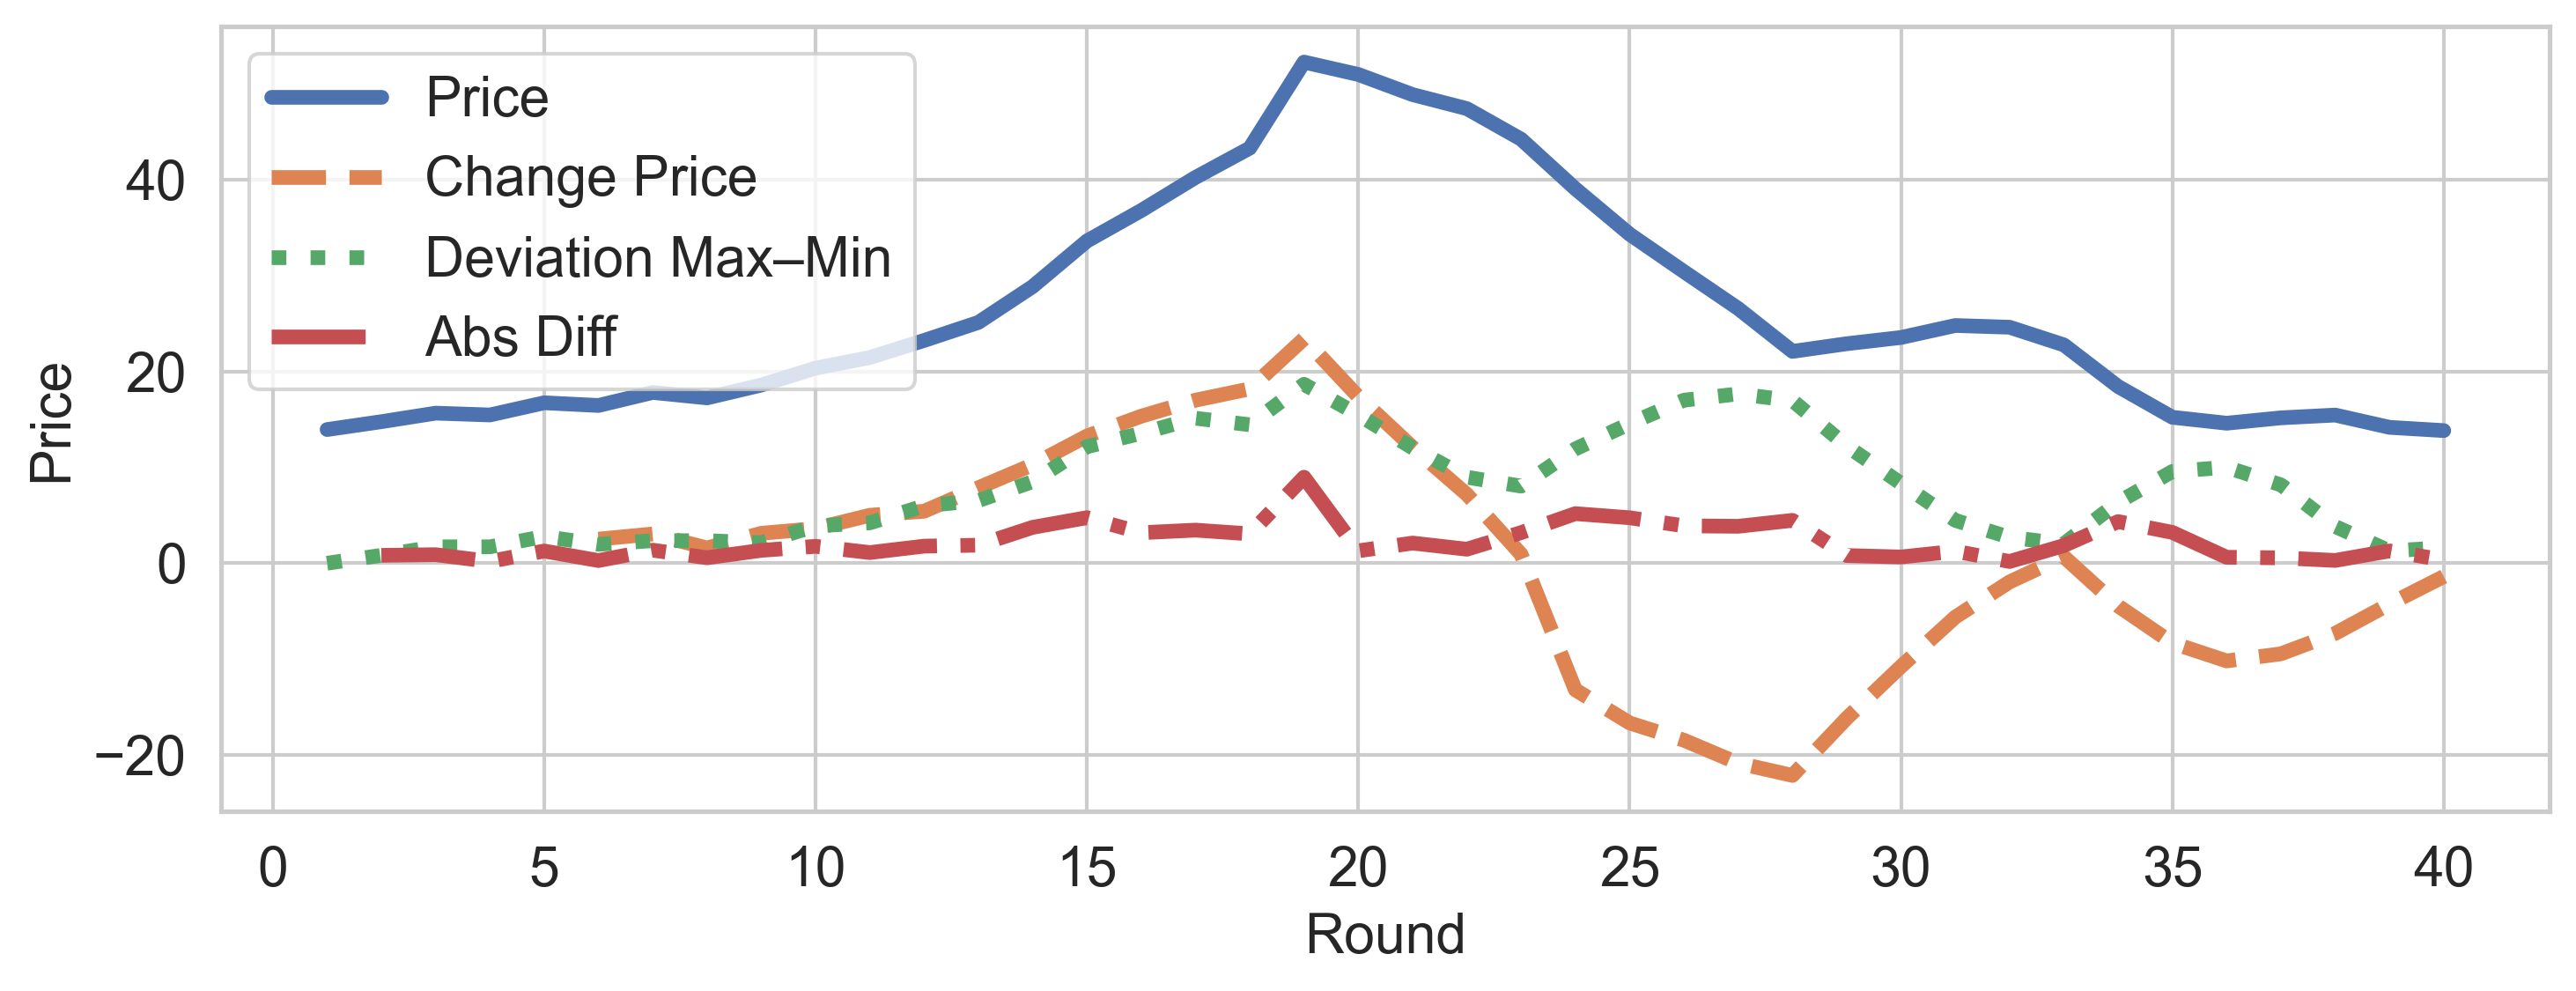

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_02-07-2024_16.30 (pre LSL)_by_Kaufman.png


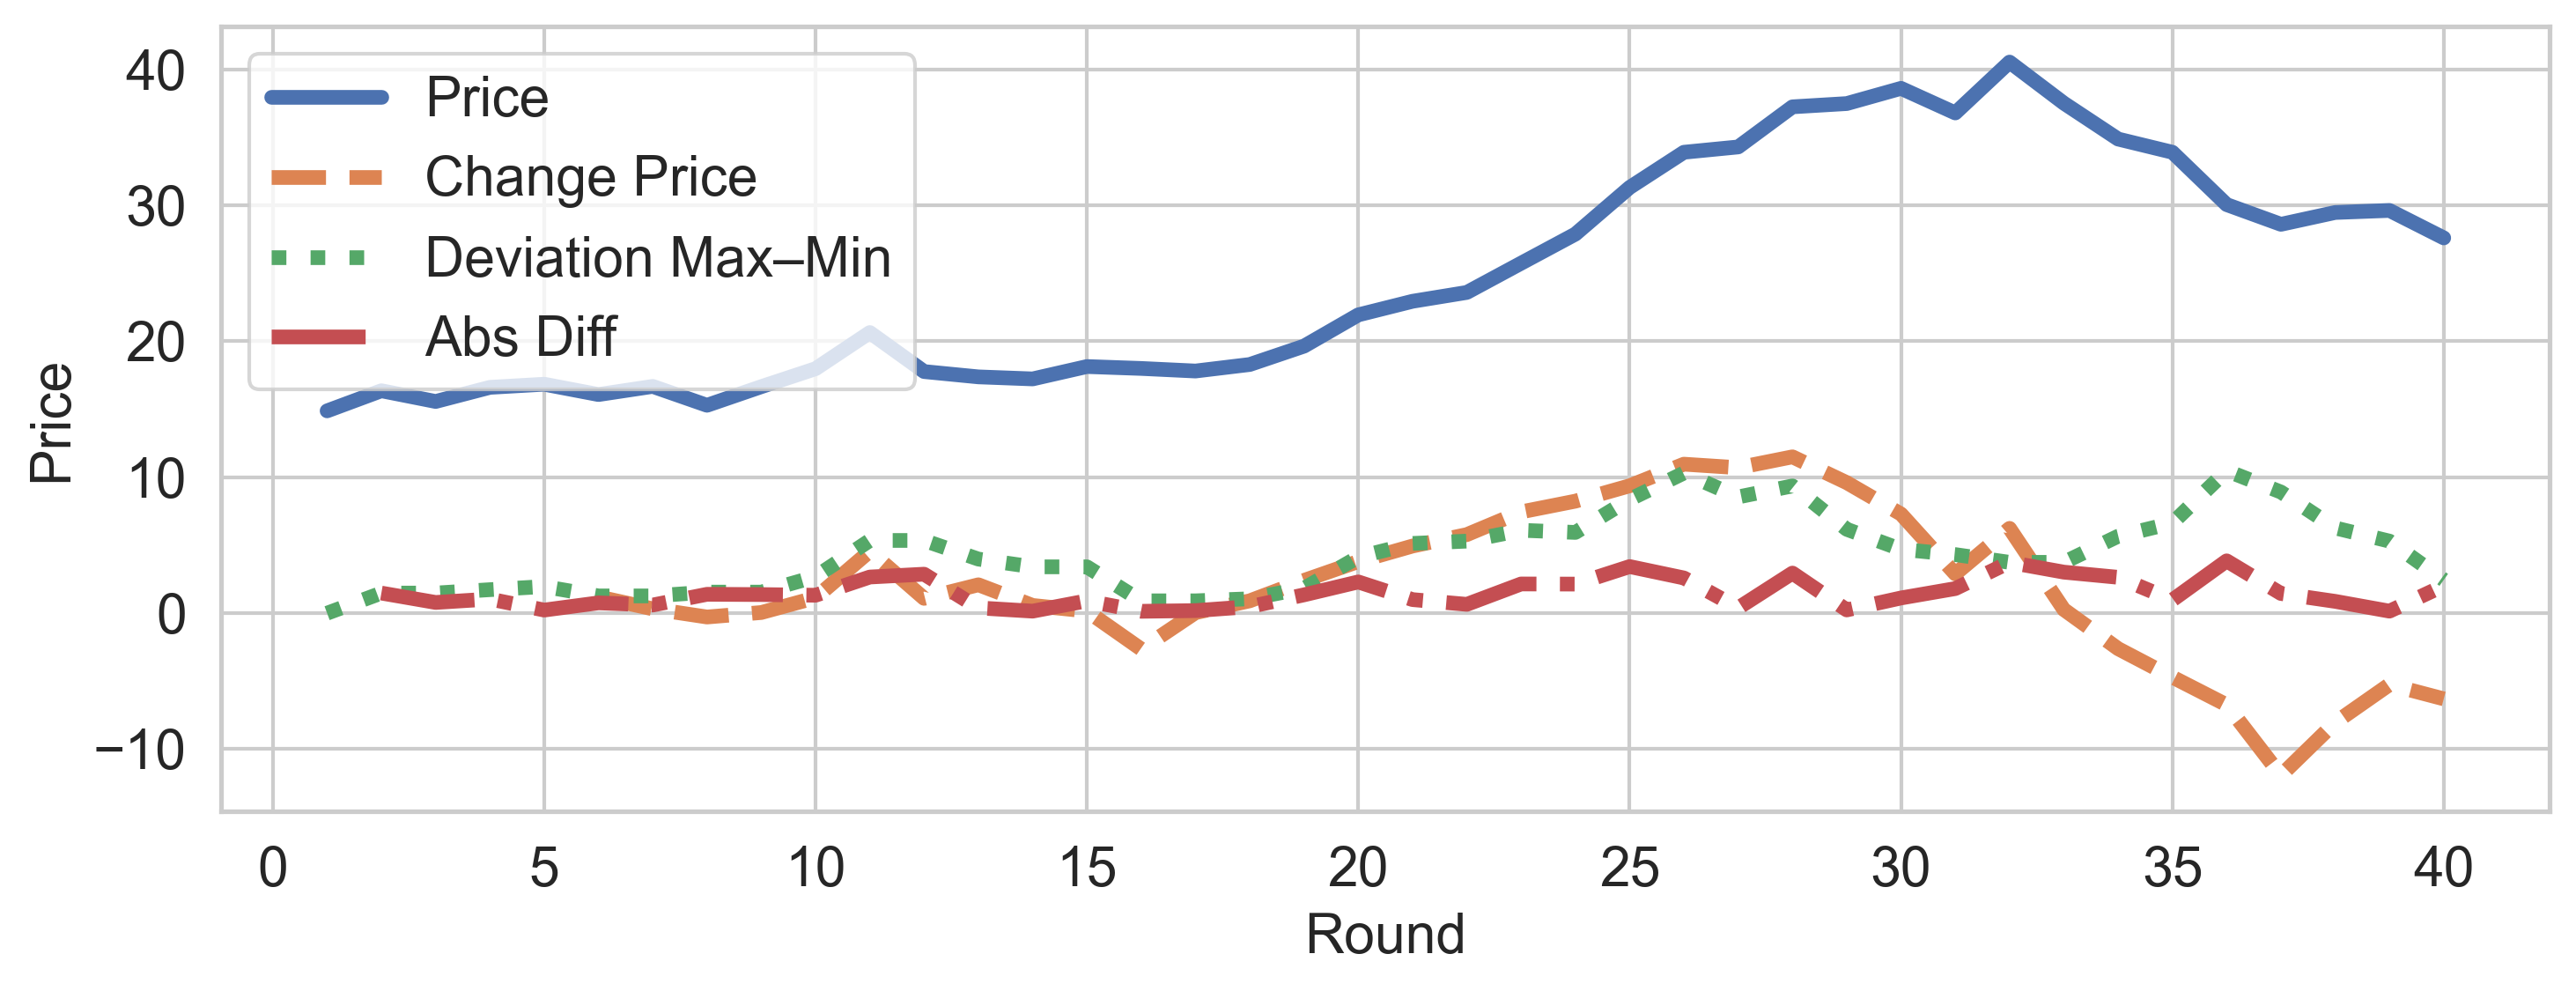

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_03-07-2024_15.15 (pre LSL)_by_Kaufman.png


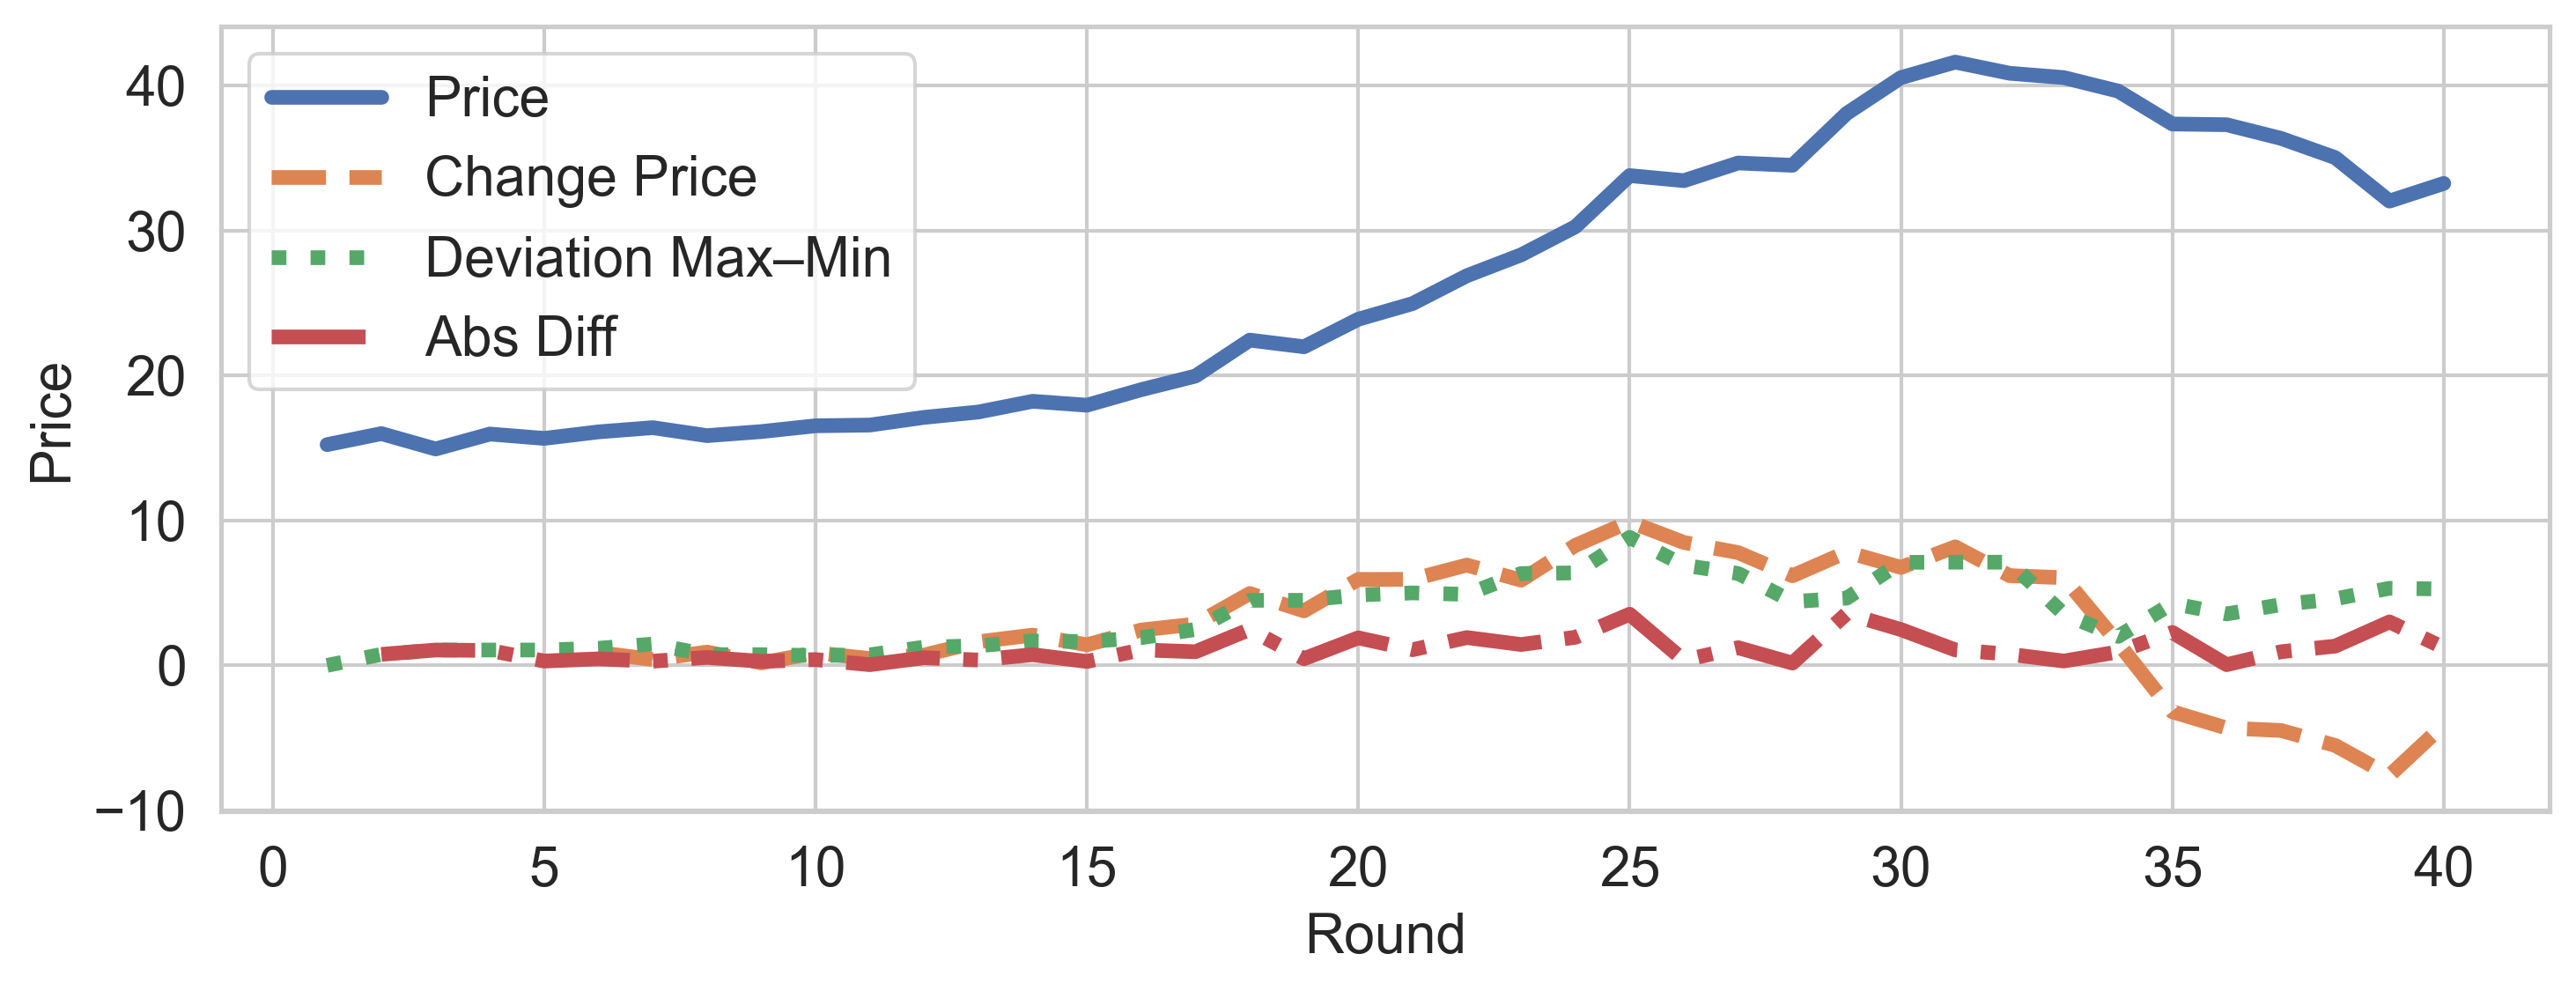

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_06-08-2024_13.15_by_Kaufman.png


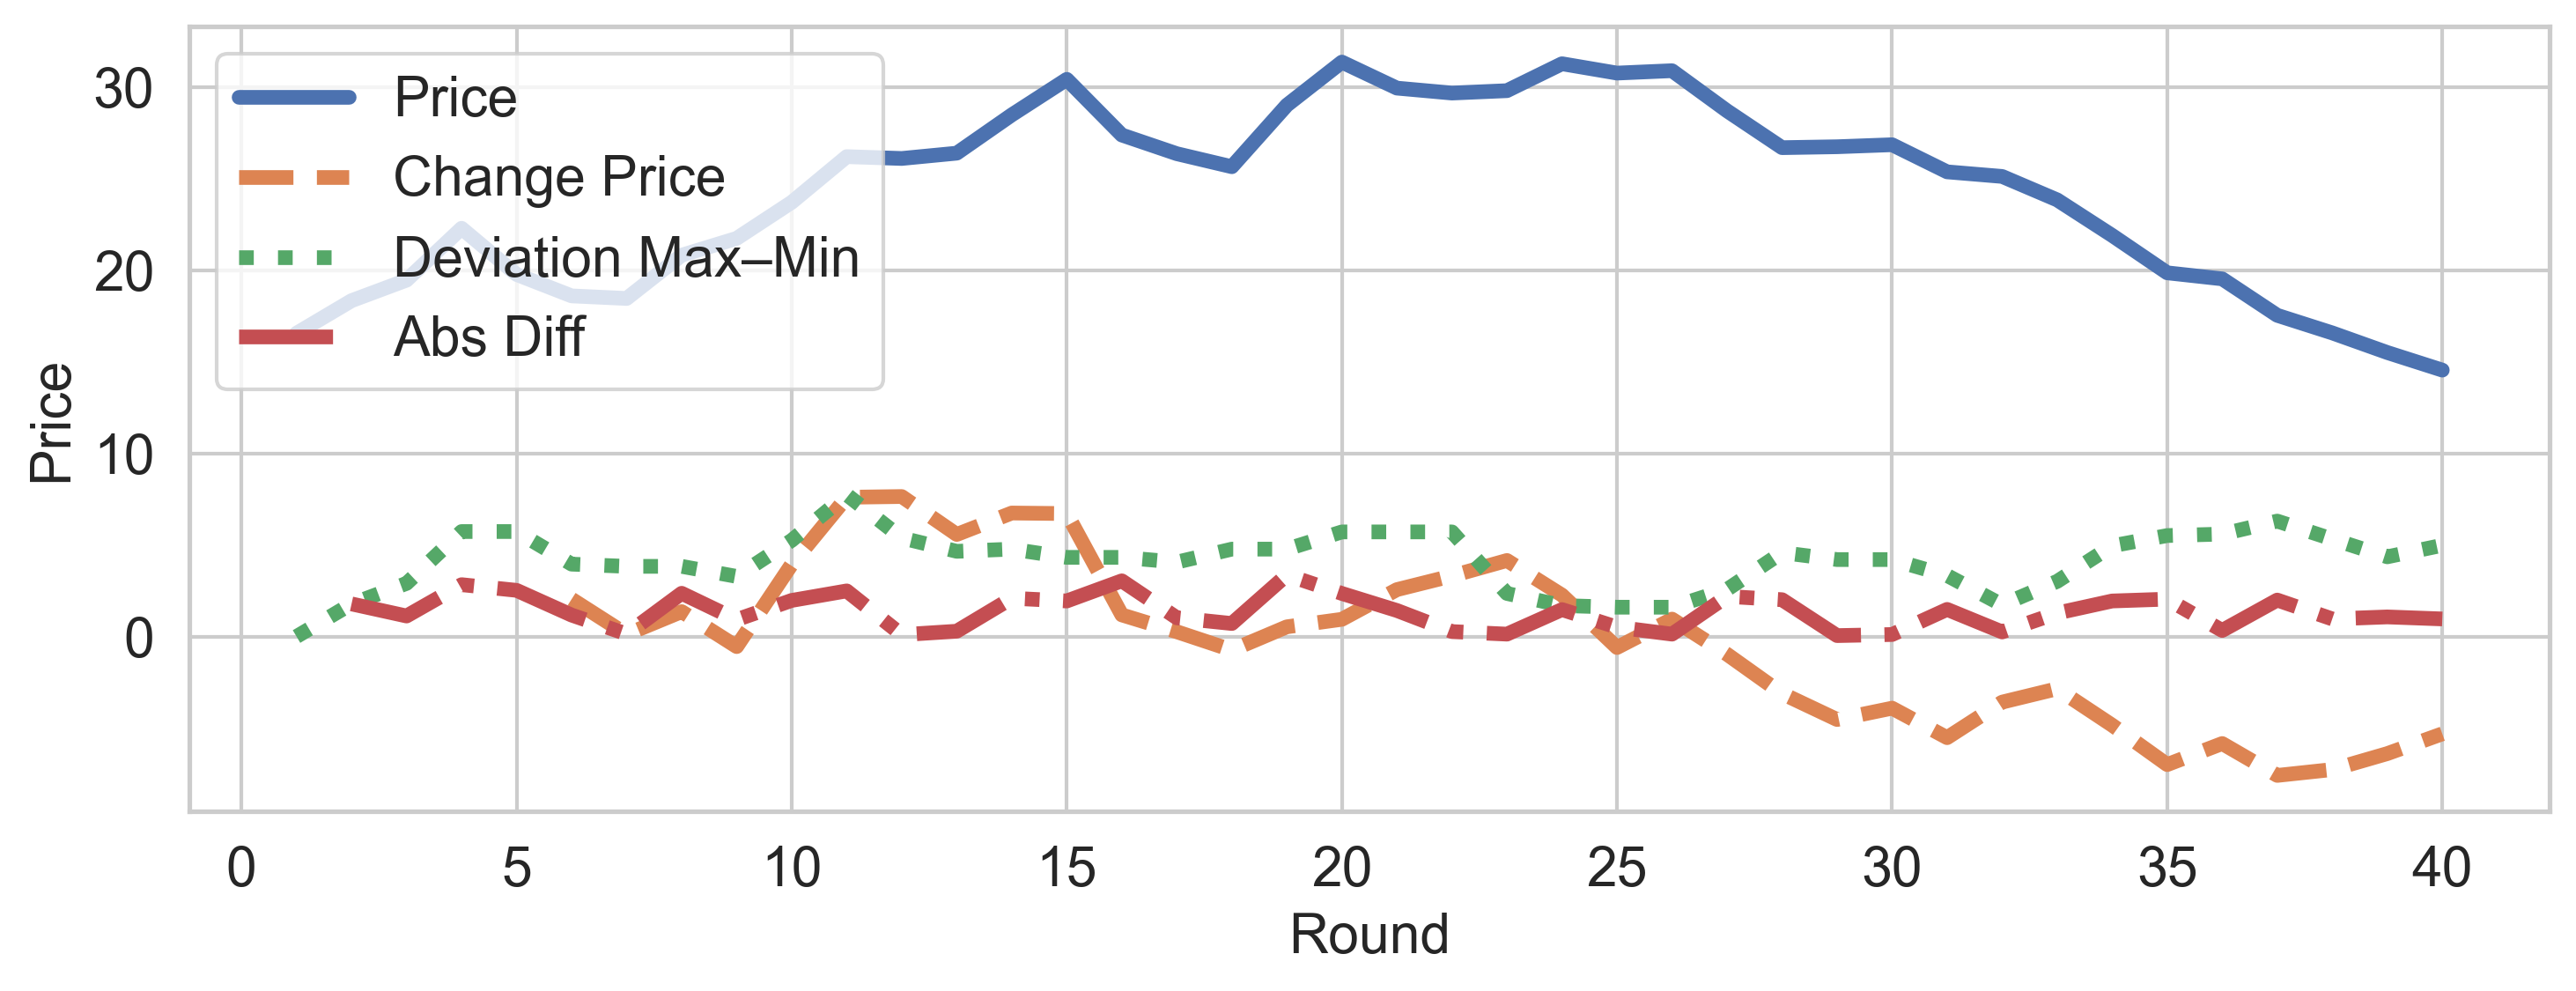

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_07_11_2024_by_Kaufman.png


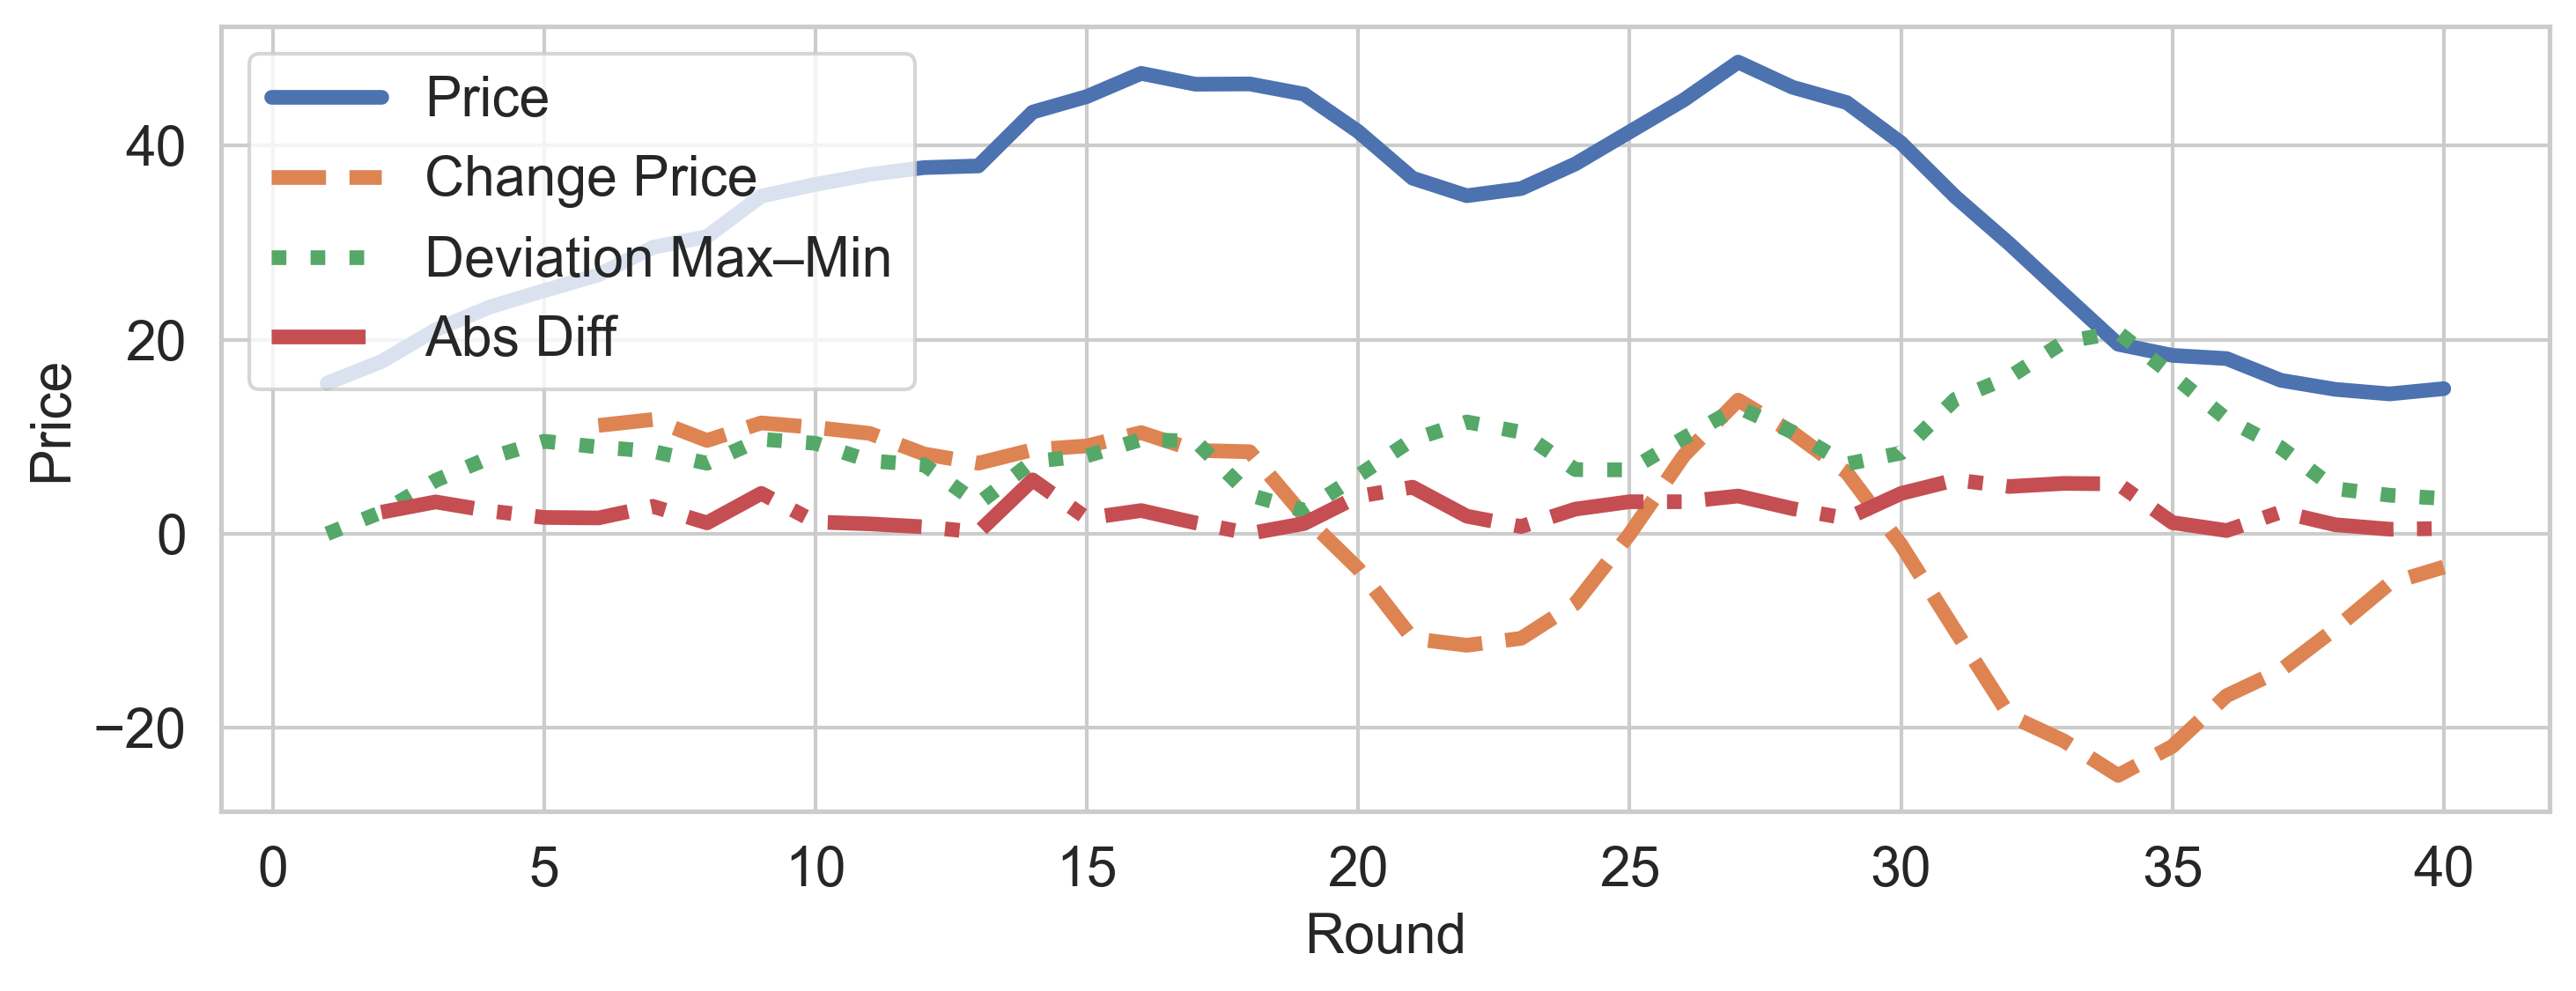

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_12_11_2024_by_Kaufman.png


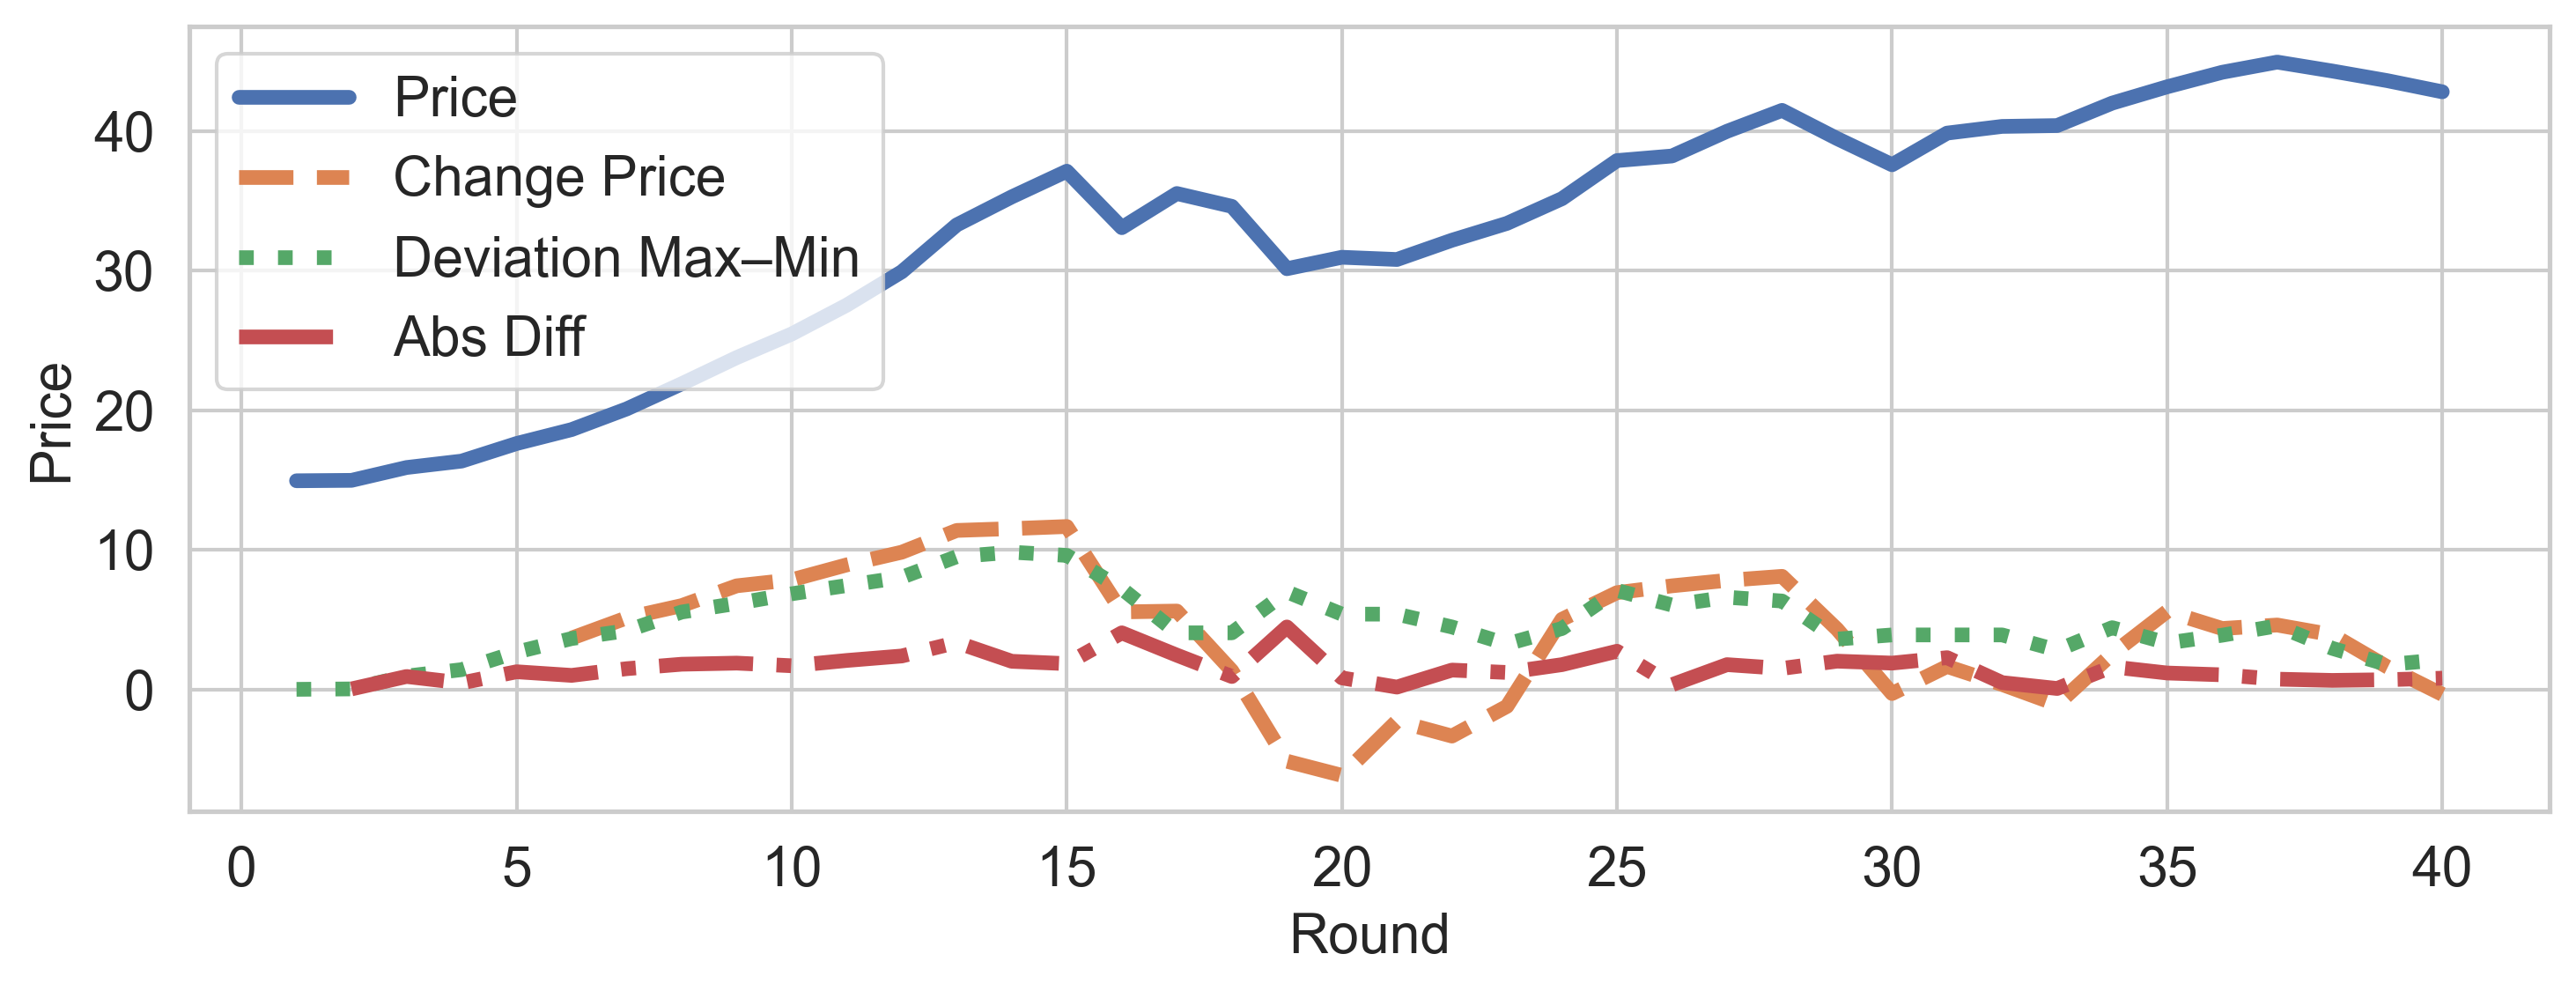

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_13-08-2024_13.45 (No fMRI)_by_Kaufman.png


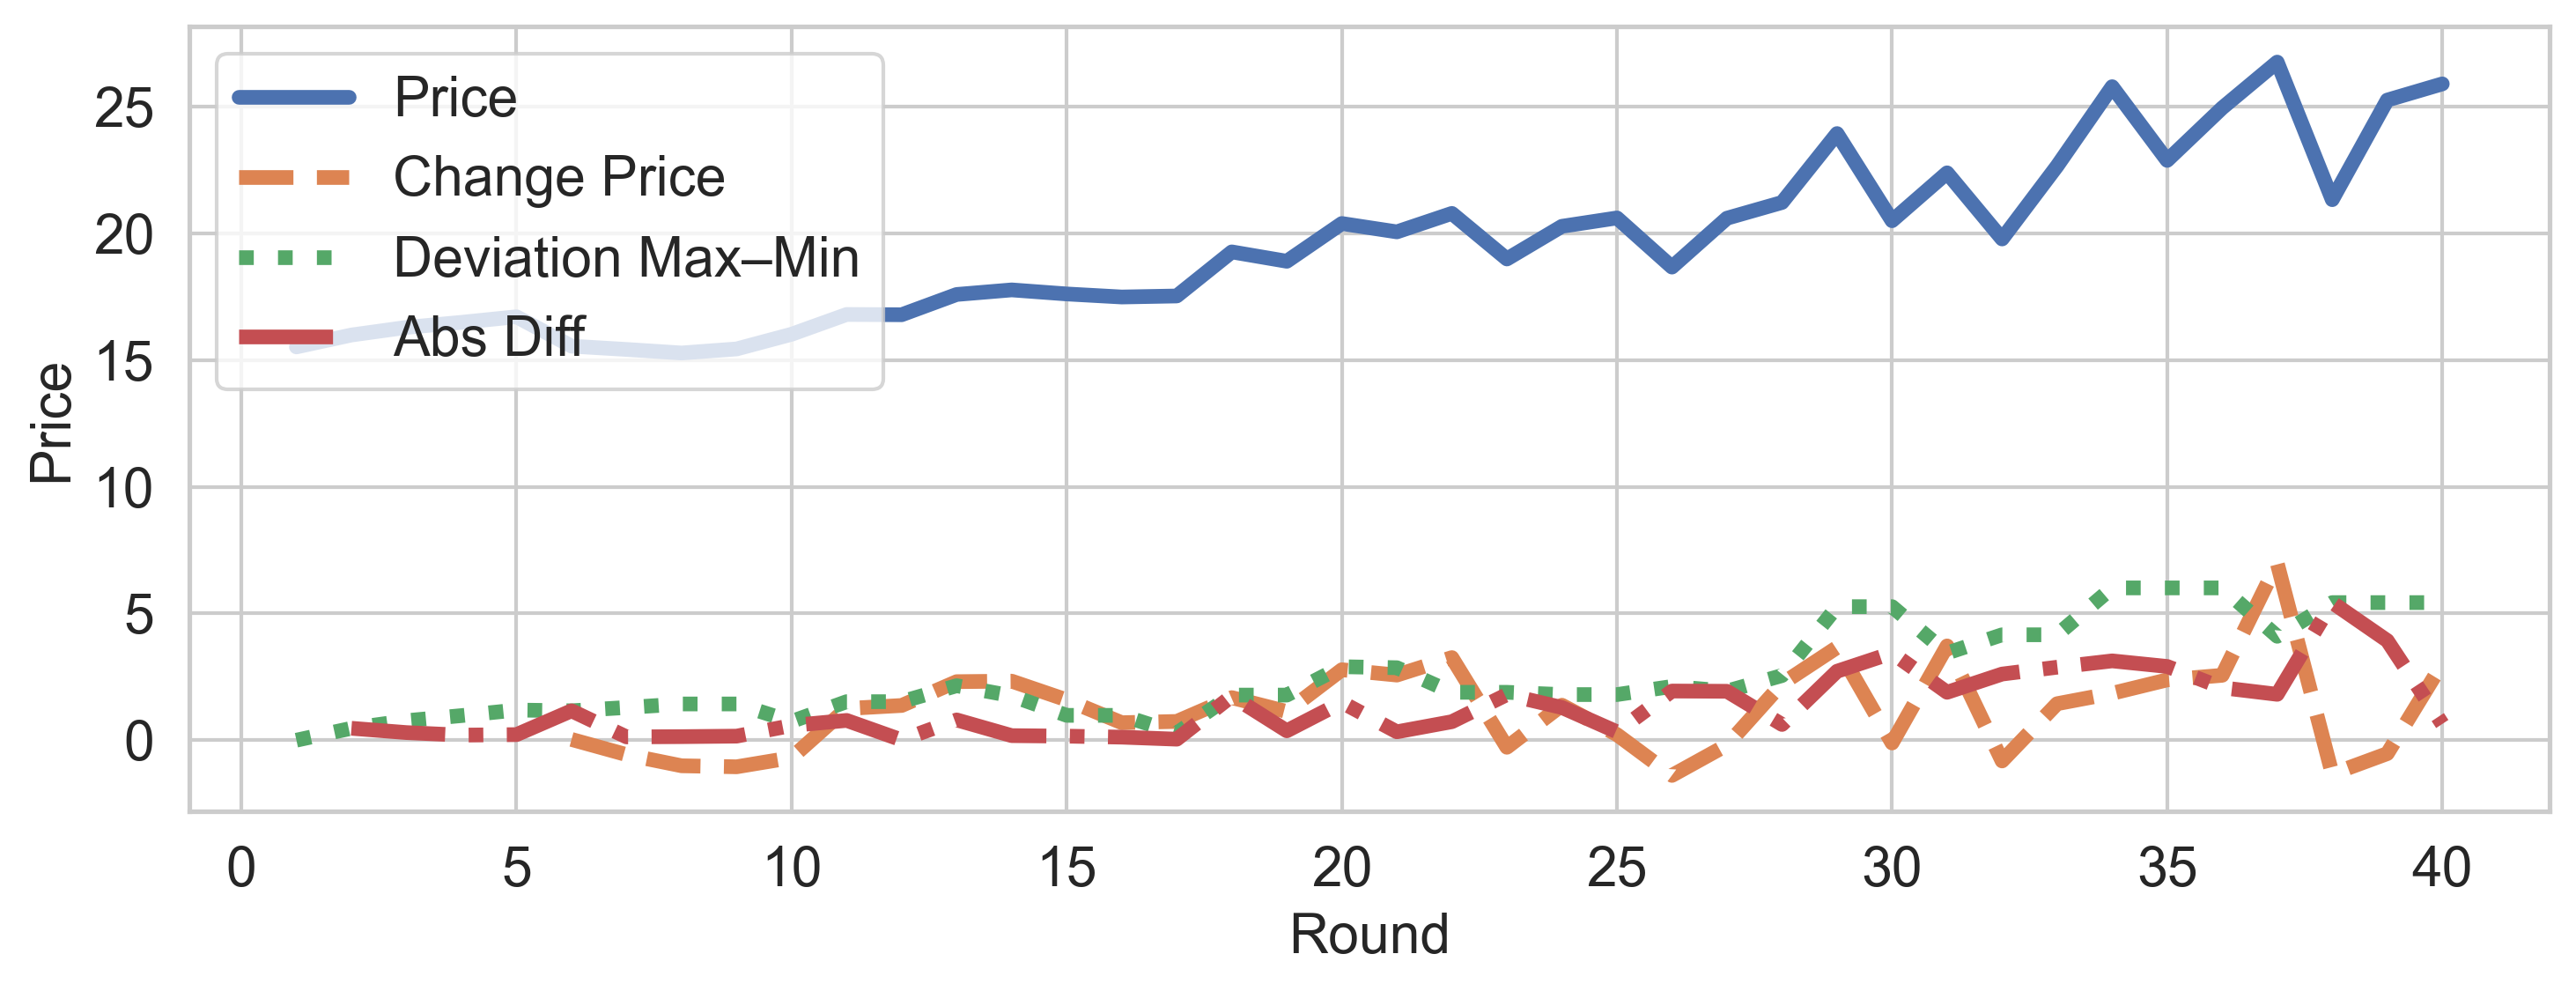

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_13_11_2024_by_Kaufman.png


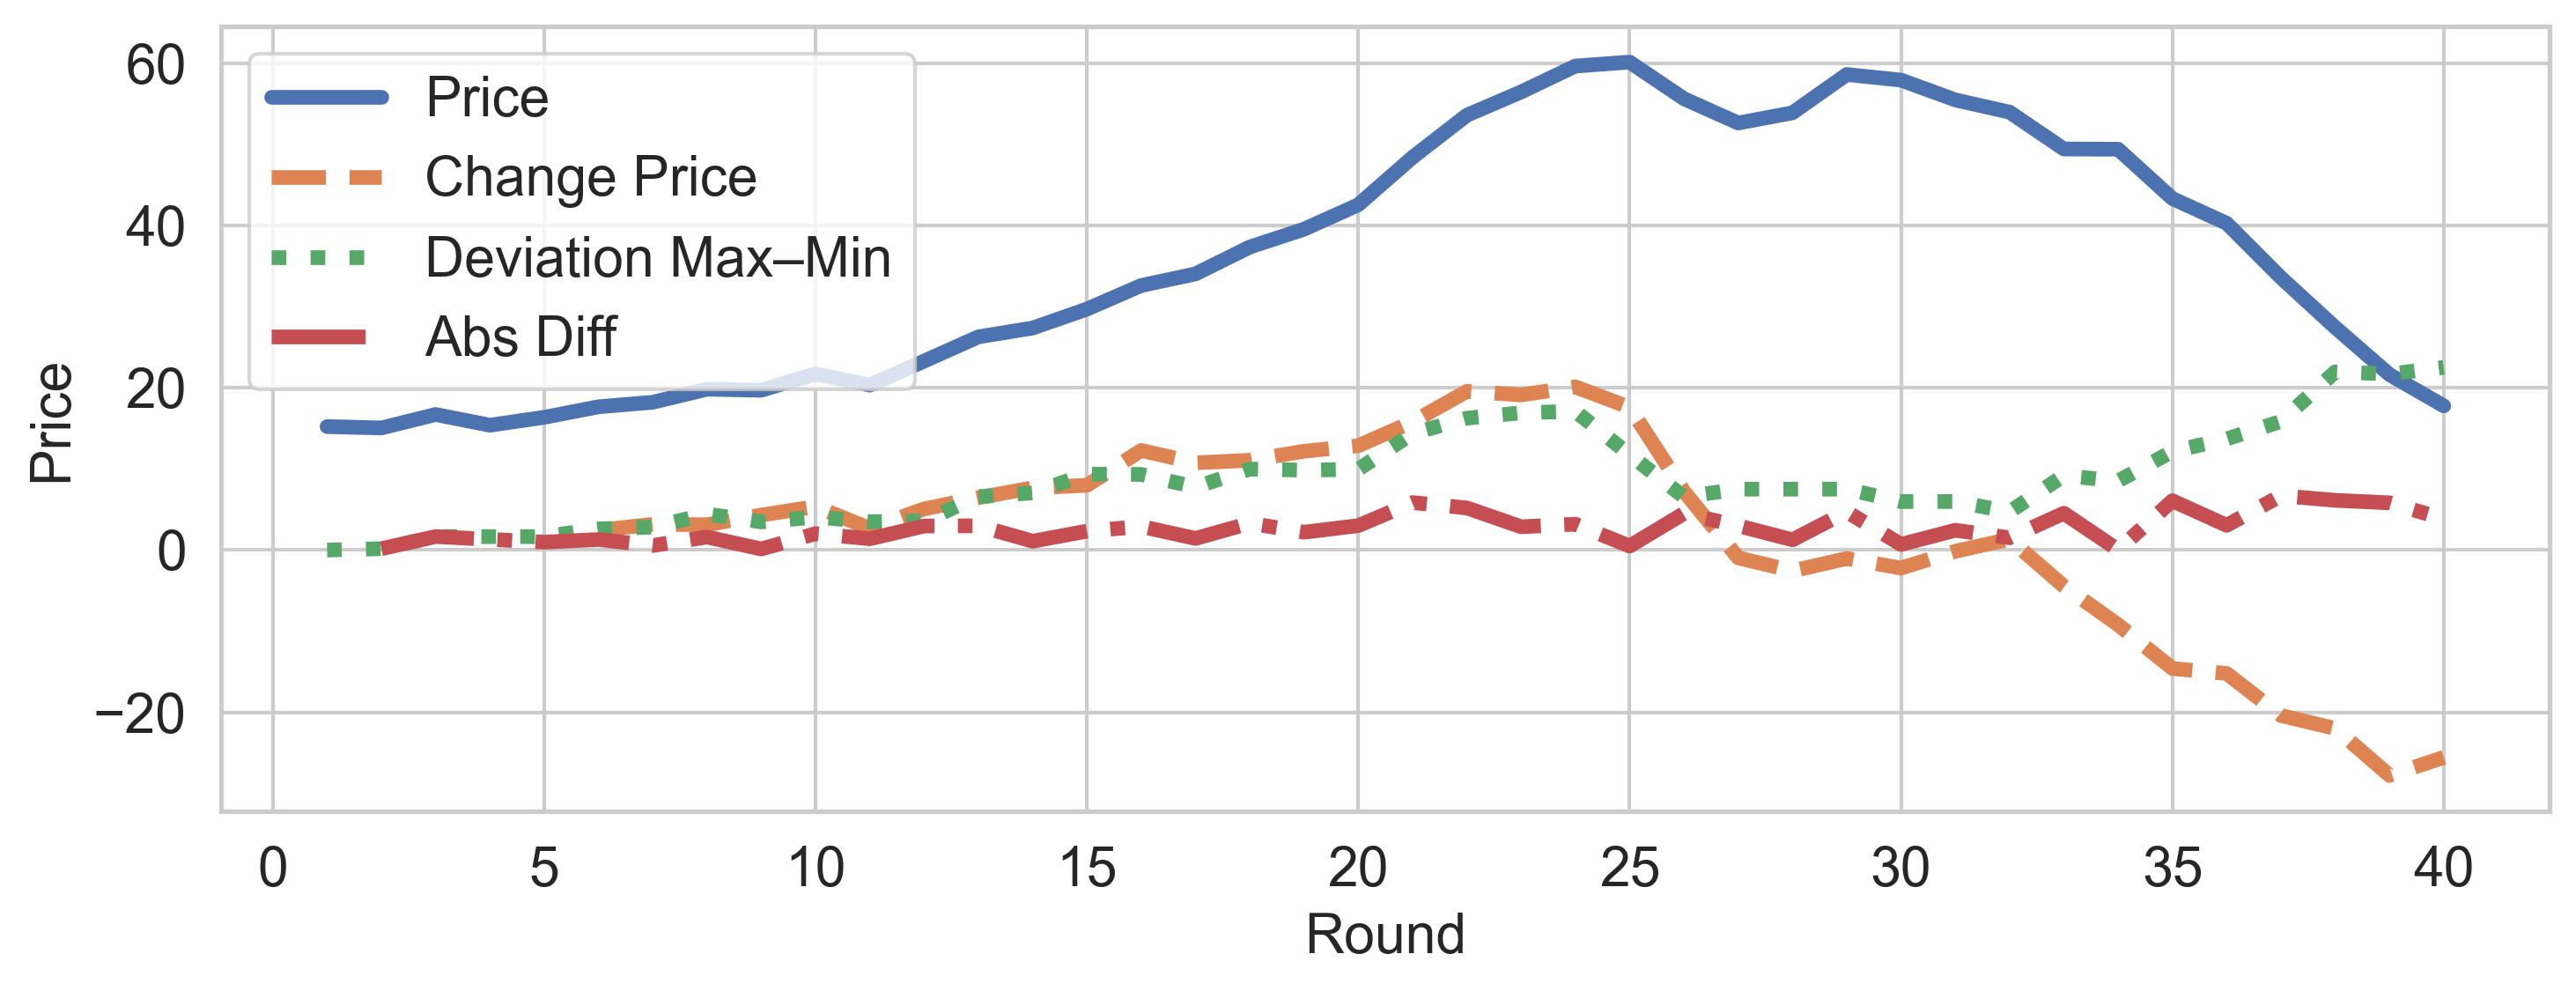

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_14-08-2024_15.15_by_Kaufman.png


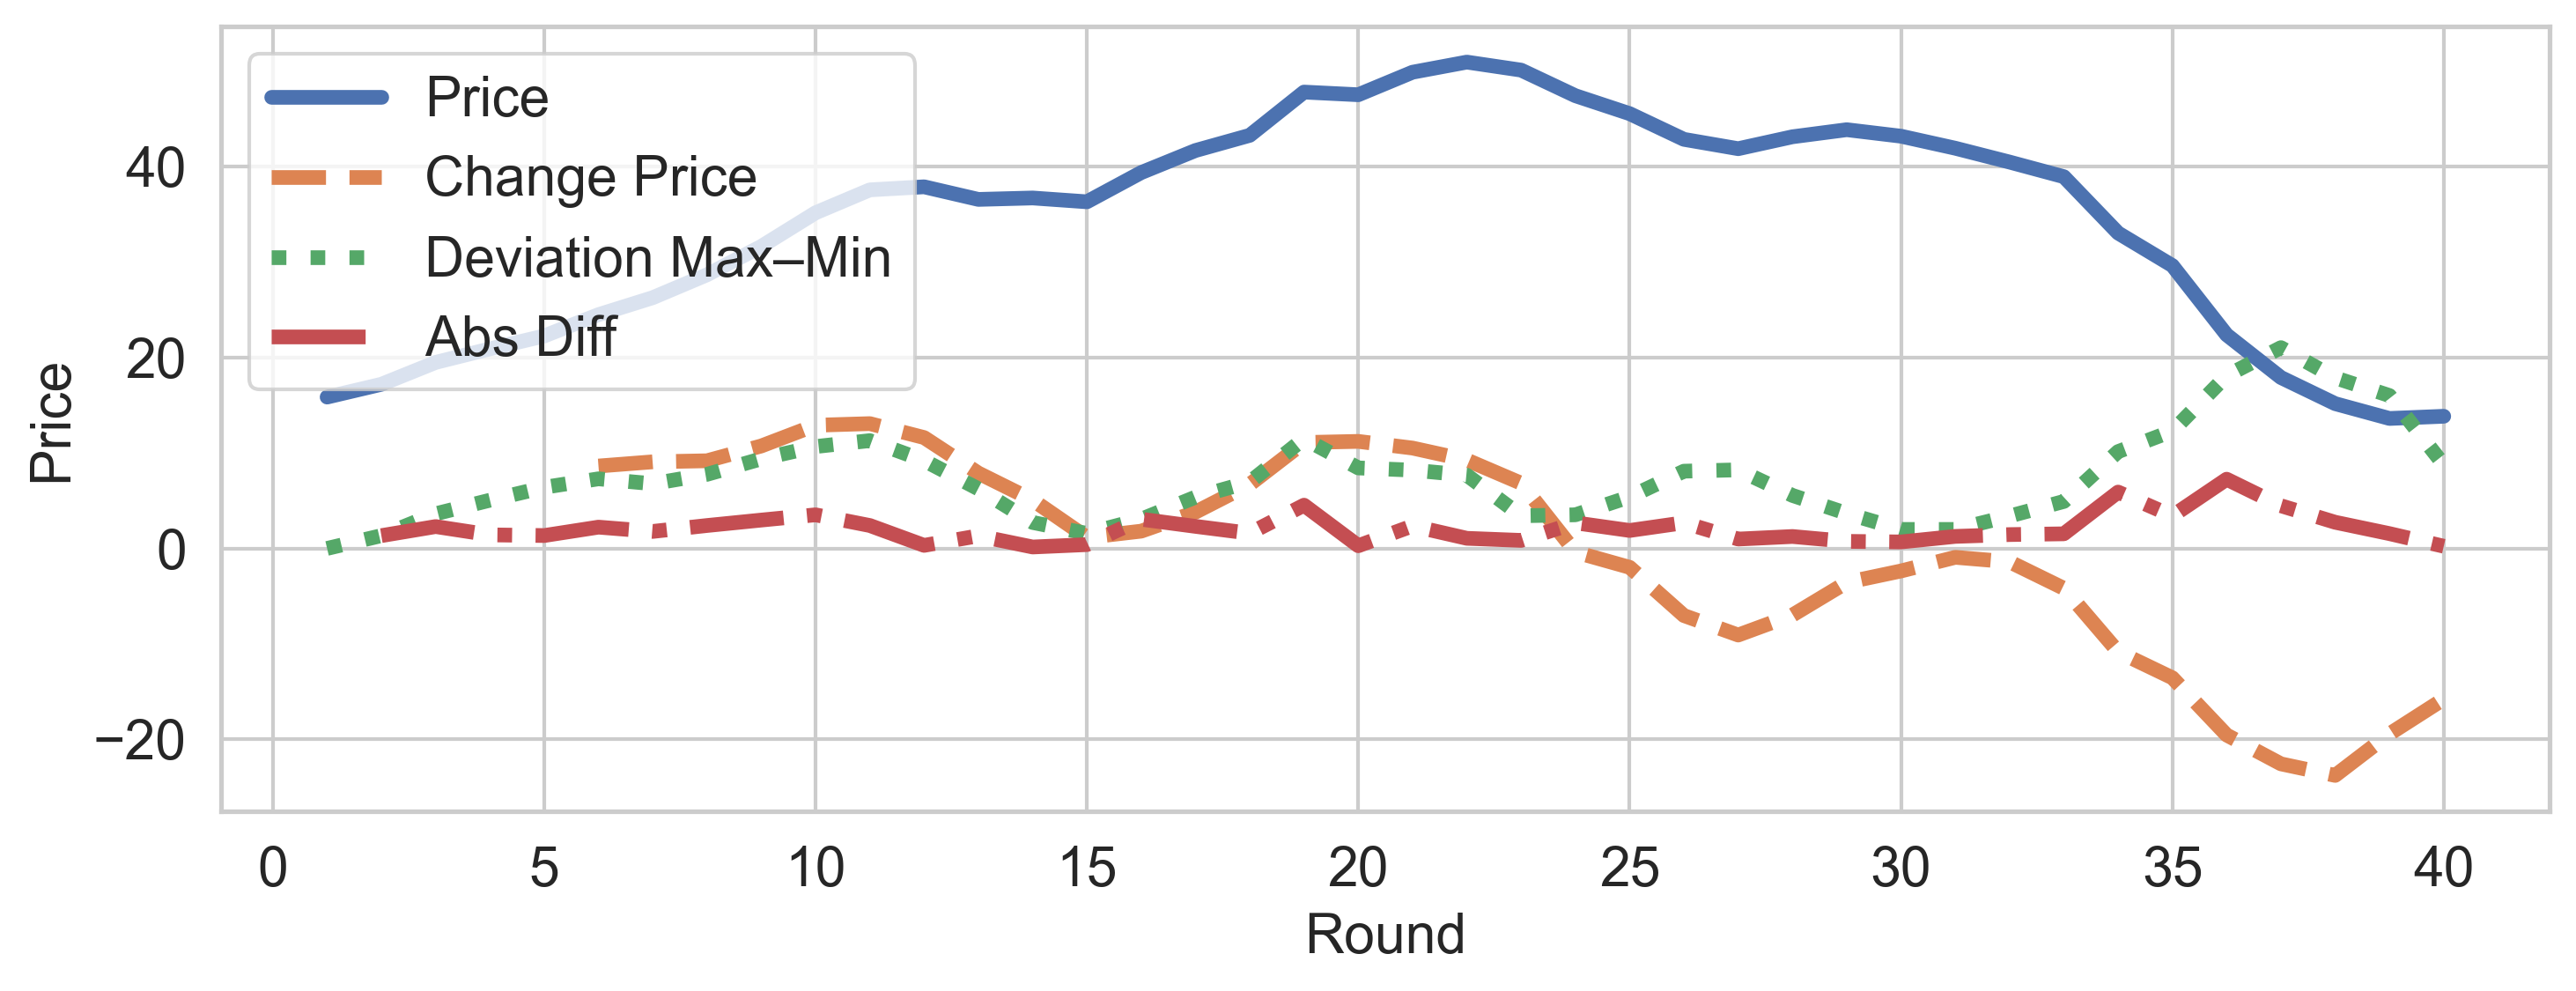

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_14_11_2024_by_Kaufman.png


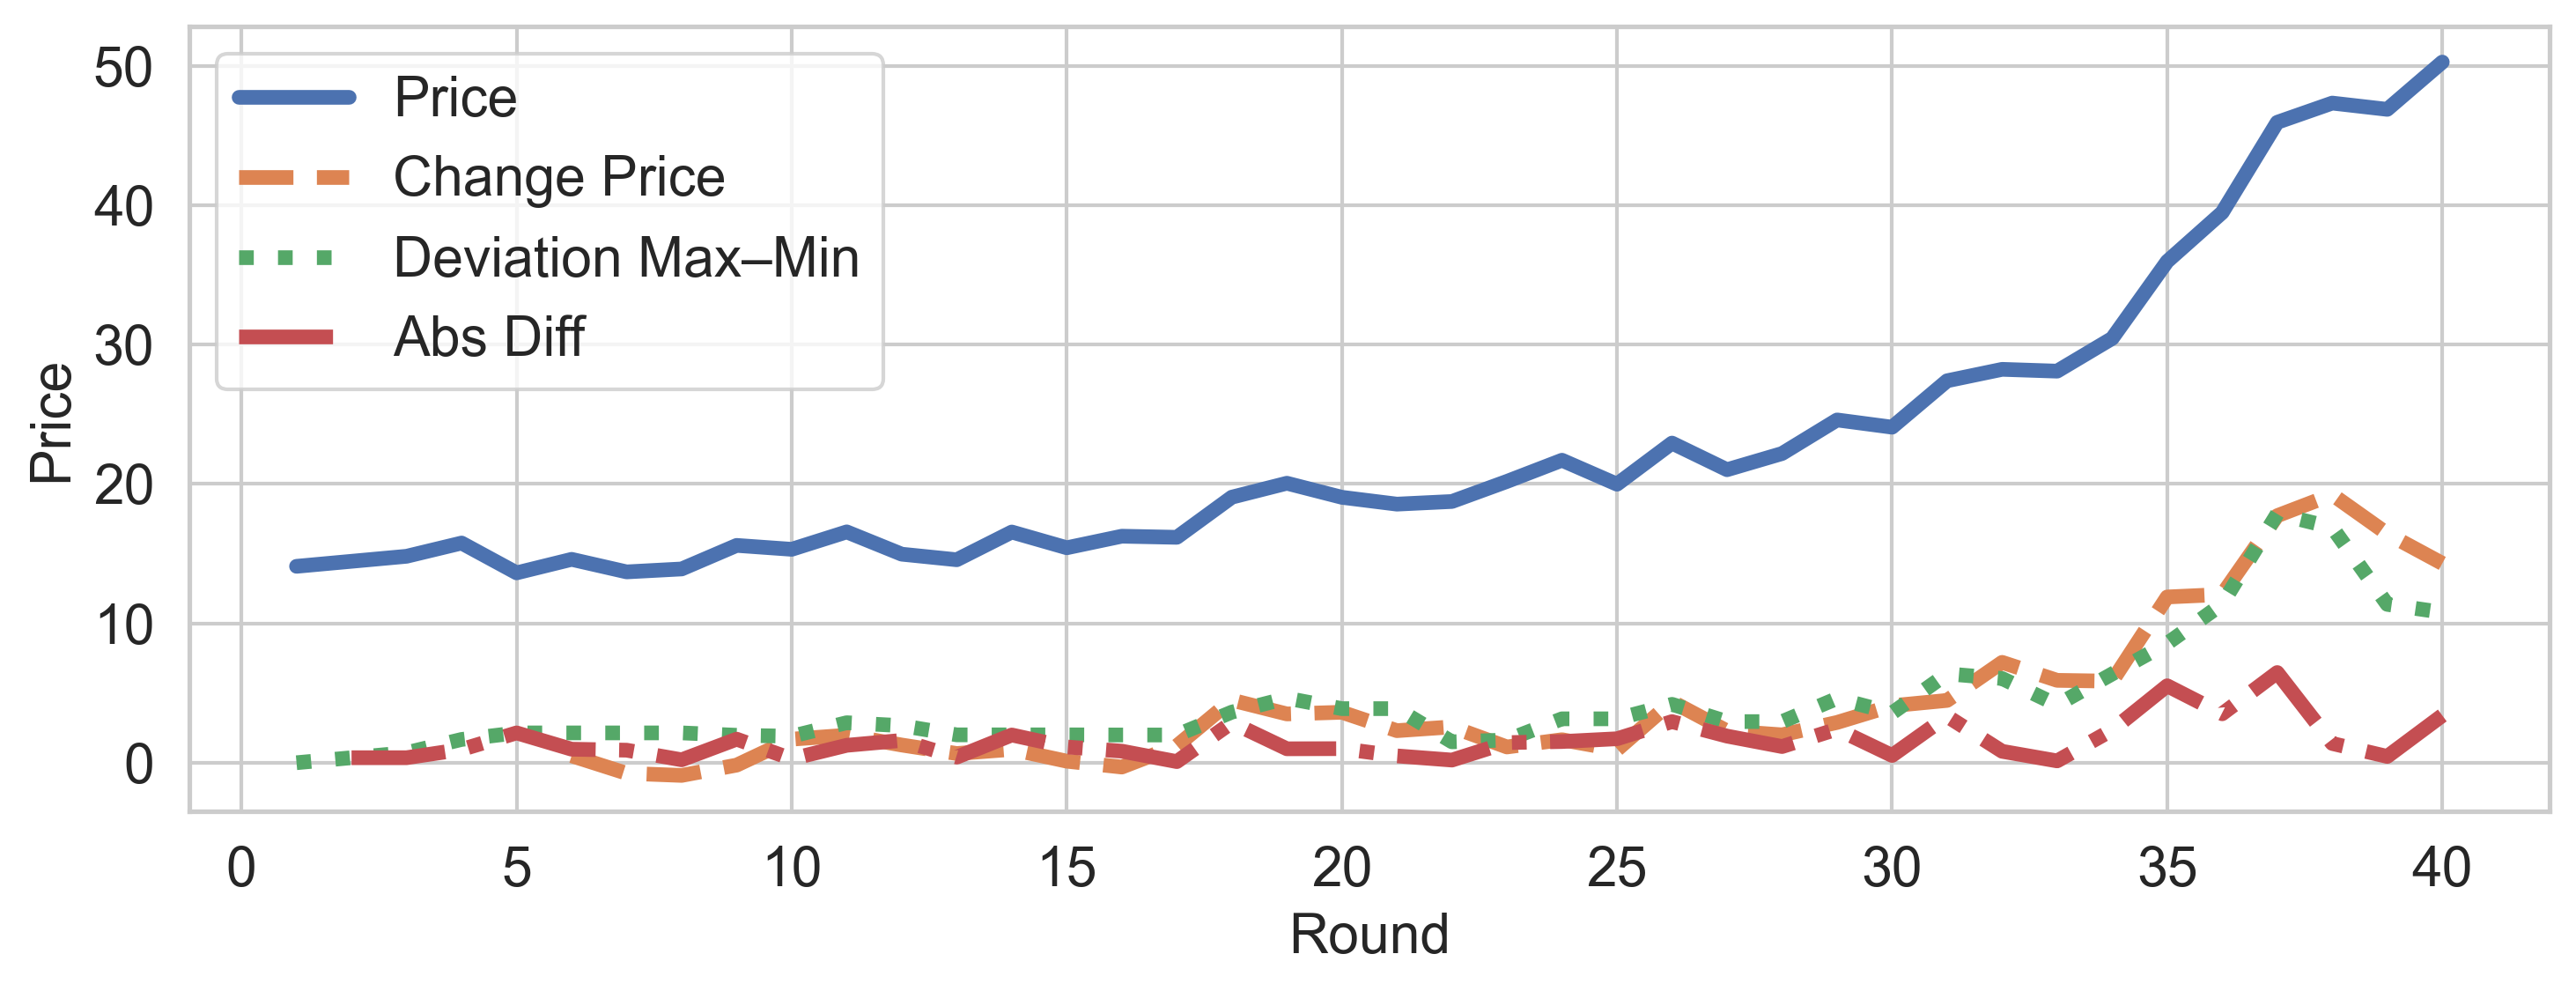

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_19_11_2024_by_Kaufman.png


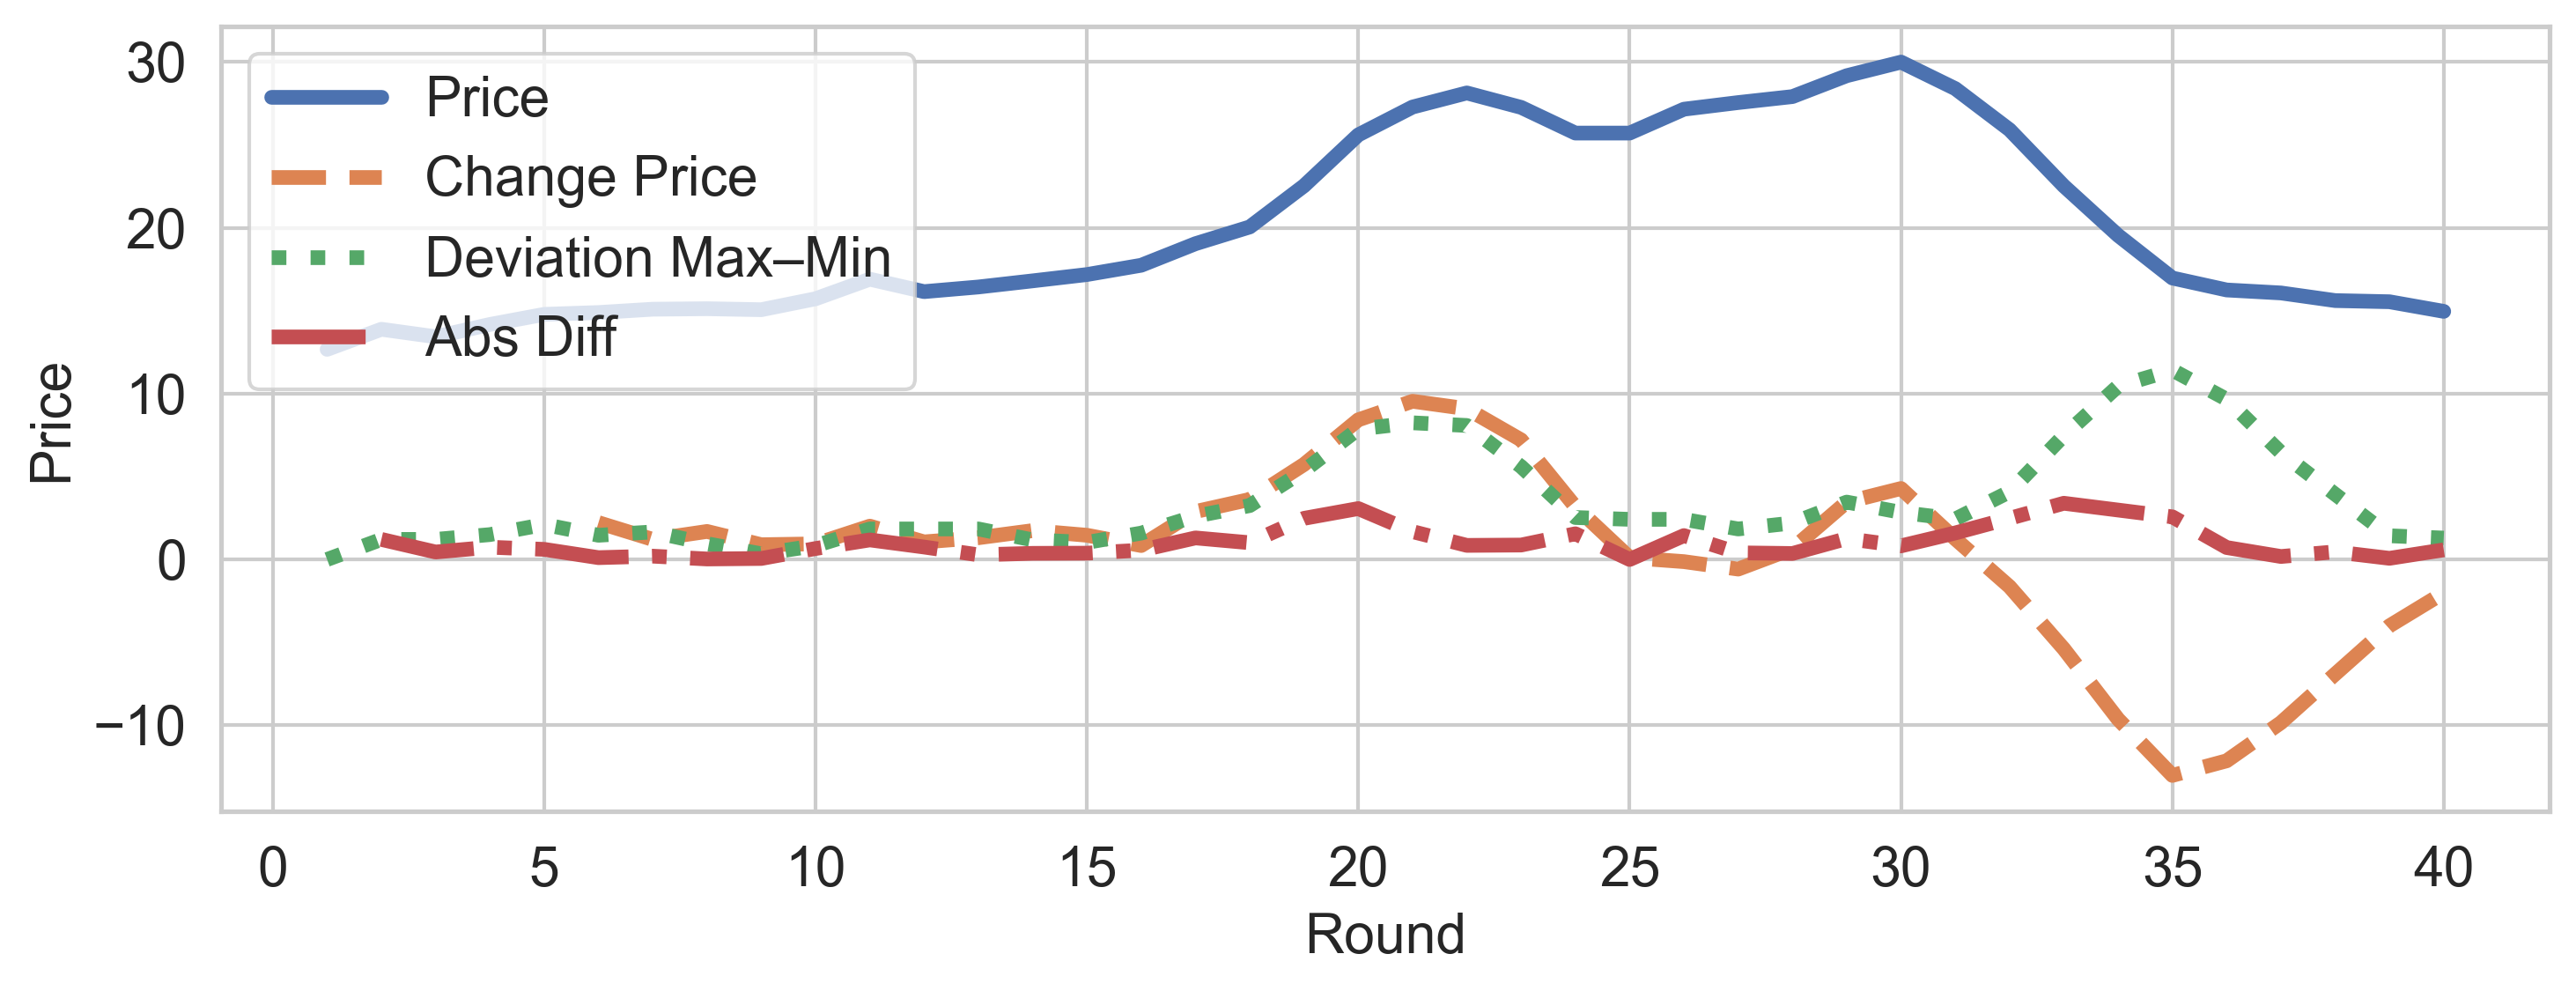

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_20-08-2024_13.45(no fMRI)_by_Kaufman.png


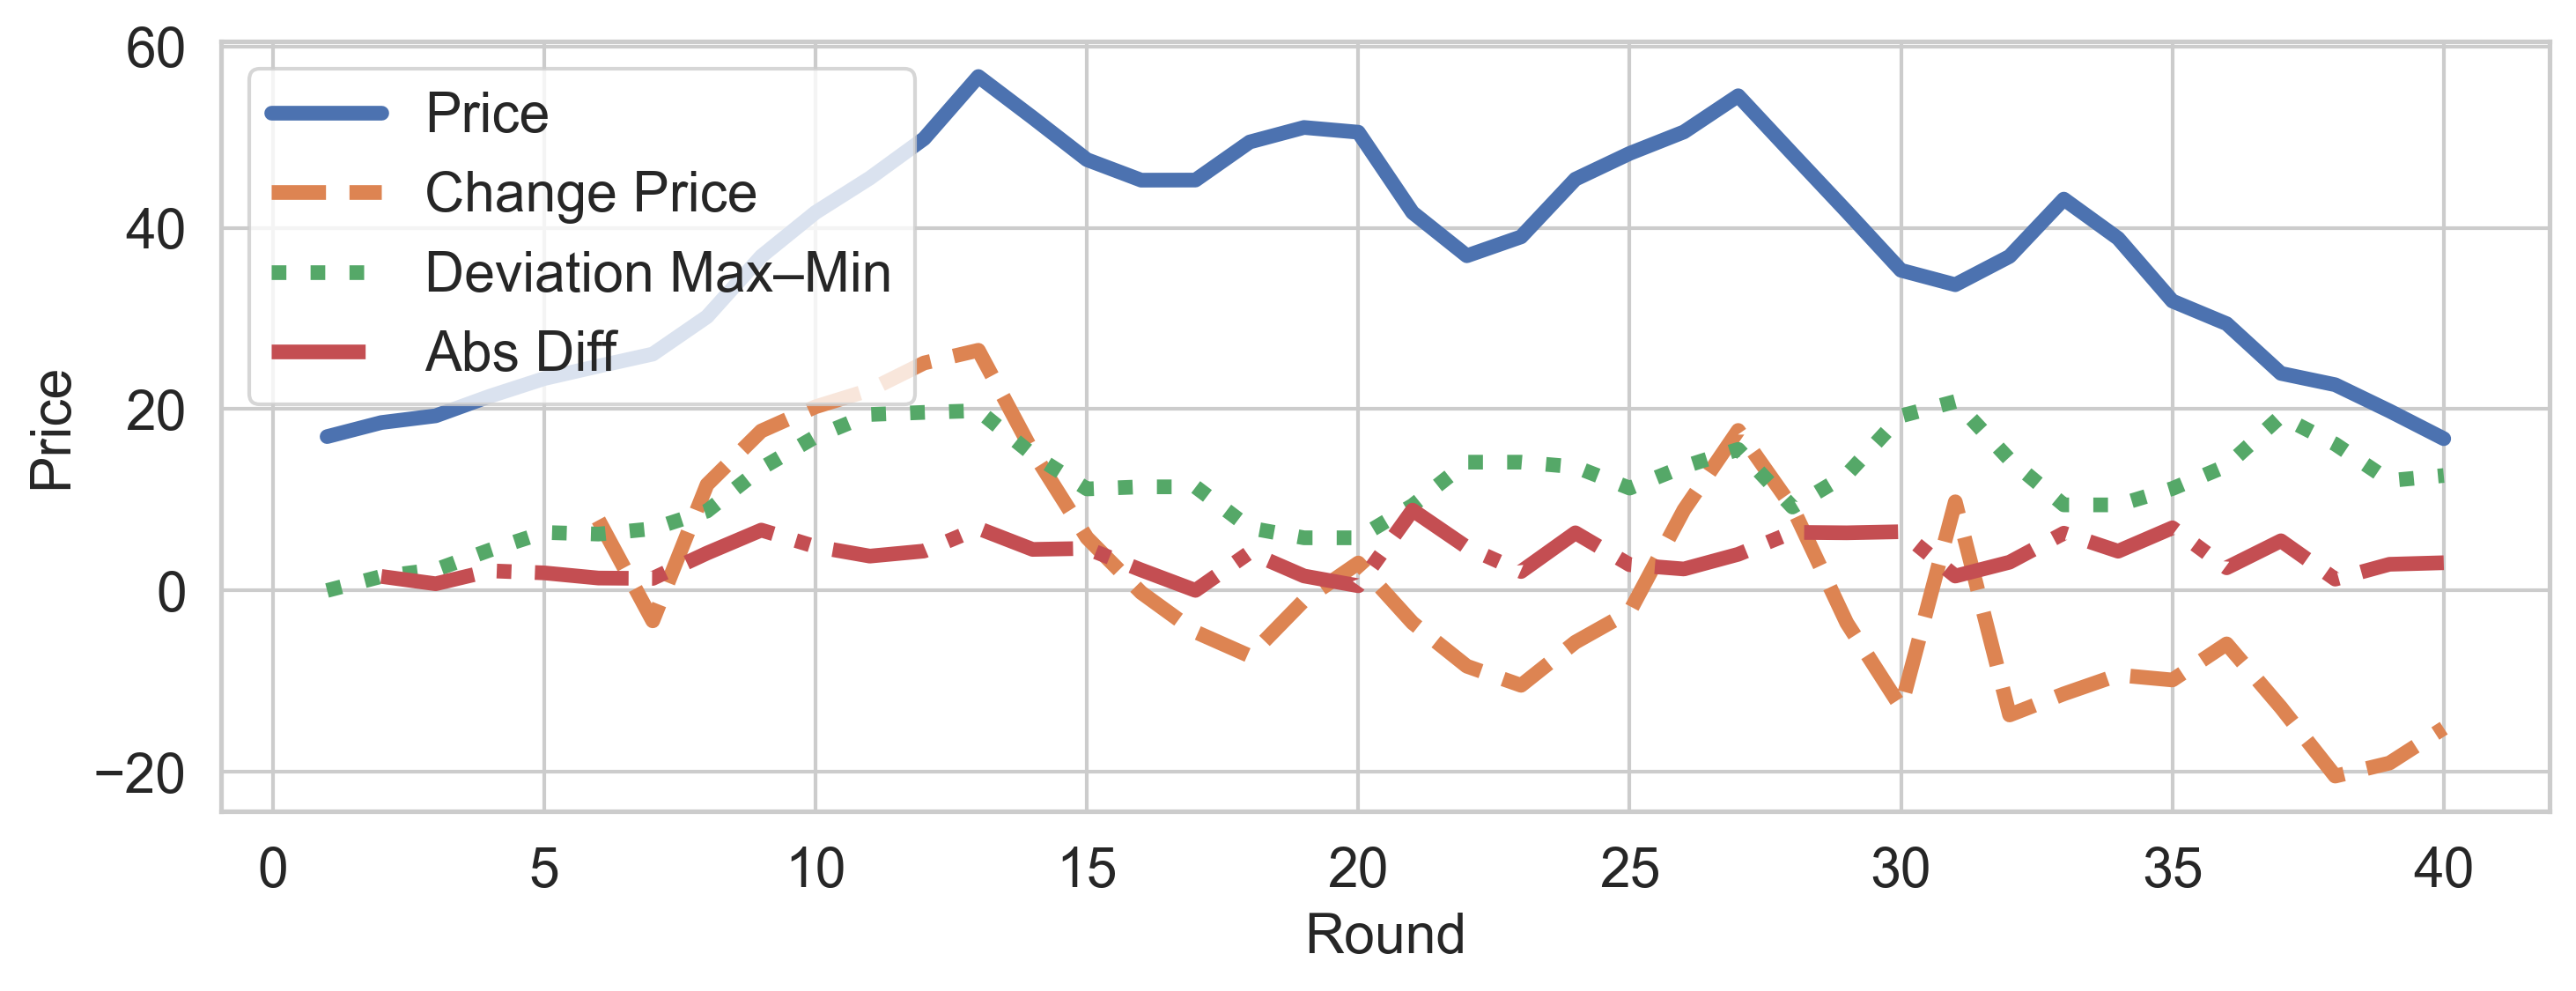

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_20-08-2024_16.15(no fMRI)_by_Kaufman.png


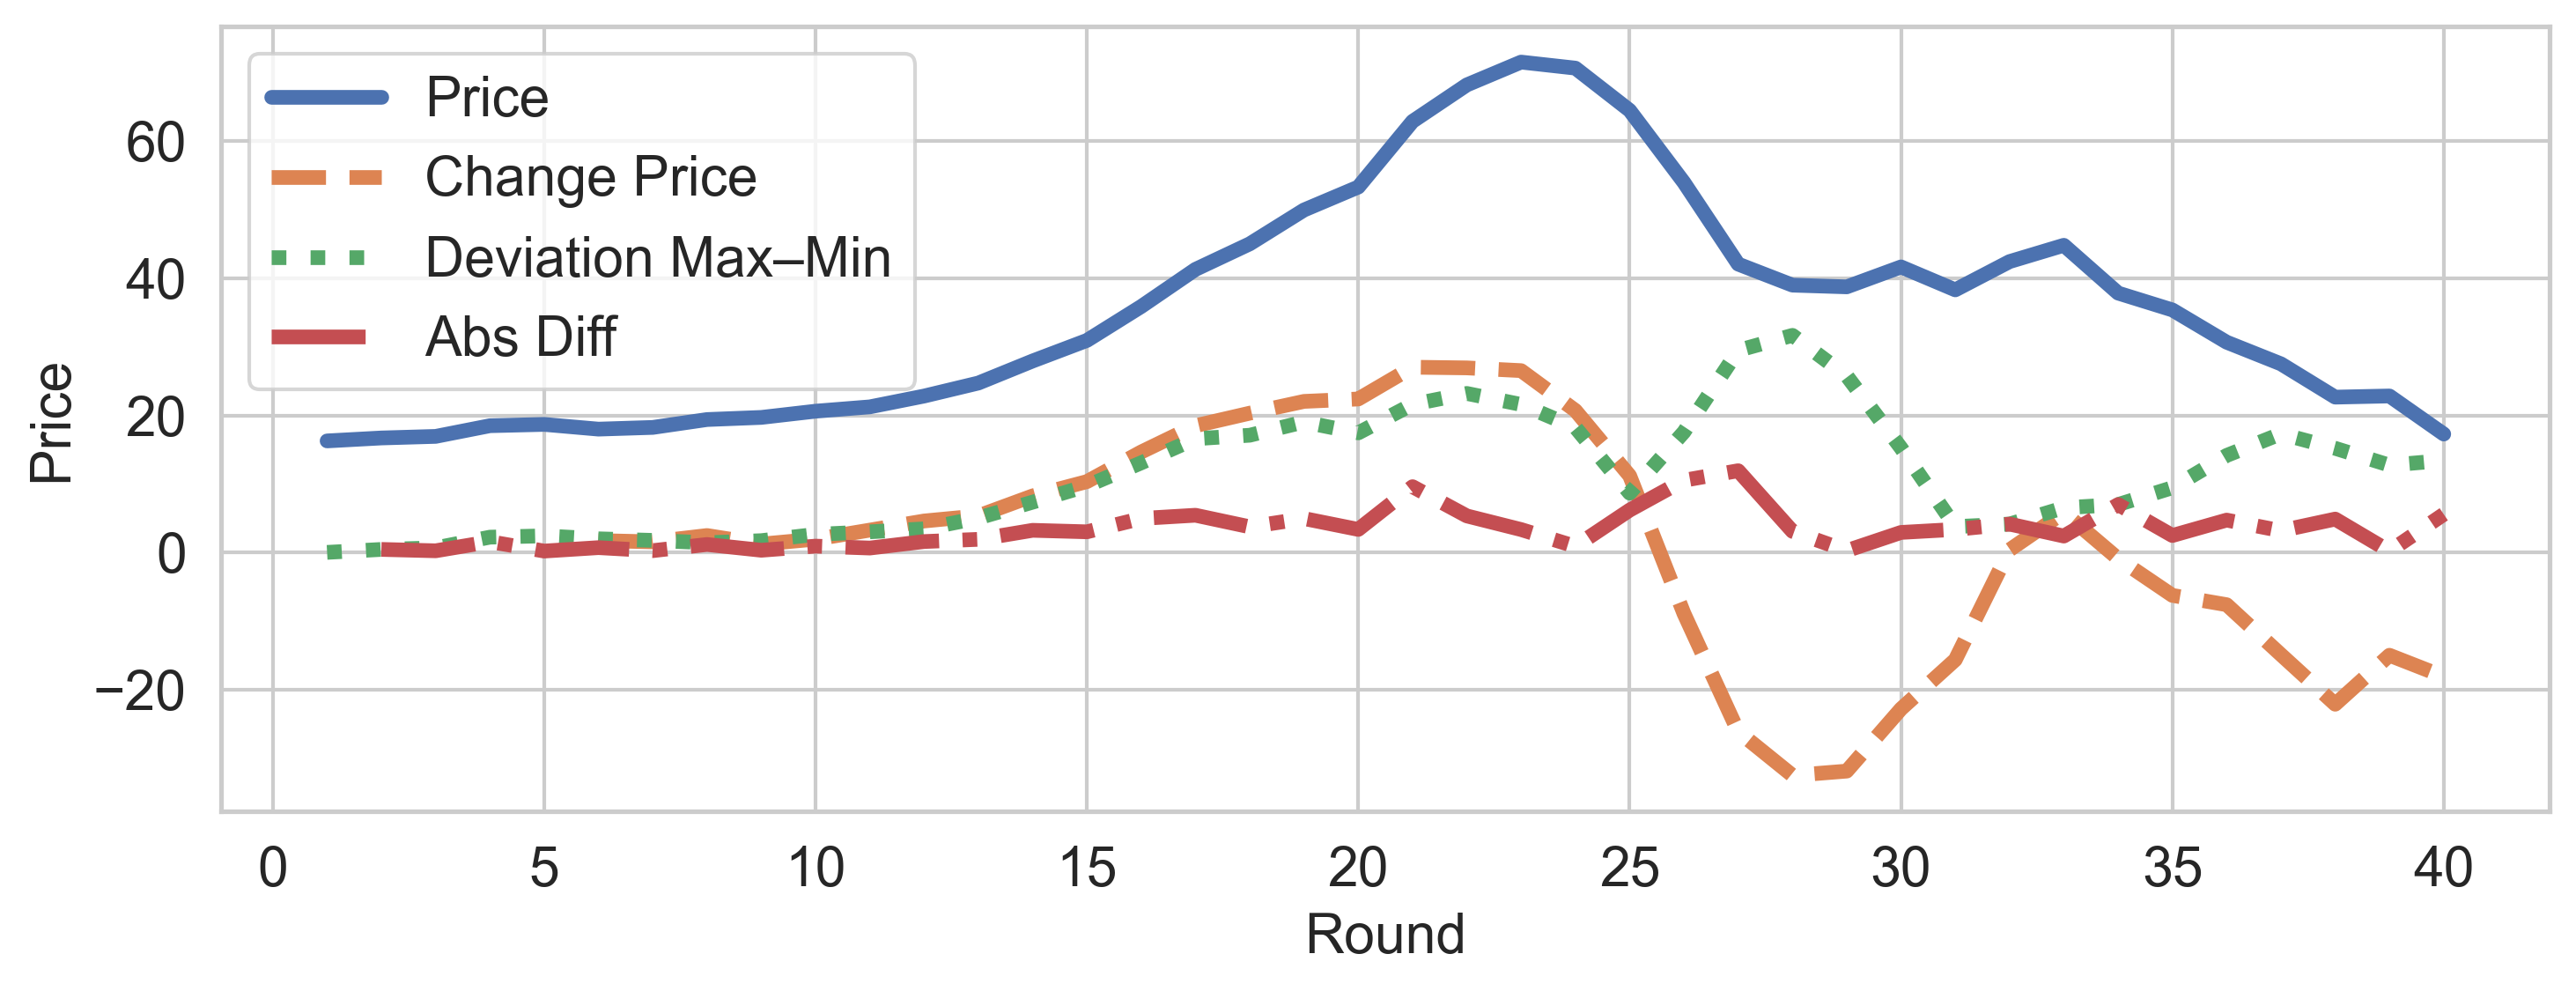

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_21_11_2024 (no fMRI) _by_Kaufman.png


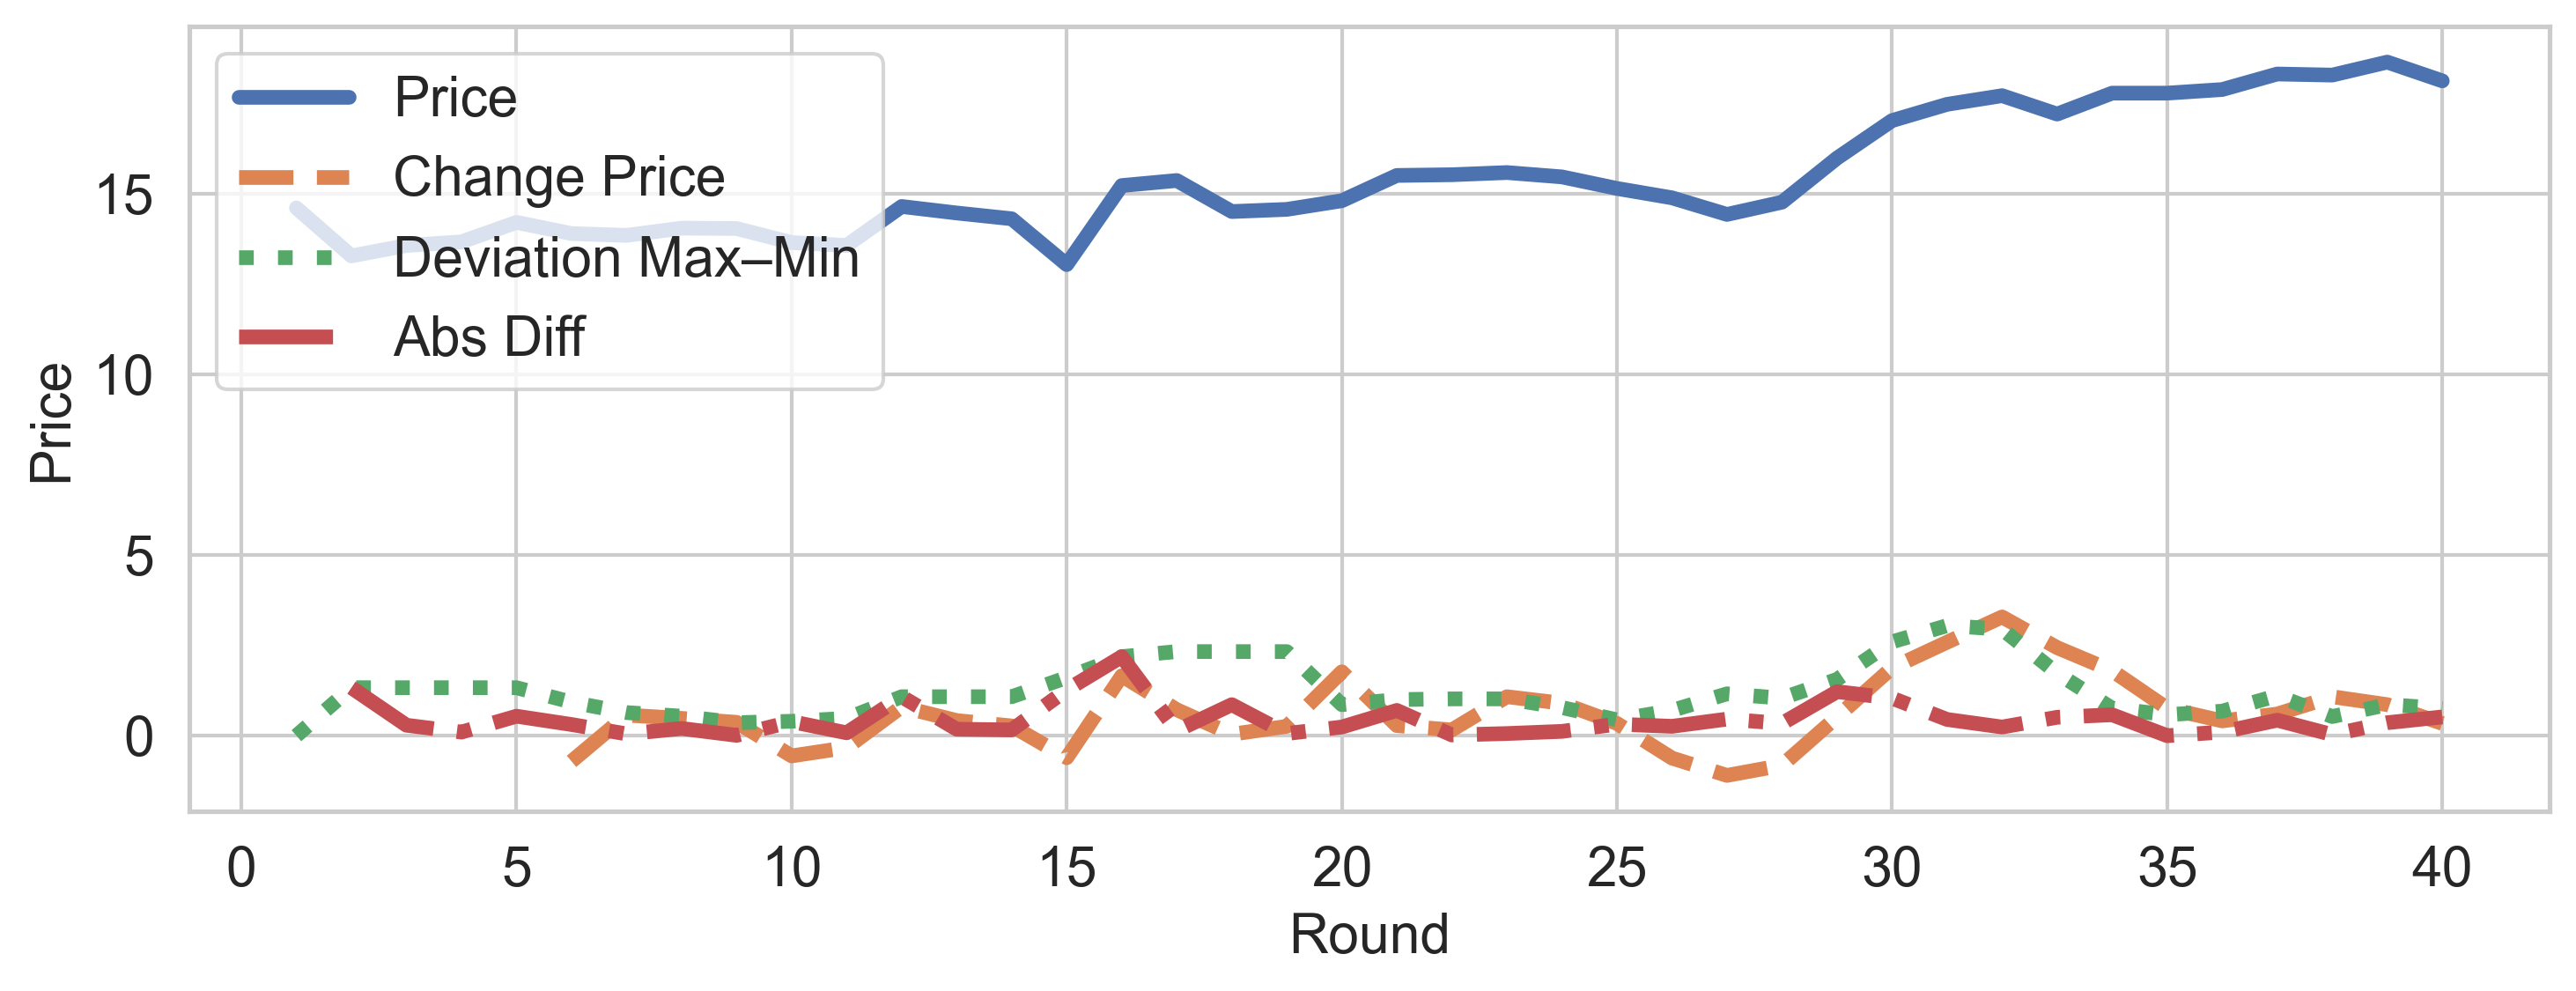

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_27-08-2024_13.45_by_Kaufman.png


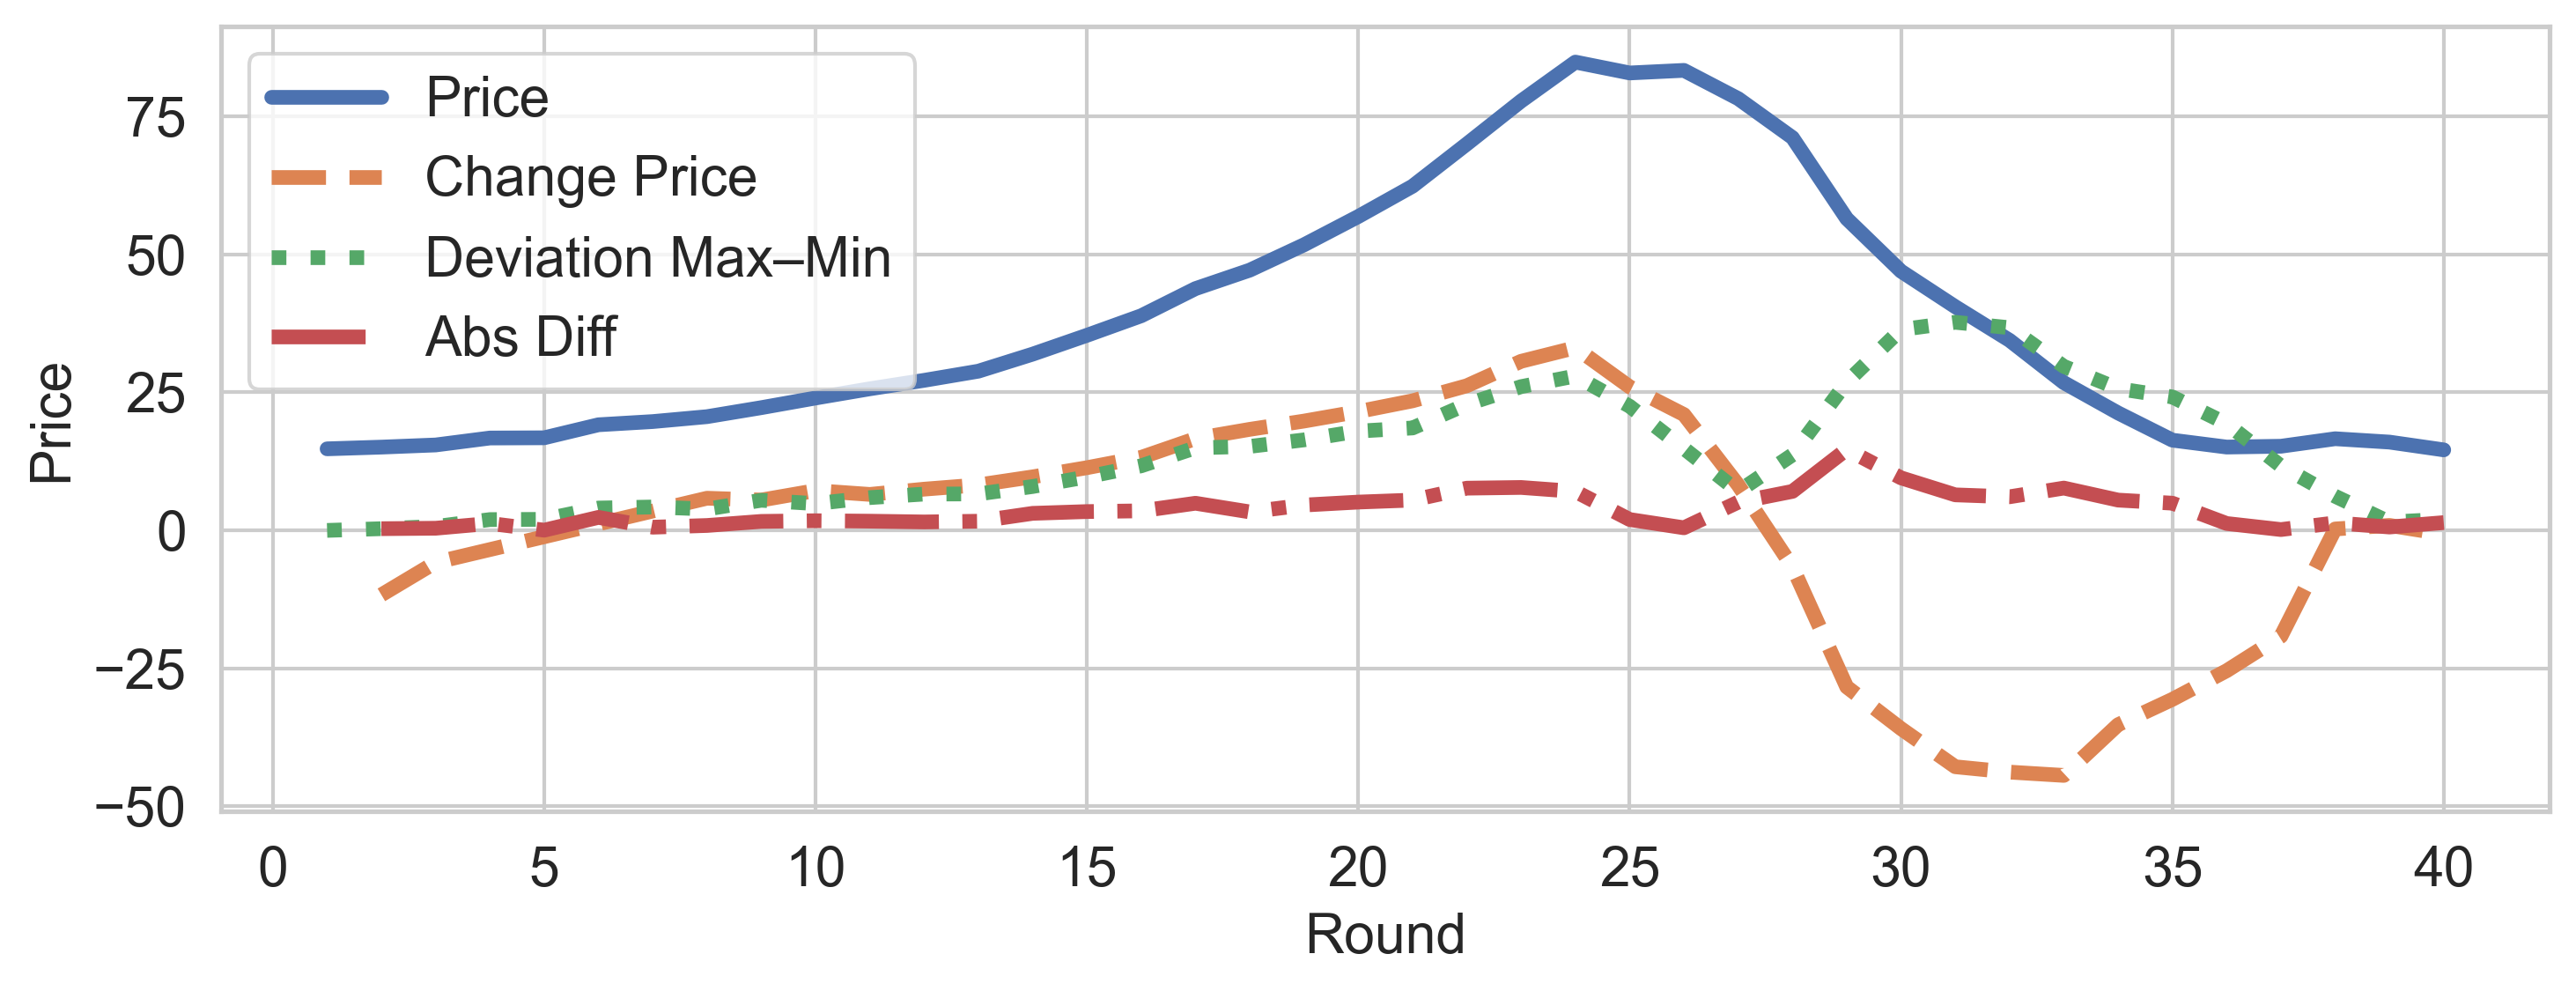

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_27_11_2024_by_Kaufman.png


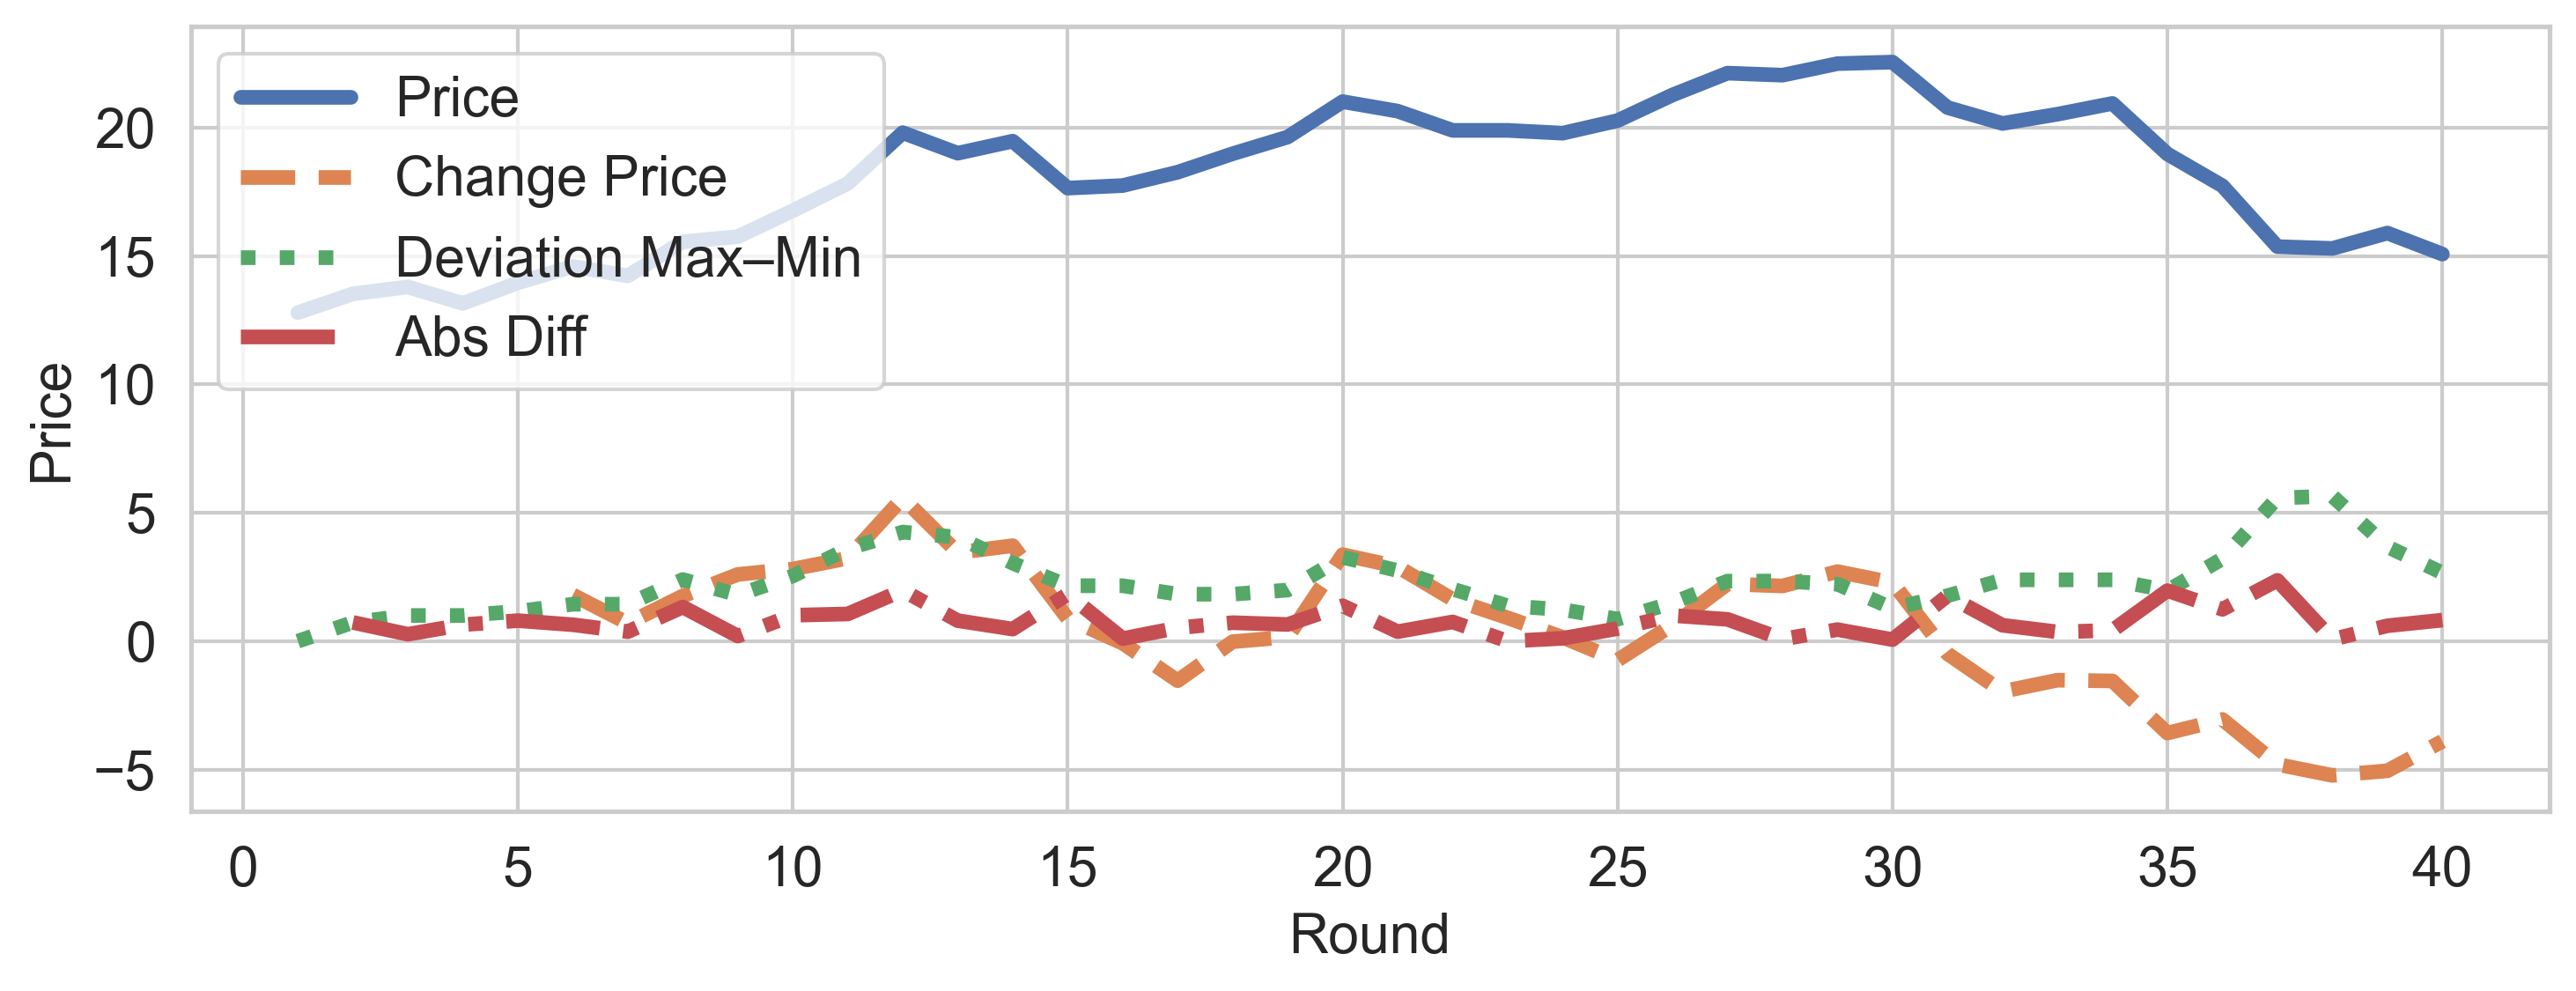

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_28-05-2024_14.30 (pre LSL)_by_Kaufman.png


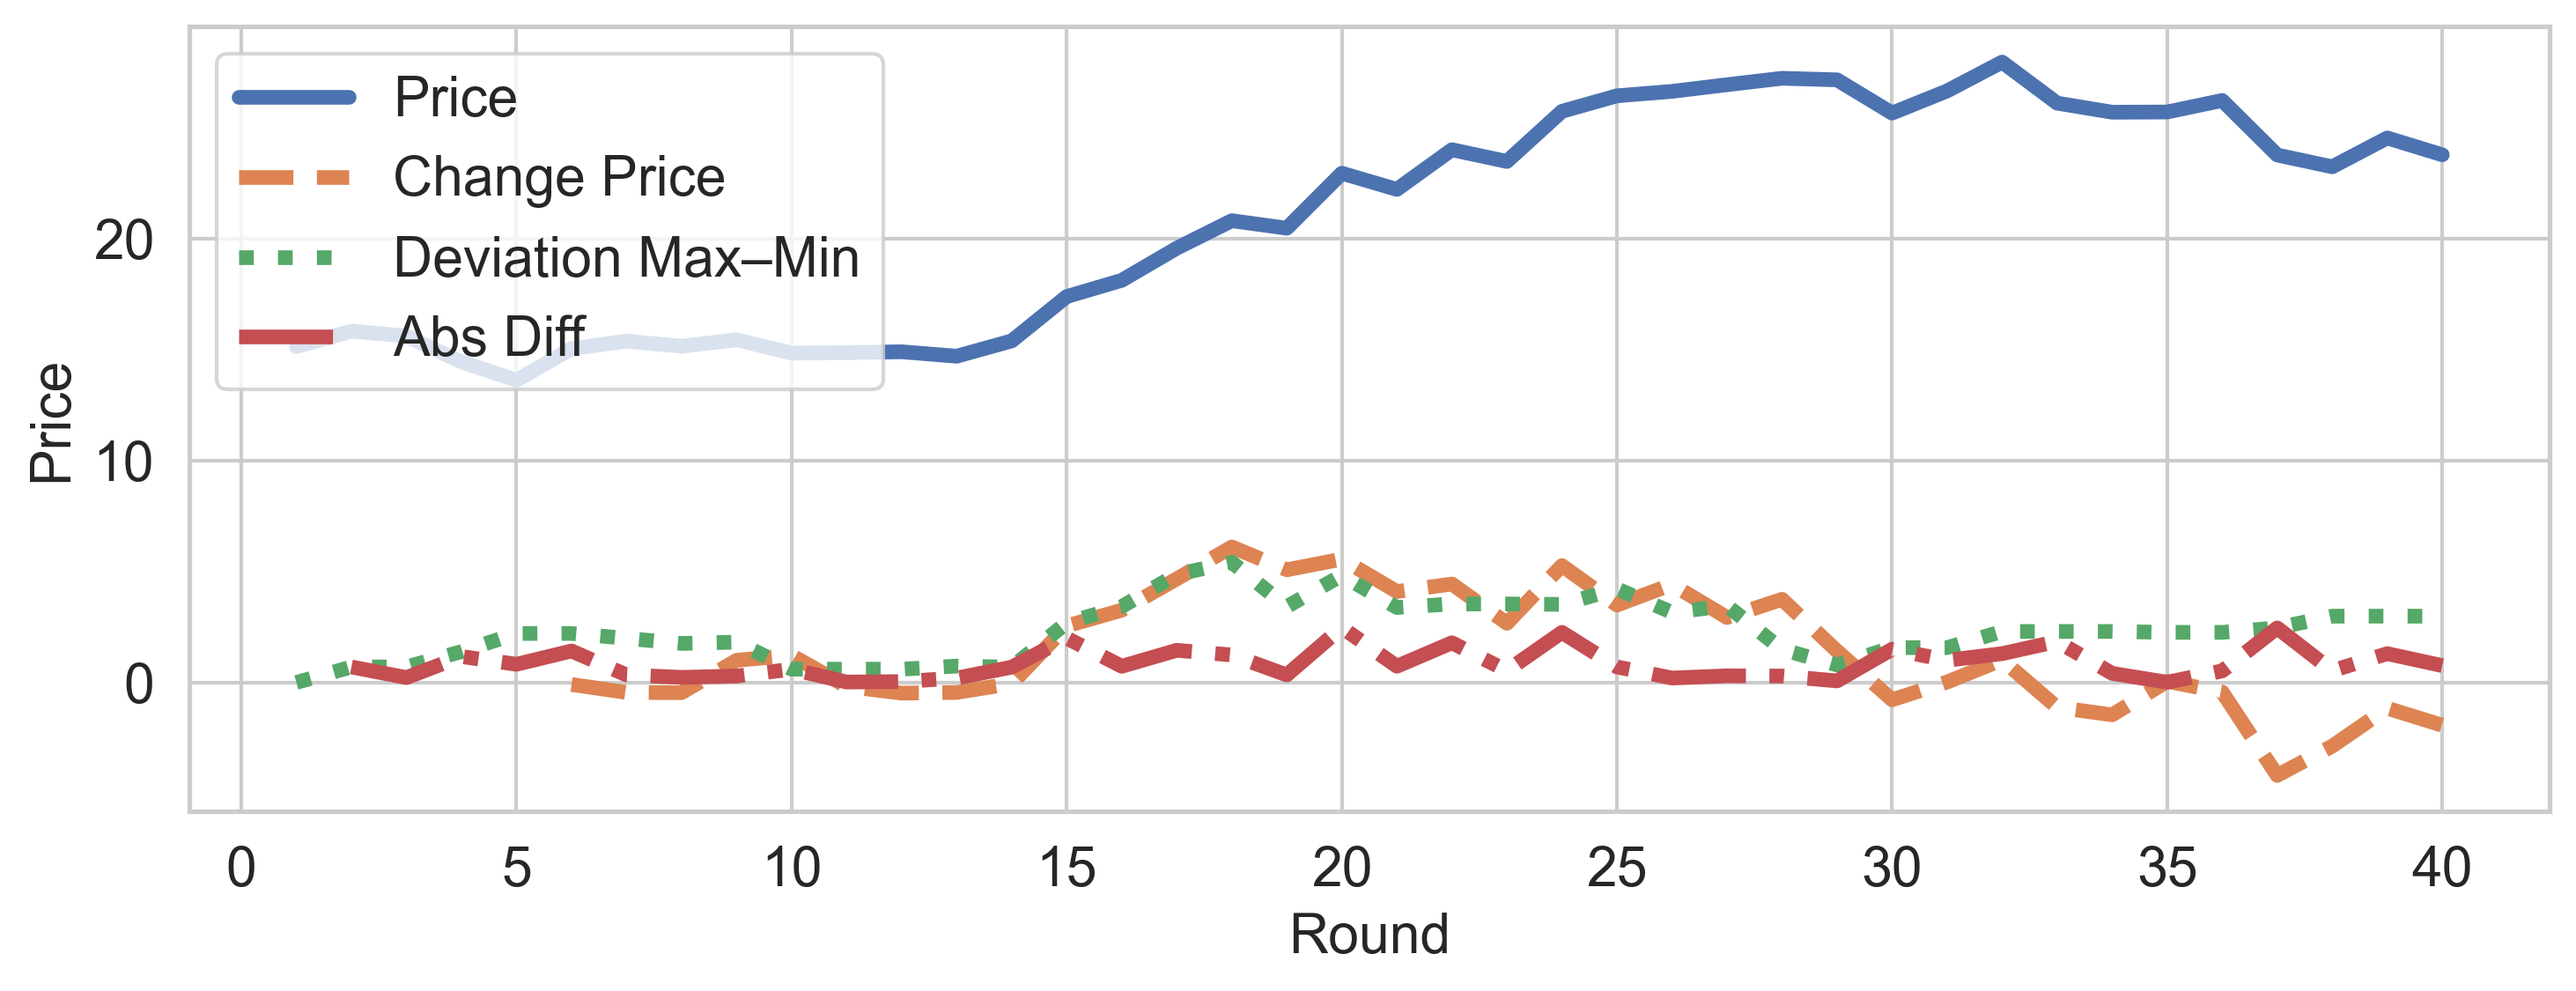

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_28-05-2024_17.15 (pre LSL)_by_Kaufman.png


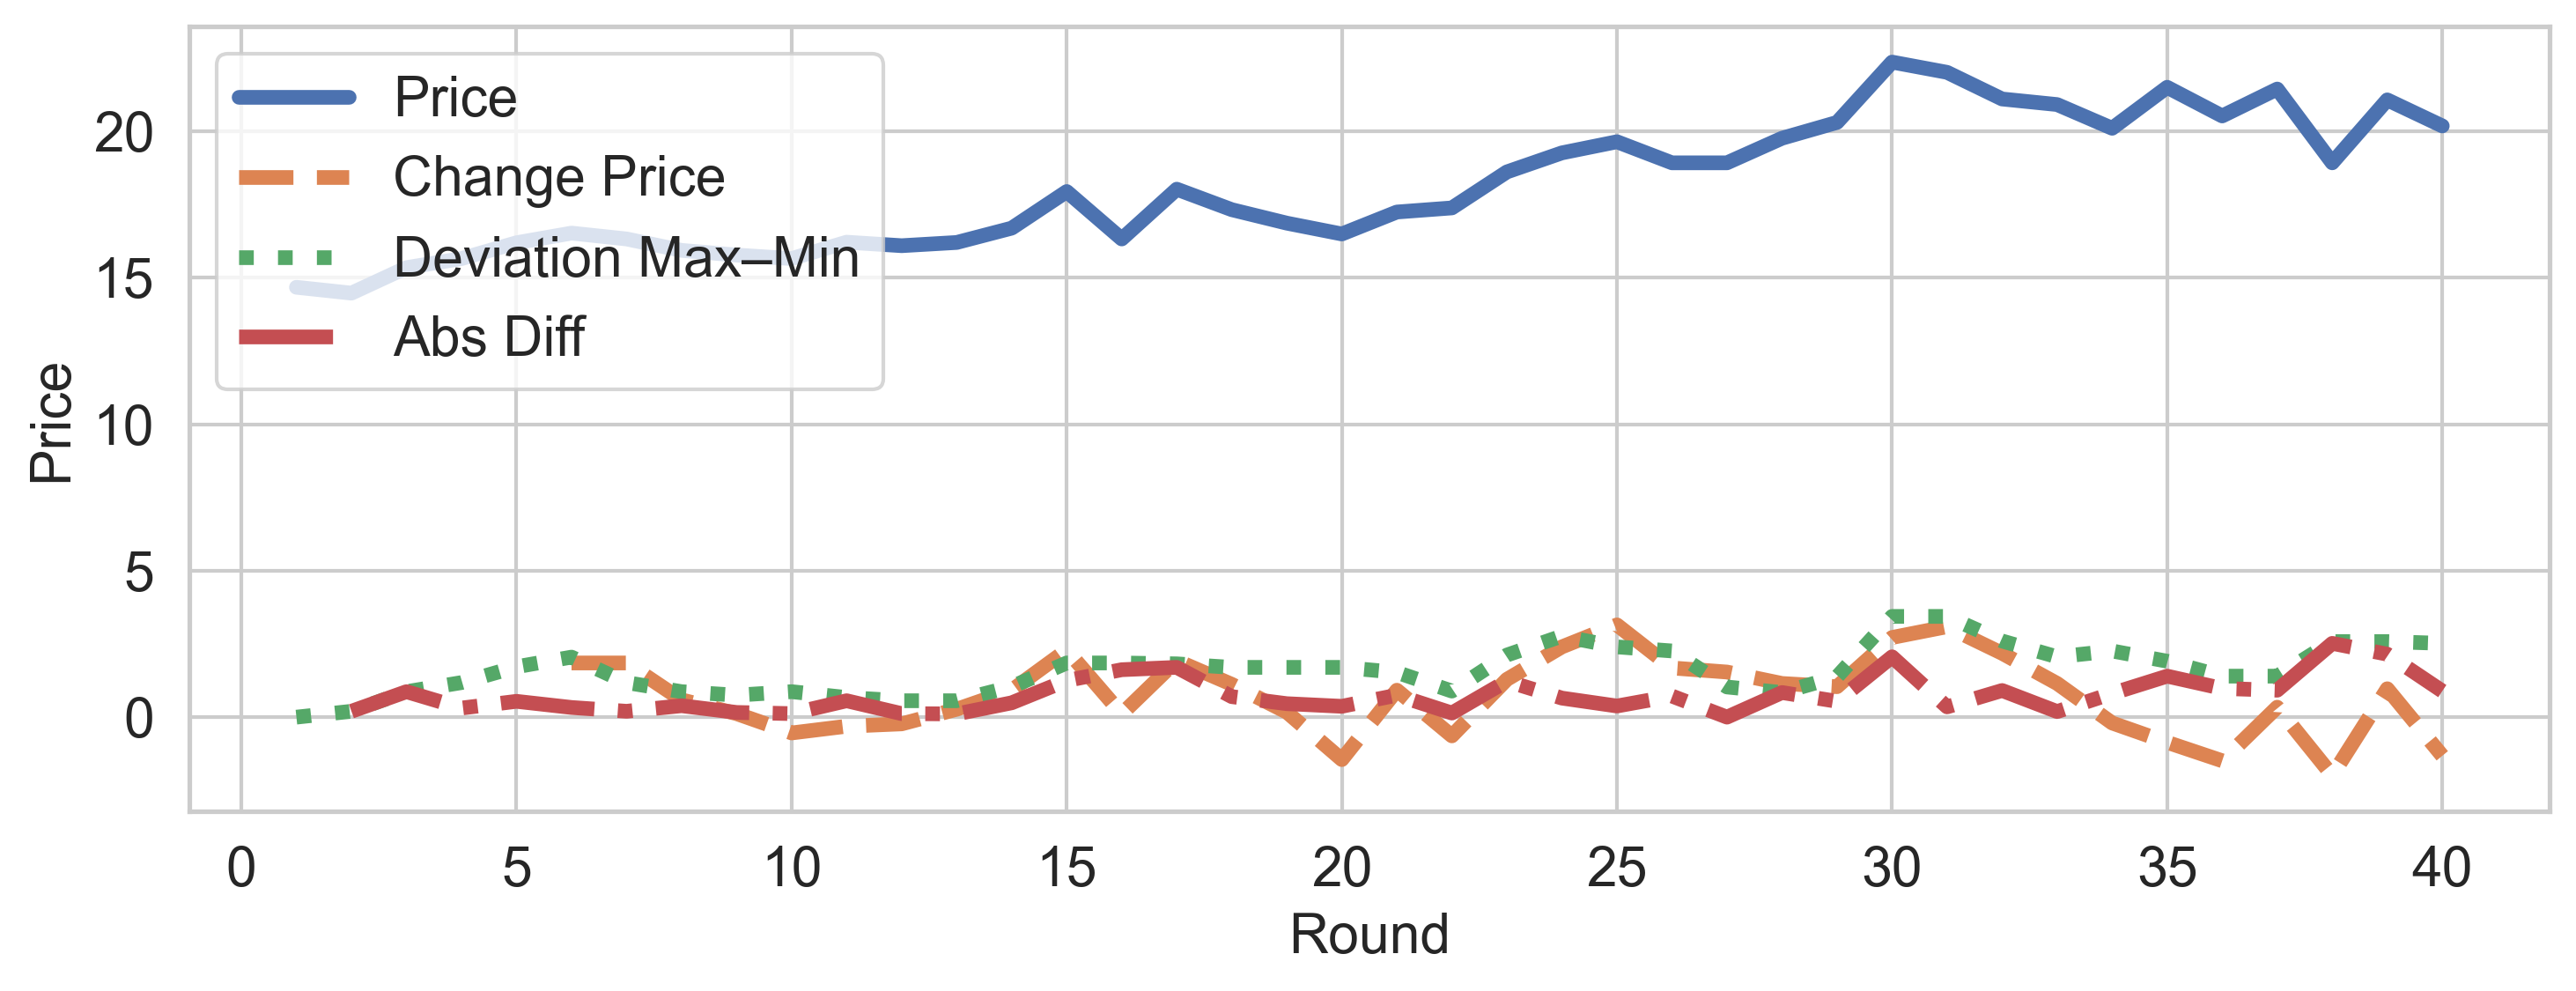

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_28-08-2024_15.15_by_Kaufman.png


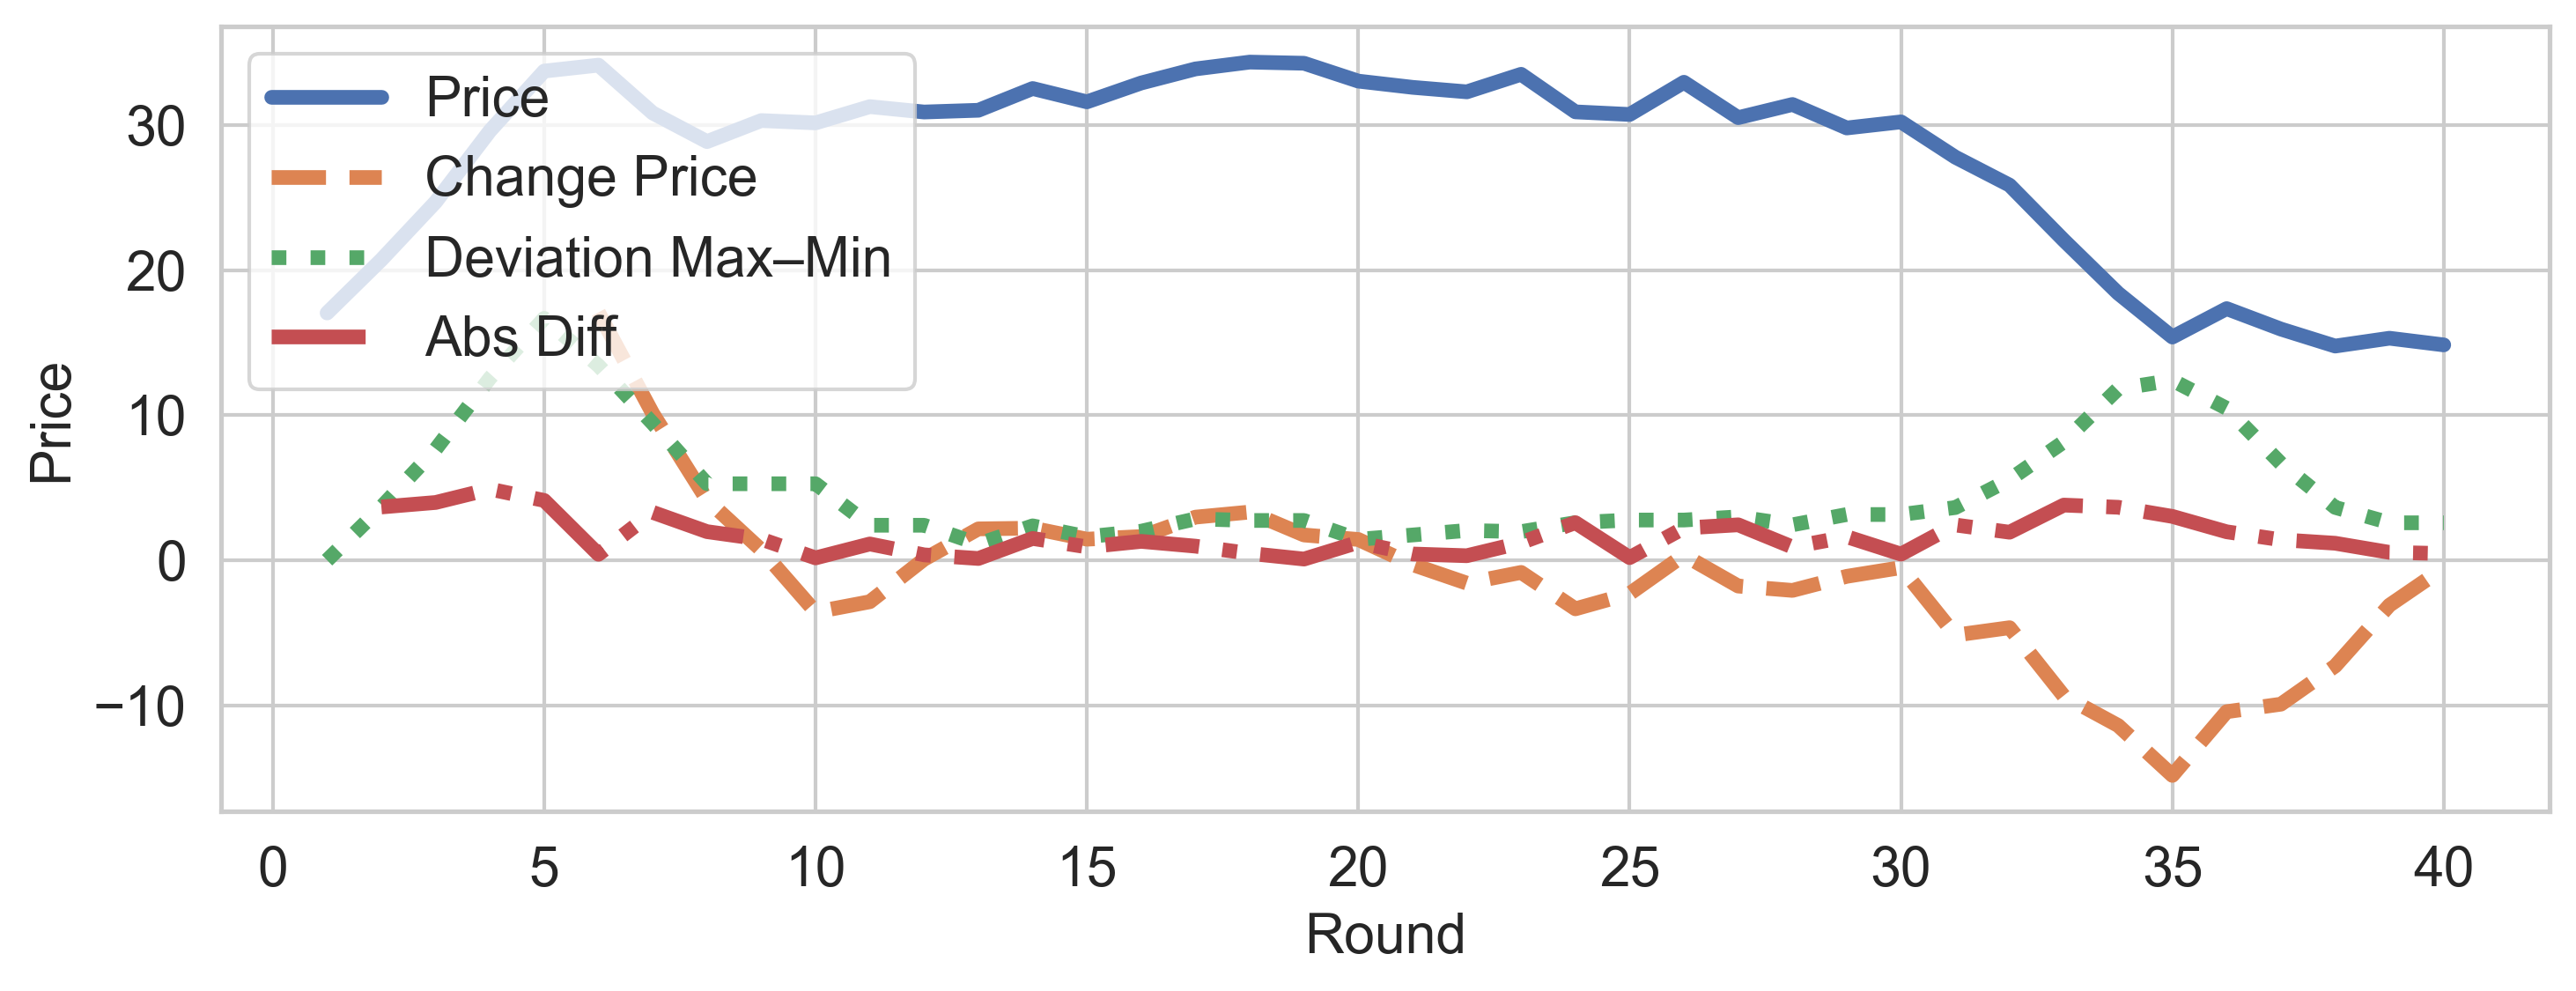

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_28_11_2024_by_Kaufman.png


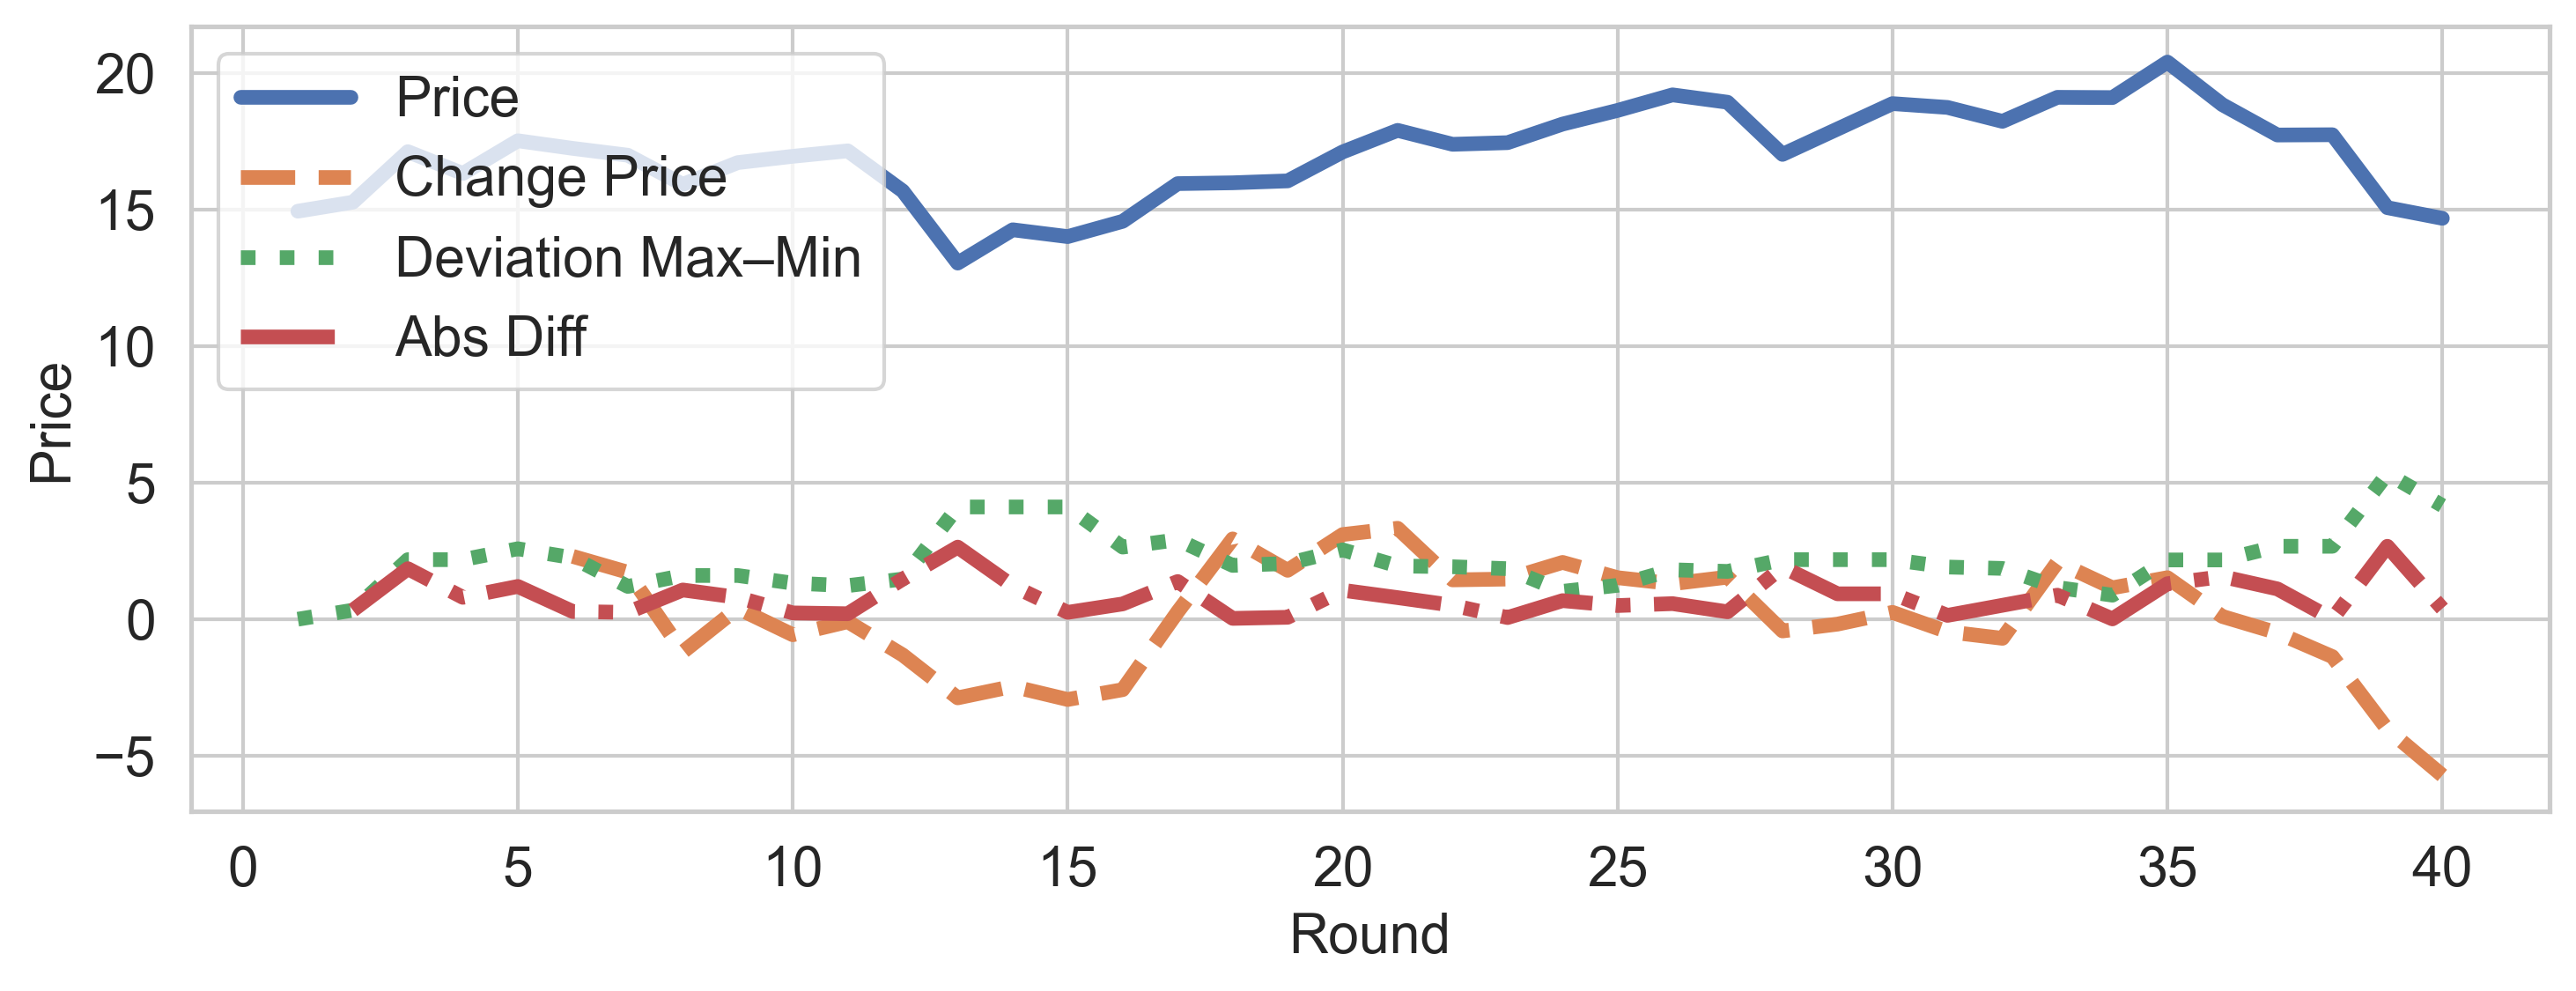

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_Kaufman/Volatility_29-05-2024_15.30 (pre LSL)_by_Kaufman.png


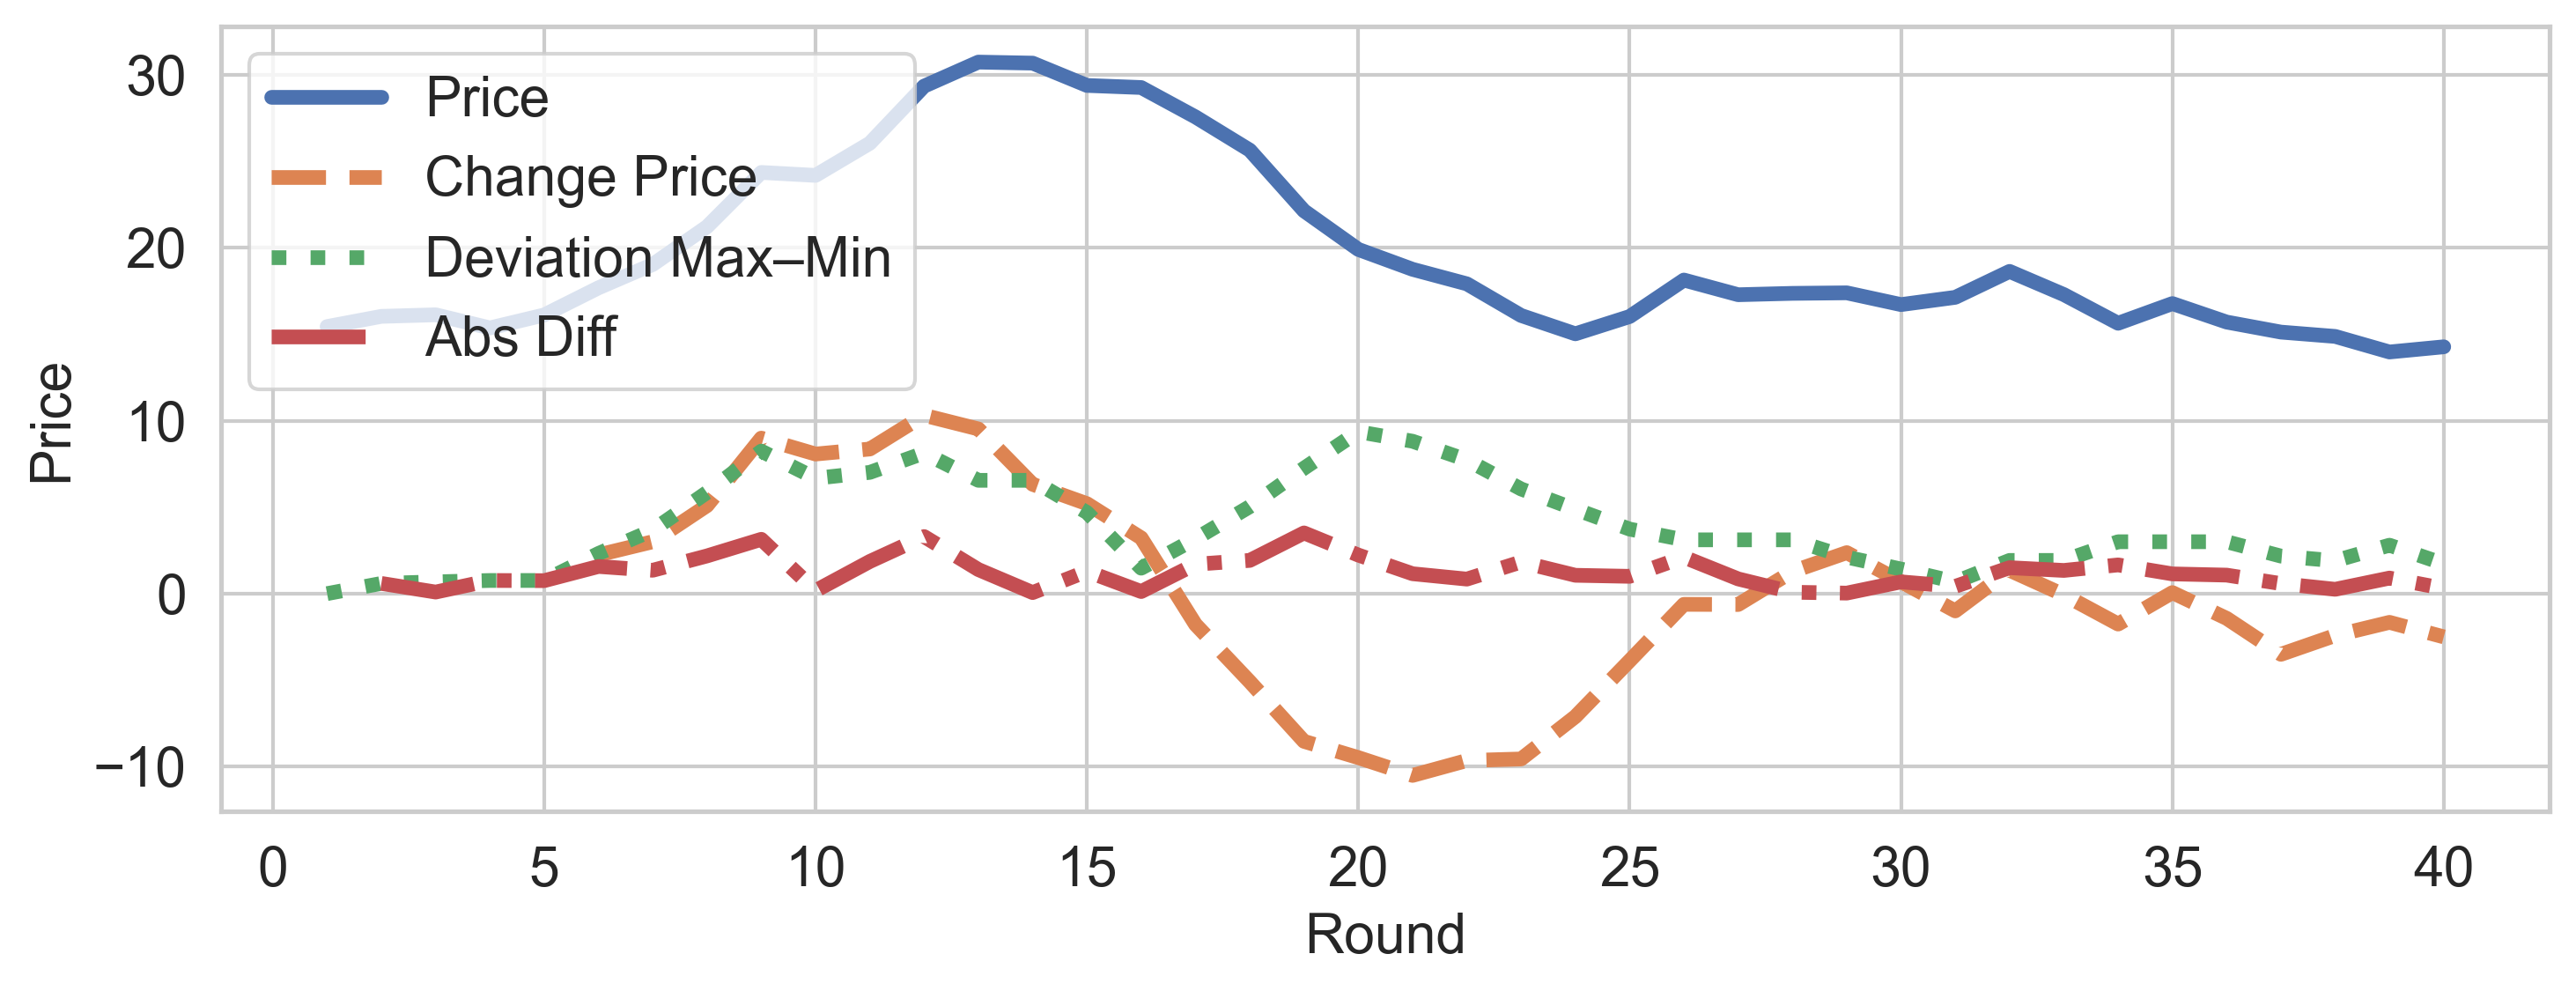

In [30]:
# Creating a plot visualization for each session. Each plot contains all voaltility measures by Kaufman.
# measurements by Kaufman: "change_price", "deviation_max_min", "abs_diff"


# new DF
df_Kaufmann = df_plot[["session", "round", "price", "V_t", "change_price", "deviation_max_min", "abs_diff"]].copy().drop_duplicates().sort_values(["session", "round", "price"])

# get sessions
sessions = sorted(df_Kaufmann["session"].unique())

sns.set(style="whitegrid")


for ses in sessions:
    subset = df_Kaufmann[df_Kaufmann["session"] == ses]

    #determine sizes of labels and ticks.
    plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

    fig, ax1 = plt.subplots(figsize=(10, 4))
    #ax2 = ax1.twinx() # second y-ax
    #plt.title(f"Session {ses}")
    
    # For each measure a line
    sns.lineplot(data=subset, x="round", y="price", ax=ax1, label="Price", linewidth=4)
    sns.lineplot(data=subset, x="round", y="change_price", ax=ax1, label="Change Price", linestyle="--", linewidth=4)
    sns.lineplot(data=subset, x="round", y="deviation_max_min", ax=ax1, label="Deviation Max–Min", linestyle=":", linewidth=4)
    sns.lineplot(data=subset, x="round", y="abs_diff", ax=ax1, label="Abs Diff", linestyle="-.", linewidth=4)

    ax1.set_xlabel("Round")
    ax1.set_ylabel("Price")

    #sns.lineplot(data=subset, x ="round", y ="V_t", ax = ax2, color = "black", label="V_t", linewidth=1) 
    #ax2.set_ylabel("V_t")

    #Create legend based on hanles
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    #lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1, labels_1, loc="upper left")

    plt.tight_layout()
    #Save 
    folder = VISUALIZATION / "Volatility_Kaufman"
    os.makedirs(folder, exist_ok=True)
    save_path = folder/ f"Volatility_{ses}_by_Kaufman.png"
    fig.savefig(save_path)
    if os.path.exists(save_path):
        print(f"✅ plot was saved under: {save_path}")
    else: 
        print(f"❌ plot was not saved")
    plt.show()
    plt.close()


## Volatility by Ederington

This chapter represents the visualization of Ederington measures

### 1. Only V_t for each session in one plot

In [31]:
# All sessions
sessions = sorted(df_plot["session"].unique())
n_sessions = len(sessions)

# Number of grids per row
cols = 3  
rows = math.ceil(n_sessions / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()  

# Each session in a plot
for i, session in enumerate(sessions):
    ax = axes[i]
    data = (
        df_plot[df_plot["session"] == session]
        .groupby("round", as_index=False)["V_t"]
        .mean()
    )
    ax.plot(data["round"], data["V_t"], marker="o", color="steelblue")
    ax.set_title(f"Session {session}")
    ax.set_xlabel("Round")
    ax.set_ylabel("Volatility")
    ax.grid(True)

# Remove empty axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Volatility by Ederington per Session", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
save_path = VISUALIZATION/ f"Volatility_by_Ederington.png"
fig.savefig(save_path)
if os.path.exists(save_path):
    print(f"✅ plot was saved under: {save_path}")
else: 
    print(f"❌ plot was not saved")
#plt.show()
plt.close()

✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/Volatility_by_Ederington.png


### 2. MAD and AMAD for each session in one plot

In [32]:


# All sessions
sessions = sorted(df_plot["session"].unique())
n_sessions = len(sessions)

# Number of cells per row
cols = 3
rows = math.ceil(n_sessions / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=True, sharey=True)
axes = axes.flatten()


for i, session in enumerate(sessions):
    ax = axes[i]
    
    # Caluclating the mean of each session
    data = (
        df_plot[df_plot["session"] == session]
        .groupby("round", as_index=False)[["MAD_t", "AMAD_t"]]
        .mean()
    )

    # plotting: MAD_t
    ax.plot(
        data["round"], data["MAD_t"],
        marker="o", color="steelblue", label="MADₜ"
    )

    # Plot: AMAD_t
    ax.plot(
        data["round"], data["AMAD_t"],
        marker="s", linestyle="--", color="darkorange", label="AMADₜ"
    )

    
    ax.set_title(f"Session {session}")
    ax.set_xlabel("Round")
    ax.set_ylabel("Volatility")
    ax.grid(True)
    ax.legend(fontsize=8)

# remove empty cells
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Volatility (MADₜ vs AMADₜ) per Session", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
save_path = VISUALIZATION/ f"MAD_AMAD_by_Ederington.png"
fig.savefig(save_path)
if os.path.exists(save_path):
    print(f"✅ plot was saved under: {save_path}")
else: 
    print(f"❌ plot was not saved")
#plt.show()
plt.close()


✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/MAD_AMAD_by_Ederington.png


### 3. All meausres by Ederington: AMAD, MAD, V_t

In [33]:

def plot_block(sessions_block, rows, cols, filename):
    """
    Create visualizations for all volatility measures and all sessions by creating 3 blocks (Top, middle and bottom). 
    """
    fig = plt.figure(figsize=(cols*5, rows*3.2), constrained_layout=True)
    outer_gs = fig.add_gridspec(rows, cols, hspace=0.25, wspace=0.15)

    # settings such as label and title sizes
    plt.rcParams.update({
    "font.size": 15,
    "axes.titlesize": 15,
    "axes.labelsize": 15,
    "xtick.labelsize": 15,
    "ytick.labelsize": 15,
    "legend.fontsize": 15,
})

    for idx, session in enumerate(sessions_block):
        # row and columns
        r = idx // cols
        c = idx % cols

        inner_gs = outer_gs[r, c].subgridspec(
            2, 1,
            height_ratios=[3, 1],
            hspace=0.01
        )

        ax_vol = fig.add_subplot(inner_gs[0])
        ax_price = fig.add_subplot(inner_gs[1], sharex=ax_vol)

        data = (
            df_plot[df_plot["session"] == session]
            .groupby("round", as_index=False)[["MAD_t", "AMAD_t", "V_t", "price"]]
            .mean()
            .sort_values("round")
        )

        # Each measure
        ax_vol.set_ylim(0, 0.15)
        ax_vol.plot(data["round"], data["MAD_t"], label="MAD", linewidth=3,)
        ax_vol.plot(data["round"], data["AMAD_t"], linestyle="--", label="AMAD", linewidth=3,)
        ax_vol.plot(data["round"], data["V_t"], linestyle="-.", label="V", linewidth=3,)
        ax_vol.set_title(f"Session {session}", fontsize=15)
        ax_vol.set_ylabel("Volatility", fontsize=15)
        ax_vol.grid(True)
        ax_vol.legend(fontsize=10, loc="upper left")
        ax_vol.tick_params(labelbottom=False)

        ax_price.plot(data["round"], data["price"], color="black", linewidth=4, alpha=0.5)
        ax_price.set_ylabel("Price", fontsize=15)
        ax_price.set_xlabel("Round", fontsize=15)
        ax_price.grid(True)

    #fig.suptitle("Volatility per Session (Top Block)", fontsize=14, fontweight="bold")
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()
    print("Saved:", filename)

# Splitting the data in 3 groups (top, middle, bottom)

cols = 2
top_rows = 3
middle_rows = 4

sessions = sorted(df_plot["session"].unique())
top_count = top_rows * cols
top_sessions = sessions[:top_count]
middle_count = middle_rows * cols
middle_session = sessions[top_count: top_count + middle_count]
bottom_sessions = sessions[top_count + middle_count:]

bottom_rows = math.ceil(len(bottom_sessions) / cols)

#create paths
path_top = VISUALIZATION / "volatility_top.png"
path_middle = VISUALIZATION / "volatility_middle.png"
path_bottom = VISUALIZATION / "volatility_bottom.png"

#execute method
plot_block(top_sessions, top_rows, cols, path_top)
plot_block(middle_session, middle_rows, cols, path_middle)
plot_block(bottom_sessions, bottom_rows, cols, path_bottom)


Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/volatility_top.png
Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/volatility_middle.png
Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/volatility_bottom.png


## Heatmap for Volatility Classification

In [34]:
# Plotting heatmap:  Frquency of each  Risk Volatility classification

CATS = [0, 0.5, 1]  # explicit order
path_heatmap_vol = os.path.join(VISUALIZATION, "heatmap_volatility_intra_session.png")

plot_heatmap_categorization_clear(
    df_plot, "Vol_Classification_intra_session",
    title="Volatility Risk – Categorization (Counts per Session)",
    path=path_heatmap_vol
)

path_heatmap_vol = os.path.join(VISUALIZATION, "heatmap_volatility_global.png")

plot_heatmap_categorization_clear(
    df_plot, "Vol_Classification_Global",
    title="Volatility Risk – Categorization (Counts per Session)",
    path=path_heatmap_vol
)

✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_volatility_intra_session.png
✅ Saved: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/heatmap_volatility_global.png


# EDA - RD - VOL

Plot the combination of EDA, RD and Volatility.

In [35]:
FOLDER = VISUALIZATION / "PLOTS_EDA_VOL_RD"
os.makedirs(FOLDER, exist_ok=True)

# create time index (1 round = 5 time index)

col = ["session", "participant", "round", "price", "transaction", "window_type", "scr_auc", "scl_mean", "scl_std", "rd_Kirchler_per_round", "rd_GUISTY_per_round", "rd_Smith_per_round", "V_t"]

df_vis = df[col].copy().drop_duplicates().sort_values(["participant", "round"])


window_order = ['pre_decision', 'during_decision', np.nan, 'during_feedback', 'post_feedback']

df_vis["window_num"] = df_vis["window_type"].map({name: i+1 for i, name in enumerate(window_order)})

df_vis["time_index"] = (df_vis["round"] - 1) * len(window_order) + df_vis["window_num"]

df_vis = df_vis.dropna(subset=["V_t"])

### Plot for each participant (EDA, V_t or rd_Kirchler_per_round)

In [36]:
participants = sorted(df_vis["participant"].unique())
windows_per_round = 5

for mechanism in ["V_t", "rd_Kirchler_per_round"]:
    print(f"=================={mechanism}==================")
    if mechanism == "V_t":
        new_folder = FOLDER / "EDA_V_t"
    else: 
        new_folder = FOLDER / "EDA_RD_KIRCHLER"
    os.makedirs(new_folder, exist_ok=True)

    for eda in ["scl_mean", "scr_auc"]:
        print(f"=================={mechanism} - {eda} ==================")
        for part in participants:
            subset = df_vis[df_vis["participant"] == part]
            if subset.empty:
                continue

            ses = subset["session"].iloc[0]

            fig, ax1 = plt.subplots(figsize=(8, 5))
            ax2 = ax1.twinx()
            #plt.title(f"Participant {part} - {ses}")

            # EDA in red on left axis
            sns.lineplot(
                data=subset,
                x="time_index",
                y=eda,
                ax=ax1,
                label=eda,
                linewidth=2,
                color="red",
                legend=False
            )
            ax1.set_xlabel("Round")
            ax1.set_ylabel(eda)
            ax1.tick_params(axis="y", labelcolor="black")

            # Mechanism in blue on right axis
            sns.lineplot(
                data=subset,
                x="time_index",
                y=mechanism,
                ax=ax2,          
                label=mechanism,
                linewidth=2,
                legend=False
            )
            ax2.set_ylabel(mechanism)
            ax2.tick_params(axis="y", labelcolor="black")

            # x-ticks per round
            n_rounds = subset["round"].max()
            visible_rounds = [r for r in range(1, n_rounds + 1) if r % 2 == 0]
            xticks = [
                (r - 1) * windows_per_round + (windows_per_round / 2)
                for r in visible_rounds
            ]
            xticklabels = [str(r) for r in visible_rounds]
            ax1.set_xticks(xticks)
            ax1.set_xticklabels(xticklabels)

            #ax2.set_ylim(subset[mechanism].min() - subset[mechanism].min() ,subset[mechanism].max()+ subset[mechanism].min())

            # Collect legend entries from both axes
            h1, l1 = ax1.get_legend_handles_labels()
            h2, l2 = ax2.get_legend_handles_labels()
            ax1.legend(h1 + h2, l1 + l2, loc="upper left")

            plt.tight_layout()

            save_path = new_folder / f"{eda}_{mechanism}_{part}.png"
            plt.savefig(save_path, dpi=150)

            if os.path.exists(save_path):
                print(f"✅ plot was saved under: {save_path}")
            else:
                print(f"❌ plot was not saved")

            plt.close()


==================V_t==================
==================V_t - scl_mean ==================
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_V_t/scl_mean_V_t_0b8254y9.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_V_t/scl_mean_V_t_0k5o6enp.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_V_t/scl_mean_V_t_14qogk6l.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_V_t/scl_mean_V_t_18kw7onw.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_V_t/scl_mean_V_t_1ux6p0vs.png
✅ plot was saved under: /Users/johannanagel/Masterarbeit_Programming/output_postfee

### Visualization for specific participants (EDA (SCL, SCR) and rd_Kirchler)

In [37]:
# SCL_std, scr_peak in combi with RD_Kirchler_per_group in one Plot.


col_needed = ["scl_mean", "scr_auc", "rd_Kirchler_per_round"]



participants = sorted(df_vis["participant"].unique())
windows_per_round = 5

# Specify the participants you want to plot
participants_to_plot =  ["0b8254y9", "kb7h4pa3", "05i7me5j", "qg17i5kw", "altfgq5z", "bg1msfcf","e0vsk2rw", "hedk3opj"]  


new_folder = FOLDER / "EDA_SCR_SCL_RD_KIRCHLER"
os.makedirs(new_folder, exist_ok=True)

for part in participants_to_plot:
    subset = df_vis[df_vis["participant"] == part].copy()
    if subset.empty:
        continue

    ses = subset["session"].iloc[0]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    #plt.title(f"Participant {part} - {ses}")

    # Left axis: scr_auc and scl_std
    sns.lineplot(
        data=subset,
        x="time_index",
        y="scr_auc",
        ax=ax1,
        label="scr_auc",
        linewidth=4, 
        color="black", 
        legend=False
    )
    # SCL
    sns.lineplot(
        data=subset,
        x="time_index",
        y="scl_mean",
        ax=ax1,
        label="scl_mean",
        linewidth=4,
        color="red", 
        legend=False
    )

    ax1.set_xlabel("Round", fontsize = 15)
    ax1.set_ylabel("SCR / SCL", fontsize = 15)

    # Right axis: rd_Kirchler_per_round
    sns.lineplot(
        data=subset,
        x="time_index",
        y="rd_Kirchler_per_round",
        ax=ax2,
        label="rd_Kirchler_per_round",
        linewidth=4,
        color="grey", 
        legend=False, 
        linestyle="--"
    )
    ax2.set_ylabel("rd_Kirchler_per_round", fontsize = 15)

    # Compute x-ticks: one tick per round, placed in the center of each window
    n_rounds = subset["round"].max()
    all_xticks = [
        (r - 1) * windows_per_round + (windows_per_round / 2)
        for r in range(1, n_rounds + 1)
    ]

    # Show only every second round as a visible tick
    visible_rounds = [r for r in range(1, n_rounds + 1) if r % 2 == 0]
    xticks = [
        (r - 1) * windows_per_round + (windows_per_round / 2)
        for r in visible_rounds
    ]
    xticklabels = [str(r) for r in visible_rounds]

    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels)

    ax1.tick_params(axis='both', labelsize=15)


    # Set y-limits for the right axis based on data range
    ax2.set_ylim(
        subset["rd_Kirchler_per_round"].min(),
        subset["rd_Kirchler_per_round"].max()
    )
    ax2.tick_params(axis='both', labelsize=15)

    ax1.set_xticklabels(xticklabels, fontsize=15)

    # Merge legends from both axes
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize = 15)

    plt.tight_layout()

    # Save the plot
    save_path = new_folder / f"scr_scl_rdKirchler_{part}.png"
    plt.savefig(save_path, dpi=150)

    if os.path.exists(save_path):
        print(f"✅ Plot saved at: {save_path}")
    else:
        print(f"❌ Plot was not saved")

    plt.close()



✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_RD_KIRCHLER/scr_scl_rdKirchler_0b8254y9.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_RD_KIRCHLER/scr_scl_rdKirchler_kb7h4pa3.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_RD_KIRCHLER/scr_scl_rdKirchler_qg17i5kw.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_RD_KIRCHLER/scr_scl_rdKirchler_altfgq5z.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_RD_KIRCHLER/scr_scl_rdKirchler_bg1msfcf.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualiz

### Visualization for specific participants (EDA (SCL, SCR) and V_t)

In [38]:
# SCL_std, scr_peak in Combi with V_t in one Plot.
col_needed = ["scl_mean", "scr_auc", "V_t"]



participants = sorted(df_vis["participant"].unique())
windows_per_round = 5

# Specify the participants you want to plot
participants_to_plot = ["5b1ady1q", "0b8254y9", "1ux6pOvs", "3uuuvlfn", "8jddog36", "ci283zh0","jifdvm", "oyex8tmq"]

# create new folder
new_folder = FOLDER / "EDA_SCR_SCL_VOL"
os.makedirs(new_folder, exist_ok=True)

for part in participants_to_plot:
    subset = df_vis[df_vis["participant"] == part].copy()
    if subset.empty:
        continue

    ses = subset["session"].iloc[0]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    plt.title(f"Participant {part} - {ses}")

    # Left axis: scr_auc and scl_std
    sns.lineplot(
        data=subset,
        x="time_index",
        y="scr_auc",
        ax=ax1,
        label="scr_auc",
        linewidth=4, 
        color="black", 
        legend=False
    )
    sns.lineplot(
        data=subset,
        x="time_index",
        y="scl_mean",
        ax=ax1,
        label="scl_mean",
        linewidth=4,
        color="red", 
        legend=False
    )

    ax1.set_xlabel("Round", fontsize = 15)
    ax1.set_ylabel("SCR / SCL",fontsize = 15)

    # Right axis: rd_Kirchler_per_round
    sns.lineplot(
        data=subset,
        x="time_index",
        y="V_t",
        ax=ax2,
        label="V_t",
        linewidth=4,
        color="grey", 
        legend=False, 
        linestyle="--", 
    )
    ax2.set_ylabel("V_t", fontsize = 15)

    # Compute x-ticks: one tick per round, placed in the center of each window
    n_rounds = subset["round"].max()
    all_xticks = [
        (r - 1) * windows_per_round + (windows_per_round / 2)
        for r in range(1, n_rounds + 1)
    ]

    # Show only every second round as a visible tick
    visible_rounds = [r for r in range(1, n_rounds + 1) if r % 2 == 0]
    xticks = [
        (r - 1) * windows_per_round + (windows_per_round / 2)
        for r in visible_rounds
    ]
    xticklabels = [str(r) for r in visible_rounds]

    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels)
    ax1.tick_params(axis='both', labelsize=15)

    # Set y-limits for the right axis based on data range
    #ax2.set_ylim( subset["V_t"].min(),subset["V_t"].max())


    # Merge legends from both axes
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize = 15)
    ax2.tick_params(axis='both', labelsize=15)

    ax1.set_xticklabels(xticklabels, fontsize=15)

    plt.tight_layout()

    # Save the plot
    save_path = new_folder / f"scr_scl_vol_{part}.png"
    plt.savefig(save_path, dpi=150)

    if os.path.exists(save_path):
        print(f"✅ Plot saved at: {save_path}")
    else:
        print(f"❌ Plot was not saved")

    plt.close()



✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_5b1ady1q.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_0b8254y9.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_3uuuvlfn.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_8jddog36.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_ci283zh0.png
✅ Plot saved at: /Users/johannanagel/Masterarbeit_Programming/output_postfeedback/Main_Part/Visualizations/PLOTS_EDA_VOL_RD/EDA_SCR_SCL_VOL/scr_scl_vol_oyex8tmq.png
